In [1]:
pip install --upgrade segmentation-models-pytorch


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 57.4 MB/s eta 0:00:00:00:01
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=89399395b8f168c37bb00f37619afe3e69638c318b87c9adc5bb018fdd19f0db
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=2b8a09fdf323f5ba98c75c52eda68a690c9d3be368895eb570cf7ea6943a0c04
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-p

In [2]:
import tifffile as tiff
# Convert to numpy array
import numpy as np
from PIL import Image  # Add this import statement
import albumentations as A
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import rasterio
from rasterio.plot import show
import cv2
import torch.optim as optim
import torch
import torch.nn as nn
from tqdm import tqdm  # For progress bar
import torchvision.models.segmentation as segmentation
import segmentation_models_pytorch as smp
import matplotlib.image as mpimg





# way to load the data 
our tif is float 

- opencv not suitable as max number of channels is 4
- ptl doenot support float 
- georaster doenot support float  (loaded with conda install -c conda-forge gdal)
- matplotlib.image doenot support float

can use both rasterio and tifffile

/opt/conda/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


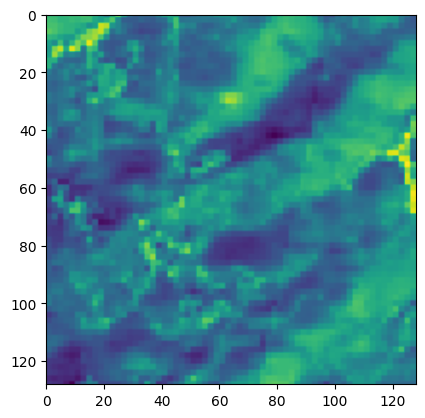

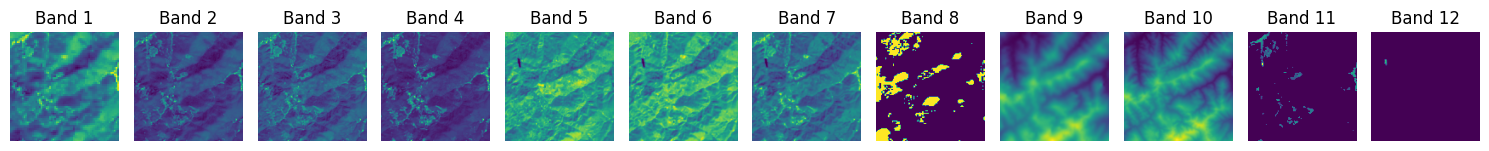

In [3]:

fp = '/kaggle/input/satellite-data/satalite data/train/images/40.tif'
img = rasterio.open(fp)
show(img)


# Open the raster file
with rasterio.open(fp) as src:
    # Read all bands
    bands = [src.read(i) for i in range(1, src.count + 1)]
    # Get metadata for plotting
    meta = src.meta
# Number of bands
num_bands = len(bands)

# Create subplots
fig, axes = plt.subplots(1, num_bands, figsize=(15, 5))

for i in range(num_bands):
    ax = axes[i]
    ax.imshow(bands[i])
    ax.set_title(f'Band {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()


In [4]:


file_path = '/kaggle/input/satellite-data/satalite data/train/images/10.tif'

# Open a TIFF file
image = tiff.imread(file_path)
image_array = np.array(image)

print(image_array.shape)



    

(128, 128, 12)


# Data Preproceeing

In [5]:

def convert_rgb_to_grayscale_and_reduce_bands(image):
    """
    Convert the RGB channels of a multi-band image to a single grayscale band and reduce the image to 10 bands.
    
    Parameters:
    image (numpy.ndarray): Input image with shape (height, width, 12 bands).

    Returns:
    numpy.ndarray: Image with shape (height, width, 10 bands) where the RGB channels are replaced by one grayscale band.
    """
    # Extract RGB channels (bands 1 to 3, which are indices 0 to 2)
    rgb_image = image[:, :, 1:4]
    
    # Define weights for the RGB channels (standard luminance formula)
    weights = np.array([0.2989, 0.5870, 0.1140])
    
    # Convert RGB to grayscale
    grayscale_image = np.dot(rgb_image, weights)
    
    # Create a new image array with shape (height, width, 10 bands)
    new_image = np.zeros((image.shape[0], image.shape[1], 10))
    
    # Place the grayscale image as the first band
    new_image[:, :, 1] = grayscale_image
    
    # Copy the remaining bands (0th, and 4th to 11th) into the new image (1st to 9th)
    new_image[:, :, 0]=image[:, :, 0]
    new_image[:, :, 2:] = image[:, :, 4:12] # Rest of the bands starting from the 6th band
    
    return new_image.astype(np.float32)

In [6]:
def apply_filter(image,filter_type,window_size=3):
    if filter_type == 'sharpen':
        kernel = np.array([[-1, -1, -1],
                           [-1,  9, -1],
                           [-1, -1, -1]])
    elif filter_type == 'gaussian_blur':
        kernel = cv2.getGaussianKernel(5, 1)
        kernel = np.outer(kernel, kernel)
  
    elif filter_type == 'emboss':
        kernel = np.array([[-2, -1, 0],
                           [-1,  1, 1],
                           [0,  1, 2]])
    elif filter_type == 'medianBlur':
        return cv2.medianBlur(image, window_size)
    elif filter_type == 'None':
        return image
    else:
        raise ValueError("Unknown filter type")

    return cv2.filter2D(image, -1, kernel)

def apply_filter_multi_bands(images, filter_type, window_size, num_bands):
    for i in range(num_bands):
        images[:, :, i] = apply_filter(images[:, :, i], filter_type, window_size)
    return images

        

def show(images,filter_type,num_bands):
    # Determine the grid size based on the number of bands
    rows = int(np.ceil(num_bands / 4))  # Number of rows needed
    cols = min(num_bands, 4)  # Max columns set to 4

    fig, axs = plt.subplots(rows, cols, figsize=(13, 13))
    axs = axs.ravel()  # Flatten the array of axes for easy iteration

    for i in range(num_bands):
        axs[i].imshow(apply_filter(images[:, :, i], filter_type, 3), cmap="jet", vmin=images[:, :, i].min(), vmax=images[:, :, i].max())
        axs[i].axis('off')
        plt.colorbar(axs[i].images[0], ax=axs[i], orientation='vertical')

    # Hide any remaining subplots if there are fewer bands than subplots
    for j in range(num_bands, len(axs)):
        axs[j].axis('off')

    plt.show()


(128, 128, 10)


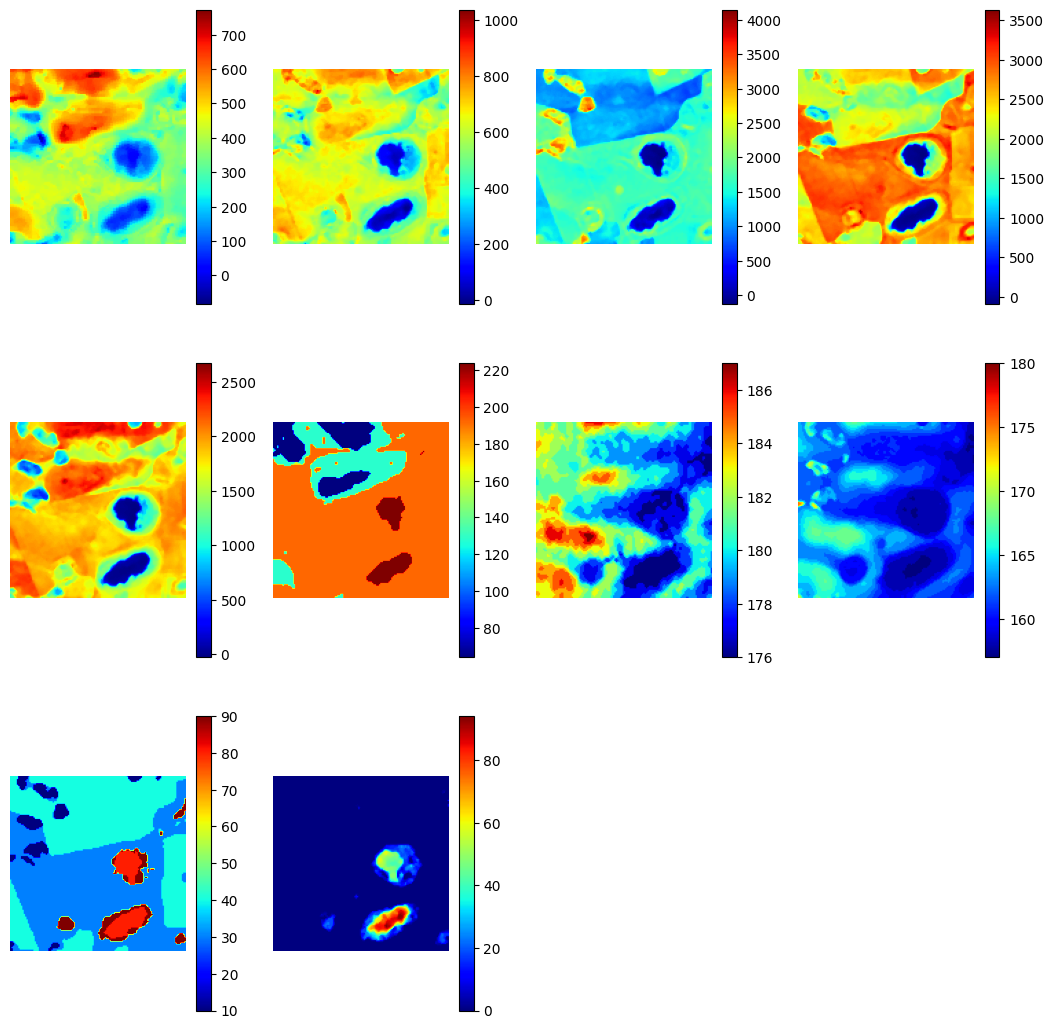

In [7]:
# Convert RGB channels to grayscale and reduce the number of bands to 10
converted_image = convert_rgb_to_grayscale_and_reduce_bands(image_array)

print(converted_image.shape)  # Should be (128, 128, 10)

show(converted_image,'medianBlur',converted_image.shape[2])

In [8]:

dataset_path = "/kaggle/input/satellite-data/satalite data"
train_images_path = os.path.join(dataset_path, "train", "images")
train_labels_path = os.path.join(dataset_path, "train", "labels")
val_images_path = os.path.join(dataset_path, "val", "images")

class SatelliteDataset(Dataset):
    def __init__(self, images_path, labels_path, transform=None, filter_type=None, window_size=3):
        # Load all image and label file paths
        self.image_files = sorted(os.listdir(images_path))
        if(labels_path!= None):
            self.label_files = sorted(os.listdir(labels_path))
            self.labels = [np.array(Image.open(os.path.join(labels_path, file))) for file in self.label_files]

        
        # Pre-load images and labels
        self.images = [np.array(tiff.imread(os.path.join(images_path, file))) for file in self.image_files]
        
        # Convert RGB to grayscale and reduce bands
        self.images = [convert_rgb_to_grayscale_and_reduce_bands(img) for img in self.images]

        # Apply filter to each image if specified
        if filter_type:
            self.images = [apply_filter_multi_bands(img, filter_type, window_size, img.shape[2]) for img in self.images]
                # Select only bands 2 (index 1),  11(index 9), and 12 (index 10)
        self.images = [self.select_bands(img) for img in self.images]
        self.images = [self.normalize(img) for img in self.images]
        self.data_len=len(self.images)
        
    def __len__(self):
        return self.data_len
    
    def normalize(self, image):
        """
        Normalize the image to the range [0, 1].
        
        Parameters:
        - image (numpy.ndarray): Input image.
        
        Returns:
        - numpy.ndarray: Normalized image.
        """
        # Normalize each band to [0, 1]
        min_val = np.min(image)
        max_val = np.max(image)
        normalized_image = (image - min_val) / (max_val - min_val)
        return normalized_image
        
    def select_bands(self, image):
        selected_bands = image[:, :, [1, 8, 9]]
        return selected_bands
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        # Apply albumentations transformations
        if self.transform:
            augmented = self.transform(image=image, mask=label)
            image = augmented['image']
            label = augmented['mask']

        return image, label
        

# Define your transformations
train_transforms = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=30, p=0.7),
    A.RandomCrop(height=128, width=128),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.4),
])
# Create datasets
train_dataset = SatelliteDataset(train_images_path,train_labels_path,train_transforms,"medianBlur",3)
# dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)


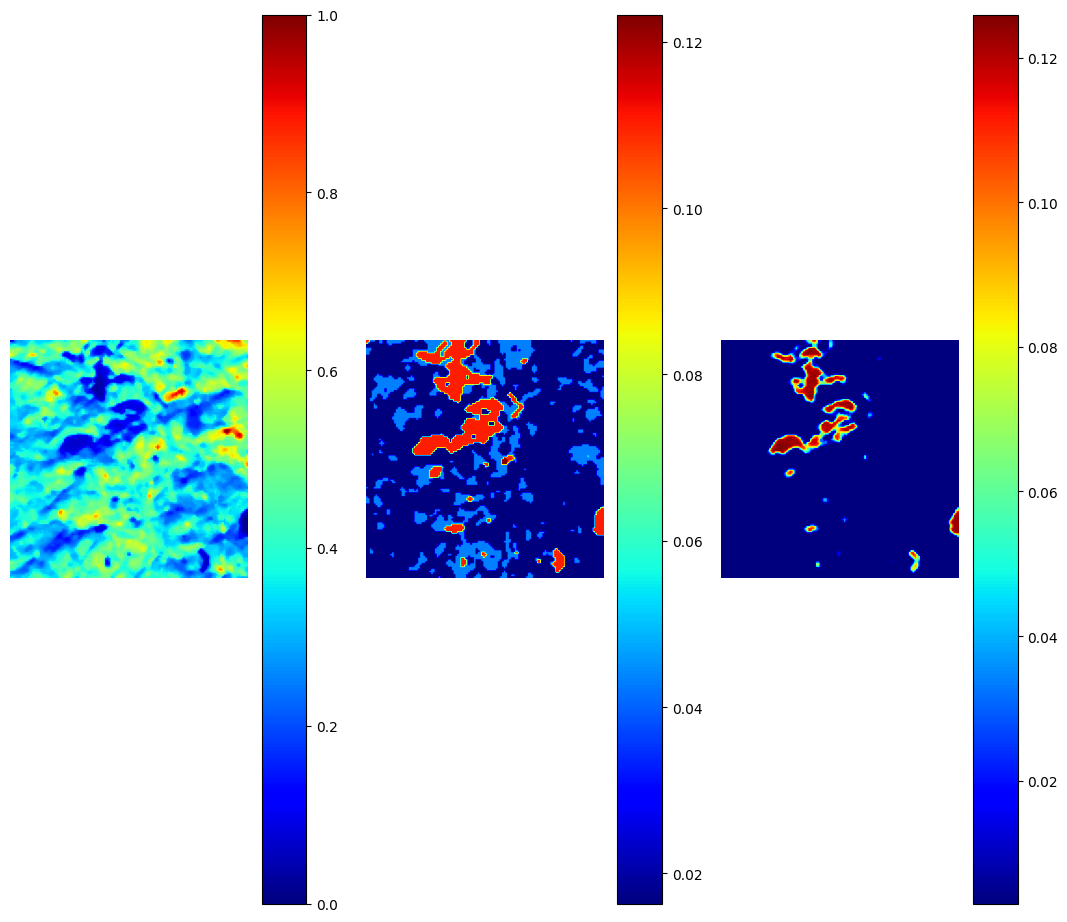

In [9]:
show(train_dataset.images[0],'None',train_dataset.images[0].shape[2])

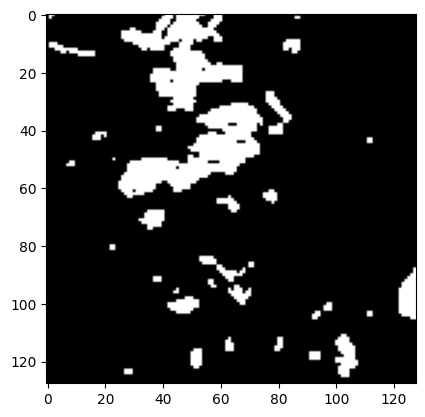

In [10]:
plt.imshow(train_dataset.labels[0], cmap="gray")


# Split dataset 

In [11]:
# Assuming the SatelliteDataset class returns lists
dataset = SatelliteDataset(train_images_path, train_labels_path, train_transforms, "medianBlur", 3)
train_images, test_images, train_labels, test_labels = train_test_split(
    dataset.images, dataset.labels, test_size=0.2, random_state=42
)

# Convert lists to NumPy arrays
train_images = np.array(train_images)
test_images = np.array(test_images)
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

# Add a channel dimension to labels
train_labels = np.expand_dims(train_labels, axis=-1)
test_labels = np.expand_dims(test_labels, axis=-1)

# Transpose and convert to tensors
x_train_torch = torch.tensor(train_images.transpose(0, 3, 1, 2)).float()
y_train_torch = torch.tensor(train_labels.transpose(0, 3, 1, 2)).float()
x_val_torch = torch.tensor(test_images.transpose(0, 3, 1, 2)).float()
y_val_torch = torch.tensor(test_labels.transpose(0, 3, 1, 2)).float()


# Model Creation

In [12]:
def dice_loss(Y_pred, Y_true):

    Y_pred = (Y_pred >= 0.5).float()
    Y_pred.requires_grad = True
    Y_true = Y_true.long()

    intersection = torch.sum(Y_pred * Y_true)
    union = torch.sum(Y_pred) + torch.sum(Y_true) - intersection
    epsilon = 1e-8

    dice_coefficient = (2.0 * intersection + epsilon) / (union + epsilon)
    return 1 - dice_coefficient

def jaccard_index(preds, targets, smooth=1e-6):
    # Convert predictions to binary (0 or 1)
    preds = torch.sigmoid(preds) > 0.5
    targets = targets.float()  # Ensure targets are float for arithmetic operations

    # Convert boolean tensors to int for bitwise operations
    preds = preds.int()
    targets = targets.int()

    # Compute intersection and union
    intersection = (preds & targets).float().sum()
    union = (preds | targets).float().sum()

    # Compute Jaccard Index
    iou = (intersection + smooth) / (union + smooth)
    return iou


def pixel_accuracy(preds, targets):
    # Convert predictions to binary (0 or 1)
    preds = torch.sigmoid(preds) > 0.5
    correct = (preds == targets).float().sum()
    total = targets.numel()
    return correct / total



class DiceLoss(torch.nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, prediction, target):
        dice = dice_loss(prediction, target)
        return torch.abs(dice)
    
    
class Pix2PixLoss(nn.Module):
    def __init__(self):
        super(Pix2PixLoss, self).__init__()
        self.l1_loss = nn.L1Loss()

    def forward(self, prediction, target):
        return self.l1_loss(prediction, target)
class JaccardLoss(nn.Module):
    def __init__(self):
        super(JaccardLoss, self).__init__()

    def forward(self, prediction, target):
        return 1- jaccard_index(prediction, target)
    

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move tensors to GPU if available
x_train_torch = x_train_torch.to(device)
y_train_torch = y_train_torch.to(device)
x_val_torch = x_val_torch.to(device)
y_val_torch = y_val_torch.to(device)


# Unet Model

In [14]:
# Initialize the model
Unet_model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    classes=1,
    activation=None
)
# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
Unet_model.to(device)

# Optimizer
optimizer = optim.Adam(Unet_model.parameters(), lr=1e-4)
bce_loss = nn.BCEWithLogitsLoss()
dice_loss_fn = DiceLoss()


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 238MB/s] 


In [15]:

# Set batch size


batch_size = 64
num_of_epoch=30

# Calculate number of batches
num_batches = len(x_train_torch) // batch_size

# Train the model
max_score = 0

for epoch in range(num_of_epoch):
    print('\nEpoch: {}'.format(epoch))
    total_loss_train = 0
    
    # Train
    Unet_model.train()
    for batch_idx in range(num_batches):
        start_idx = batch_idx * batch_size
        end_idx = (batch_idx + 1) * batch_size
        
        # Get batch
        x_batch = x_train_torch[start_idx:end_idx]
        y_batch = y_train_torch[start_idx:end_idx]
        
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        preds_train = Unet_model(x_batch)
        loss_train = bce_loss(preds_train, y_batch)
        total_loss_train += loss_train.item()
        
        # Backward pass
        loss_train.backward()
        optimizer.step()

    # Average training loss
    avg_loss_train = total_loss_train / num_batches
    
    # Validation
    Unet_model.eval()
    preds_val = Unet_model(x_val_torch)
    loss_val = bce_loss(preds_val, y_val_torch)
    
    # Metrics
    pixel_acc = pixel_accuracy((preds_val.sigmoid() > 0.5).cpu(), y_val_torch.cpu())
    jaccard_val = jaccard_index(preds_val, y_val_torch).item()
    dice_val = dice_loss_fn(preds_val, y_val_torch).item()


    
    print(f"Training Loss: {avg_loss_train}, Validation Loss: {loss_val.item()}, Pixel accuracy ={pixel_acc}, Jaccard Index: {jaccard_val:.4f}, Dice loss: {dice_val:.4f}")    

    



Epoch: 0
Training Loss: 0.9714994033177694, Validation Loss: 0.7518337368965149, Pixel accuracy =0.24776236712932587, Jaccard Index: 0.2187, Dice loss: 0.9802

Epoch: 1
Training Loss: 0.8072645465532938, Validation Loss: 0.8162936568260193, Pixel accuracy =0.22700746357440948, Jaccard Index: 0.2237, Dice loss: 0.6371

Epoch: 2
Training Loss: 0.7119449178377787, Validation Loss: 0.861181914806366, Pixel accuracy =0.22625732421875, Jaccard Index: 0.2242, Dice loss: 0.5206

Epoch: 3
Training Loss: 0.6521550814310709, Validation Loss: 0.8931702971458435, Pixel accuracy =0.22867214679718018, Jaccard Index: 0.2246, Dice loss: 0.4724

Epoch: 4
Training Loss: 0.6085832715034485, Validation Loss: 0.8780087828636169, Pixel accuracy =0.23949506878852844, Jaccard Index: 0.2262, Dice loss: 0.4356

Epoch: 5
Training Loss: 0.5731953183809916, Validation Loss: 0.8443477749824524, Pixel accuracy =0.26833418011665344, Jaccard Index: 0.2308, Dice loss: 0.3953

Epoch: 6
Training Loss: 0.5449299613634745,

# Unet Plus plus

In [16]:
# Initialize DeepLabV3 model with pre-trained weights
UnetPlusPlus_model = smp.UnetPlusPlus(encoder_name='resnet34', encoder_depth=5, encoder_weights='imagenet', decoder_channels=(256, 128, 64, 32, 16))
# Replace the classifier to fit your specific number of classes
UnetPlusPlus_model = UnetPlusPlus_model.to(device)  # Move model to the appropriate device (GPU or CPU)


In [17]:
# Set batch size and number of epochs
batch_size = 64
num_of_epoch = 30

# Calculate number of batches
num_batches = len(x_train_torch) // batch_size

# Initialize the optimizer
optimizer = optim.Adam(UnetPlusPlus_model.parameters(), lr=1e-4)

# Define the loss functions
bce_loss = torch.nn.BCEWithLogitsLoss()
dice_loss_fn = DiceLoss()  # Ensure you have a DiceLoss class defined

# Train the model
for epoch in range(num_of_epoch):
    print(f'\nEpoch: {epoch}')
    total_loss_train = 0
    
    UnetPlusPlus_model.train()
    for batch_idx in range(num_batches):
        start_idx = batch_idx * batch_size
        end_idx = (batch_idx + 1) * batch_size
        
        # Get batch
        x_batch = x_train_torch[start_idx:end_idx].to(device)
        y_batch = (y_train_torch[start_idx:end_idx]).to(device)
        
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs_train = UnetPlusPlus_model(x_batch)  # Access the output tensor
        loss_train = bce_loss(outputs_train, y_batch) 
        total_loss_train += loss_train.item()
        
        # Backward pass
        loss_train.backward()
        optimizer.step()

    # Average training loss
    avg_loss_train = total_loss_train / num_batches
    
    # Validation
    UnetPlusPlus_model.eval()
    with torch.no_grad():
        preds_val = UnetPlusPlus_model(x_val_torch.to(device))
        y_val_torch = (y_val_torch.to(device))
        loss_val = bce_loss(preds_val, y_val_torch) 
        
        # Metrics
        pixel_acc = pixel_accuracy((preds_val.sigmoid() > 0.5).cpu(), y_val_torch.cpu())
        jaccard_val = jaccard_index(preds_val, y_val_torch.to(device)).item()
        dice_val = dice_loss_fn(preds_val, y_val_torch.to(device)).item()
    
    print(f"Training Loss: {avg_loss_train:.4f}, Validation Loss: {loss_val.item():.4f}, Pixel Accuracy: {pixel_acc:.4f}, Jaccard Index: {jaccard_val:.4f}, Dice Loss: {dice_val:.4f}")


Epoch: 0
Training Loss: 0.8051, Validation Loss: 0.8059, Pixel Accuracy: 0.2905, Jaccard Index: 0.2278, Dice Loss: 0.4543

Epoch: 1
Training Loss: 0.6543, Validation Loss: 0.9438, Pixel Accuracy: 0.3124, Jaccard Index: 0.2343, Dice Loss: 0.4634

Epoch: 2
Training Loss: 0.5917, Validation Loss: 1.1486, Pixel Accuracy: 0.3354, Jaccard Index: 0.2391, Dice Loss: 0.4727

Epoch: 3
Training Loss: 0.5488, Validation Loss: 1.1712, Pixel Accuracy: 0.3858, Jaccard Index: 0.2480, Dice Loss: 0.4538

Epoch: 4
Training Loss: 0.5137, Validation Loss: 1.0603, Pixel Accuracy: 0.4709, Jaccard Index: 0.2650, Dice Loss: 0.4046

Epoch: 5
Training Loss: 0.4834, Validation Loss: 0.9172, Pixel Accuracy: 0.5745, Jaccard Index: 0.2958, Dice Loss: 0.3301

Epoch: 6
Training Loss: 0.4569, Validation Loss: 0.7851, Pixel Accuracy: 0.6624, Jaccard Index: 0.3319, Dice Loss: 0.2636

Epoch: 7
Training Loss: 0.4334, Validation Loss: 0.6809, Pixel Accuracy: 0.7270, Jaccard Index: 0.3672, Dice Loss: 0.2139

Epoch: 8
Traini

# PAN MODEL

In [18]:
# Initialize the PAN model if available
pan_model = smp.PAN(encoder_name="resnet34", encoder_weights="imagenet", classes=1, activation=None)


# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [19]:
# Set batch size
batch_size = 64
num_of_epoch = 30

# Calculate number of batches
num_batches = len(x_train_torch) // batch_size

# Initialize the model
pan_model = pan_model.to(device)  # Ensure model is initialized and moved to the appropriate device
optimizer = optim.Adam(pan_model.parameters(), lr=1e-4)

# Train the model
max_score = 0

for epoch in range(num_of_epoch):
    print('\nEpoch: {}'.format(epoch))
    total_loss_train = 0
    
    # Train
    pan_model.train()
    for batch_idx in range(num_batches):
        start_idx = batch_idx * batch_size
        end_idx = (batch_idx + 1) * batch_size
        
        # Get batch
        x_batch = x_train_torch[start_idx:end_idx].to(device)
        y_batch = y_train_torch[start_idx:end_idx].to(device)
        
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        preds_train = pan_model(x_batch)
        loss_train = bce_loss(preds_train, y_batch)
        total_loss_train += loss_train.item()
        
        # Backward pass
        loss_train.backward()
        optimizer.step()

    # Average training loss
    avg_loss_train = total_loss_train / num_batches
    
    # Validation
    pan_model.eval()
    with torch.no_grad():
        preds_val = pan_model(x_val_torch.to(device))
        loss_val = bce_loss(preds_val, y_val_torch.to(device))
        # Metrics
        pixel_acc = pixel_accuracy((preds_val.sigmoid() > 0.5).cpu(), y_val_torch.cpu())
        jaccard_val = jaccard_index(preds_val, y_val_torch.to(device)).item()
        dice_val = dice_loss_fn(preds_val, y_val_torch.to(device)).item()
    
    print(f"Training Loss: {avg_loss_train:.4f}, Validation Loss: {loss_val.item():.4f}, Pixel Accuracy: {pixel_acc:.4f}, Jaccard Index: {jaccard_val:.4f}, Dice Loss: {dice_val:.4f}")



Epoch: 0
Training Loss: 0.9269, Validation Loss: 1.1714, Pixel Accuracy: 0.2594, Jaccard Index: 0.2313, Dice Loss: 0.5021

Epoch: 1
Training Loss: 0.5168, Validation Loss: 0.7782, Pixel Accuracy: 0.5037, Jaccard Index: 0.2560, Dice Loss: 0.4390

Epoch: 2
Training Loss: 0.3704, Validation Loss: 0.5502, Pixel Accuracy: 0.7587, Jaccard Index: 0.3196, Dice Loss: 0.4357

Epoch: 3
Training Loss: 0.3031, Validation Loss: 0.4871, Pixel Accuracy: 0.7997, Jaccard Index: 0.3639, Dice Loss: 0.3095

Epoch: 4
Training Loss: 0.2693, Validation Loss: 0.3942, Pixel Accuracy: 0.8418, Jaccard Index: 0.4163, Dice Loss: 0.2282

Epoch: 5
Training Loss: 0.2473, Validation Loss: 0.3599, Pixel Accuracy: 0.8552, Jaccard Index: 0.4415, Dice Loss: 0.2004

Epoch: 6
Training Loss: 0.2322, Validation Loss: 0.3490, Pixel Accuracy: 0.8611, Jaccard Index: 0.4561, Dice Loss: 0.1628

Epoch: 7
Training Loss: 0.2207, Validation Loss: 0.3384, Pixel Accuracy: 0.8627, Jaccard Index: 0.4643, Dice Loss: 0.1374

Epoch: 8
Traini

# DeepLabV3 Model

In [20]:

# Initialize DeepLabV3Plus model with pre-trained weights
DeepLabV3_model = smp.DeepLabV3Plus(encoder_name='resnet34', encoder_depth=5, encoder_weights='imagenet', encoder_output_stride=8, decoder_channels=128)
# Replace the classifier to fit your specific number of classes
DeepLabV3_model = DeepLabV3_model.to(device)  # Move model to the appropriate device (GPU or CPU)

In [21]:
# Set batch size and number of epochs
batch_size = 64
num_of_epoch = 25

# Calculate number of batches
num_batches = len(x_train_torch) // batch_size

# Initialize the optimizer
optimizer = optim.Adam(DeepLabV3_model.parameters(), lr=1e-4)

# Define the loss functions
bce_loss = torch.nn.BCEWithLogitsLoss()
dice_loss_fn = DiceLoss()  # Ensure you have a DiceLoss class defined

# Train the model
for epoch in range(num_of_epoch):
    print(f'\nEpoch: {epoch}')
    total_loss_train = 0
    
    DeepLabV3_model.train()
    for batch_idx in range(num_batches):
        start_idx = batch_idx * batch_size
        end_idx = (batch_idx + 1) * batch_size
        
        # Get batch
        x_batch = x_train_torch[start_idx:end_idx].to(device)
        y_batch = (y_train_torch[start_idx:end_idx]).to(device)
        
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs_train = DeepLabV3_model(x_batch) # Access the output tensor
        loss_train = bce_loss(outputs_train, y_batch) 
        total_loss_train += loss_train.item()
        
        # Backward pass
        loss_train.backward()
        optimizer.step()

    # Average training loss
    avg_loss_train = total_loss_train / num_batches
    
    # Validation
    DeepLabV3_model.eval()
    with torch.no_grad():
        preds_val = DeepLabV3_model(x_val_torch.to(device))
        y_val_torch = (y_val_torch.to(device))
        loss_val = bce_loss(preds_val, y_val_torch) 
        
        # Metrics
        pixel_acc = pixel_accuracy((preds_val.sigmoid() > 0.5).cpu(), y_val_torch.cpu())
        jaccard_val = jaccard_index(preds_val, y_val_torch.to(device)).item()
        dice_val = dice_loss_fn(preds_val, y_val_torch.to(device)).item()
    
    print(f"Training Loss: {avg_loss_train:.4f}, Validation Loss: {loss_val.item():.4f}, Pixel Accuracy: {pixel_acc:.4f}, Jaccard Index: {jaccard_val:.4f}, Dice Loss: {dice_val:.4f}")


Epoch: 0
Training Loss: 0.6046, Validation Loss: 0.6766, Pixel Accuracy: 0.7756, Jaccard Index: 0.0000, Dice Loss: 1.0000

Epoch: 1
Training Loss: 0.5022, Validation Loss: 0.6758, Pixel Accuracy: 0.7768, Jaccard Index: 0.3699, Dice Loss: 1.0000

Epoch: 2
Training Loss: 0.4372, Validation Loss: 0.6670, Pixel Accuracy: 0.6657, Jaccard Index: 0.3324, Dice Loss: 0.8371

Epoch: 3
Training Loss: 0.3941, Validation Loss: 0.6247, Pixel Accuracy: 0.7434, Jaccard Index: 0.3921, Dice Loss: 0.2898

Epoch: 4
Training Loss: 0.3610, Validation Loss: 0.5503, Pixel Accuracy: 0.8183, Jaccard Index: 0.4610, Dice Loss: 0.1931

Epoch: 5
Training Loss: 0.3348, Validation Loss: 0.4611, Pixel Accuracy: 0.8467, Jaccard Index: 0.4873, Dice Loss: 0.1480

Epoch: 6
Training Loss: 0.3149, Validation Loss: 0.4068, Pixel Accuracy: 0.8523, Jaccard Index: 0.4832, Dice Loss: 0.1493

Epoch: 7
Training Loss: 0.2998, Validation Loss: 0.3565, Pixel Accuracy: 0.8729, Jaccard Index: 0.5128, Dice Loss: 0.1033

Epoch: 8
Traini

#  DeepLabV3Plus model 

In [22]:
# Initialize DeepLabV3Plus model with pre-trained weights
DeepLabV3Plus_model = smp.DeepLabV3Plus(encoder_name='resnet34', encoder_depth=5, encoder_weights='imagenet', encoder_output_stride=8, decoder_channels=128)
# Replace the classifier to fit your specific number of classes
DeepLabV3Plus_model = DeepLabV3Plus_model.to(device)  # Move model to the appropriate device (GPU or CPU)


In [23]:
# Set batch size and number of epochs
batch_size = 64
num_of_epoch = 30

# Calculate number of batches
num_batches = len(x_train_torch) // batch_size

# Initialize the optimizer
optimizer = optim.Adam(DeepLabV3Plus_model.parameters(), lr=1e-4)

# Define the loss functions
bce_loss = torch.nn.BCEWithLogitsLoss()
dice_loss_fn = DiceLoss()  # Ensure you have a DiceLoss class defined

# Train the model
for epoch in range(num_of_epoch):
    print(f'\nEpoch: {epoch}')
    total_loss_train = 0
    
    DeepLabV3Plus_model.train()
    for batch_idx in range(num_batches):
        start_idx = batch_idx * batch_size
        end_idx = (batch_idx + 1) * batch_size
        
        # Get batch
        x_batch = x_train_torch[start_idx:end_idx].to(device)
        y_batch = (y_train_torch[start_idx:end_idx]).to(device)
        
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs_train = DeepLabV3Plus_model(x_batch)  # Access the output tensor
        loss_train = bce_loss(outputs_train, y_batch)
        total_loss_train += loss_train.item()
        
        # Backward pass
        loss_train.backward()
        optimizer.step()

    # Average training loss
    avg_loss_train = total_loss_train / num_batches
    
    # Validation
    DeepLabV3Plus_model.eval()
    with torch.no_grad():
        preds_val = DeepLabV3Plus_model(x_val_torch.to(device))
        y_val_torch = (y_val_torch.to(device))
        loss_val = bce_loss(preds_val, y_val_torch) 
        
        # Metrics
        pixel_acc = pixel_accuracy((preds_val.sigmoid() > 0.5).cpu(), y_val_torch.cpu())
        jaccard_val = jaccard_index(preds_val, y_val_torch.to(device)).item()
        dice_val = dice_loss_fn(preds_val, y_val_torch.to(device)).item()
    
    print(f"Training Loss: {avg_loss_train:.4f}, Validation Loss: {loss_val.item():.4f}, Pixel Accuracy: {pixel_acc:.4f}, Jaccard Index: {jaccard_val:.4f}, Dice Loss: {dice_val:.4f}")


Epoch: 0
Training Loss: 1.5181, Validation Loss: 1.6921, Pixel Accuracy: 0.5671, Jaccard Index: 0.2568, Dice Loss: 1.0000

Epoch: 1
Training Loss: 0.9592, Validation Loss: 1.6905, Pixel Accuracy: 0.6272, Jaccard Index: 0.2765, Dice Loss: 1.0000

Epoch: 2
Training Loss: 0.6732, Validation Loss: 1.6891, Pixel Accuracy: 0.6088, Jaccard Index: 0.2855, Dice Loss: 1.0000

Epoch: 3
Training Loss: 0.5367, Validation Loss: 1.6872, Pixel Accuracy: 0.5927, Jaccard Index: 0.2913, Dice Loss: 1.0000

Epoch: 4
Training Loss: 0.5750, Validation Loss: 1.6835, Pixel Accuracy: 0.5969, Jaccard Index: 0.3029, Dice Loss: 1.0000

Epoch: 5
Training Loss: 0.6162, Validation Loss: 1.5755, Pixel Accuracy: 0.6122, Jaccard Index: 0.3150, Dice Loss: 0.8982

Epoch: 6
Training Loss: 0.6393, Validation Loss: 1.1897, Pixel Accuracy: 0.6537, Jaccard Index: 0.3392, Dice Loss: 0.5243

Epoch: 7
Training Loss: 0.6535, Validation Loss: 0.9513, Pixel Accuracy: 0.7197, Jaccard Index: 0.3833, Dice Loss: 0.3075

Epoch: 8
Traini

# Try to use dataset without select channels 

In [24]:

dataset_path = "/kaggle/input/satellite-data/satalite data"
train_images_path = os.path.join(dataset_path, "train", "images")
train_labels_path = os.path.join(dataset_path, "train", "labels")
val_images_path = os.path.join(dataset_path, "val", "images")

class SatelliteDataset_2(Dataset):
    def __init__(self, images_path, labels_path, transform=None, filter_type=None, window_size=3):
        # Load all image and label file paths
        self.image_files = sorted(os.listdir(images_path))
        if(labels_path !=None):
            self.label_files = sorted(os.listdir(labels_path))
            self.labels = [np.array(Image.open(os.path.join(labels_path, file))) for file in self.label_files]

        
        # Pre-load images and labels
        self.images = [np.array(tiff.imread(os.path.join(images_path, file))) for file in self.image_files]
        
        # Apply filter to each image if specified
        if filter_type:
            self.images = [apply_filter_multi_bands(img, filter_type, window_size, img.shape[2]) for img in self.images]
        self.images = [self.normalize(img) for img in self.images]
        self.data_len=len(self.images)
        
    def __len__(self):
        return self.data_len
    
    def normalize(self, image):
        """
        Normalize the image to the range [0, 1].
        
        Parameters:
        - image (numpy.ndarray): Input image.
        
        Returns:
        - numpy.ndarray: Normalized image.
        """
        # Normalize each band to [0, 1]
        min_val = np.min(image)
        max_val = np.max(image)
        normalized_image = (image - min_val) / (max_val - min_val)
        return normalized_image
        
    def select_bands(self, image):
        selected_bands = image[:, :, [1, 8, 9]]
        return selected_bands
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        # Apply albumentations transformations
        if self.transform:
            augmented = self.transform(image=image, mask=label)
            image = augmented['image']
            label = augmented['mask']

        return image, label
        

# Define your transformations
train_transforms = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=30, p=0.7),
    A.RandomCrop(height=128, width=128),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.4),
])



In [25]:
# Assuming the SatelliteDataset class returns lists
dataset_2 = SatelliteDataset_2(train_images_path, train_labels_path, None, "medianBlur", 3)
train_images_2, test_images_2, train_labels_2, test_labels_2 = train_test_split(
    dataset_2.images, dataset_2.labels, test_size=0.2, random_state=42
)

# Convert lists to NumPy arrays
train_images_2 = np.array(train_images_2)
test_images_2 = np.array(test_images_2)
train_labels_2 = np.array(train_labels_2)
test_labels_2 = np.array(test_labels_2)

# Add a channel dimension to labels
train_labels_2 = np.expand_dims(train_labels_2, axis=-1)
test_labels_2 = np.expand_dims(test_labels_2, axis=-1)

# Transpose and convert to tensors
x_train_torch_2 = torch.tensor(train_images_2.transpose(0, 3, 1, 2)).float()
y_train_torch_2 = torch.tensor(train_labels_2.transpose(0, 3, 1, 2)).float()
x_val_torch_2 = torch.tensor(test_images_2.transpose(0, 3, 1, 2)).float()
y_val_torch_2 = torch.tensor(test_labels_2.transpose(0, 3, 1, 2)).float()


In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move tensors to GPU if available
x_train_torch_2 = x_train_torch_2.to(device)
y_train_torch_2 = y_train_torch_2.to(device)
x_val_torch_2 = x_val_torch_2.to(device)
y_val_torch_2 = y_val_torch_2.to(device)


In [27]:
class seg_ConvDeconvNet(nn.Module):
    def __init__(self, model):
        super(seg_ConvDeconvNet, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=16, kernel_size=3, stride=1, padding=1),  # Output: (16, H, W)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: (16, H/2, W/2)
            
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),  # Output: (32, H/2, W/2)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Output: (32, H/4, W/4)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=2, stride=2),  # Output: (16, H/2, W/2)
            nn.ReLU(),
            
            nn.ConvTranspose2d(in_channels=16, out_channels=3, kernel_size=2, stride=2),  # Output: (3, H, W)
            nn.ReLU()
        )
        
        self.segmentation_model = model  # Assign the model parameter

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        x = self.segmentation_model(x)
        return x


In [28]:

# Initialize the model
Unet_encoder_decoder_model = seg_ConvDeconvNet(smp.Unet(encoder_name="resnet34",encoder_weights="imagenet",classes=1, activation=None)).to(device)

# Set batch size and number of epochs
batch_size = 32
num_of_epoch = 30

# Calculate number of batches
num_batches = len(x_train_torch_2) // batch_size

# Initialize the optimizer
optimizer = optim.Adam(Unet_encoder_decoder_model.parameters(), lr=1e-4)

# Define the loss functions
bce_loss = torch.nn.BCEWithLogitsLoss()
dice_loss_fn = DiceLoss()  # Ensure you have a DiceLoss class defined

# Train the model
for epoch in range(num_of_epoch):
    print(f'\nEpoch: {epoch}')
    total_loss_train = 0
    
    Unet_encoder_decoder_model.train()
    for batch_idx in range(num_batches):
        start_idx = batch_idx * batch_size
        end_idx = (batch_idx + 1) * batch_size
        
        # Get batch
        x_batch = x_train_torch_2[start_idx:end_idx].to(device)
        y_batch = y_train_torch_2[start_idx:end_idx].to(device)
        
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs_train = Unet_encoder_decoder_model(x_batch)
        loss_train = bce_loss(outputs_train, y_batch) 
        total_loss_train += loss_train.item()
        
        # Backward pass
        loss_train.backward()
        optimizer.step()

    # Average training loss
    avg_loss_train = total_loss_train / num_batches
    
    # Validation
    Unet_encoder_decoder_model.eval()
    with torch.no_grad():
        preds_val = Unet_encoder_decoder_model(x_val_torch_2.to(device))
        y_val_torch_2 = y_val_torch_2.to(device)
        loss_val = bce_loss(preds_val, y_val_torch_2) 
        
        # Metrics
        pixel_acc = pixel_accuracy((preds_val.sigmoid() > 0.5).cpu(), y_val_torch_2.cpu())
        jaccard_val = jaccard_index(preds_val.sigmoid() > 0.5, y_val_torch_2).item()
        dice_val = dice_loss_fn(preds_val.sigmoid() > 0.5, y_val_torch_2).item()
    
    print(f"Training Loss: {avg_loss_train:.4f}, Validation Loss: {loss_val.item():.4f}, Pixel Accuracy: {pixel_acc:.4f}, Jaccard Index: {jaccard_val:.4f}, Dice Loss: {dice_val:.4f}")



Epoch: 0
Training Loss: 0.7412, Validation Loss: 1.9842, Pixel Accuracy: 0.2418, Jaccard Index: 0.2229, Dice Loss: 0.5543

Epoch: 1
Training Loss: 0.5769, Validation Loss: 4.5898, Pixel Accuracy: 0.2272, Jaccard Index: 0.2245, Dice Loss: 0.5511

Epoch: 2
Training Loss: 0.5053, Validation Loss: 4.5739, Pixel Accuracy: 0.2288, Jaccard Index: 0.2245, Dice Loss: 0.5511

Epoch: 3
Training Loss: 0.4568, Validation Loss: 4.6096, Pixel Accuracy: 0.2299, Jaccard Index: 0.2244, Dice Loss: 0.5511

Epoch: 4
Training Loss: 0.4242, Validation Loss: 4.5922, Pixel Accuracy: 0.2300, Jaccard Index: 0.2246, Dice Loss: 0.5509

Epoch: 5
Training Loss: 0.4000, Validation Loss: 4.2246, Pixel Accuracy: 0.2318, Jaccard Index: 0.2247, Dice Loss: 0.5505

Epoch: 6
Training Loss: 0.3813, Validation Loss: 3.9342, Pixel Accuracy: 0.2371, Jaccard Index: 0.2253, Dice Loss: 0.5494

Epoch: 7
Training Loss: 0.3643, Validation Loss: 3.3501, Pixel Accuracy: 0.2575, Jaccard Index: 0.2268, Dice Loss: 0.5463

Epoch: 8
Traini

In [29]:
# Initialize the model
UnetPlusPlus_encoder_decoder_model = seg_ConvDeconvNet(smp.UnetPlusPlus(encoder_name='resnet34', encoder_depth=5, encoder_weights='imagenet', decoder_channels=(256, 128, 64, 32, 16))).to(device)

# Set batch size and number of epochs
batch_size = 32
num_of_epoch = 30

# Calculate number of batches
num_batches = len(x_train_torch_2) // batch_size

# Initialize the optimizer
optimizer = optim.Adam(UnetPlusPlus_encoder_decoder_model.parameters(), lr=1e-4)

# Define the loss functions
bce_loss =  torch.nn.BCEWithLogitsLoss()
dice_loss_fn = DiceLoss()  # Ensure you have a DiceLoss class defined

# Train the model
for epoch in range(num_of_epoch):
    print(f'\nEpoch: {epoch}')
    total_loss_train = 0
    
    UnetPlusPlus_encoder_decoder_model.train()
    for batch_idx in range(num_batches):
        start_idx = batch_idx * batch_size
        end_idx = (batch_idx + 1) * batch_size
        
        # Get batch
        x_batch = x_train_torch_2[start_idx:end_idx].to(device)
        y_batch = y_train_torch_2[start_idx:end_idx].to(device)
        
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs_train = UnetPlusPlus_encoder_decoder_model(x_batch)
        loss_train = bce_loss(outputs_train, y_batch) 
        total_loss_train += loss_train.item()
        
        # Backward pass
        loss_train.backward()
        optimizer.step()

    # Average training loss
    avg_loss_train = total_loss_train / num_batches
    
    # Validation
    UnetPlusPlus_encoder_decoder_model.eval()
    with torch.no_grad():
        preds_val = UnetPlusPlus_encoder_decoder_model(x_val_torch_2.to(device))
        y_val_torch_2 = y_val_torch_2.to(device)
        loss_val = bce_loss(preds_val, y_val_torch_2) 
        
        # Metrics
        pixel_acc = pixel_accuracy((preds_val.sigmoid() > 0.5).cpu(), y_val_torch_2.cpu())
        jaccard_val = jaccard_index(preds_val.sigmoid() > 0.5, y_val_torch_2).item()
        dice_val = dice_loss_fn(preds_val.sigmoid() > 0.5, y_val_torch_2).item()
    
    print(f"Training Loss: {avg_loss_train:.4f}, Validation Loss: {loss_val.item():.4f}, Pixel Accuracy: {pixel_acc:.4f}, Jaccard Index: {jaccard_val:.4f}, Dice Loss: {dice_val:.4f}")


Epoch: 0
Training Loss: 0.6566, Validation Loss: 0.8506, Pixel Accuracy: 0.2362, Jaccard Index: 0.2240, Dice Loss: 0.5520

Epoch: 1
Training Loss: 0.5157, Validation Loss: 0.9451, Pixel Accuracy: 0.2494, Jaccard Index: 0.2228, Dice Loss: 0.5543

Epoch: 2
Training Loss: 0.4296, Validation Loss: 1.0749, Pixel Accuracy: 0.2768, Jaccard Index: 0.2208, Dice Loss: 0.5583

Epoch: 3
Training Loss: 0.3757, Validation Loss: 1.1002, Pixel Accuracy: 0.2897, Jaccard Index: 0.2205, Dice Loss: 0.5591

Epoch: 4
Training Loss: 0.3395, Validation Loss: 1.3666, Pixel Accuracy: 0.2597, Jaccard Index: 0.2224, Dice Loss: 0.5552

Epoch: 5
Training Loss: 0.3155, Validation Loss: 1.6604, Pixel Accuracy: 0.2528, Jaccard Index: 0.2228, Dice Loss: 0.5545

Epoch: 6
Training Loss: 0.2954, Validation Loss: 1.8901, Pixel Accuracy: 0.2457, Jaccard Index: 0.2230, Dice Loss: 0.5539

Epoch: 7
Training Loss: 0.2795, Validation Loss: 1.9903, Pixel Accuracy: 0.2410, Jaccard Index: 0.2233, Dice Loss: 0.5533

Epoch: 8
Traini

In [30]:
# Initialize the model
pan_encoder_decoder_model = seg_ConvDeconvNet(smp.PAN(encoder_name="resnet34", encoder_weights="imagenet", classes=1, activation=None)).to(device)

# Set batch size and number of epochs
batch_size = 32
num_of_epoch = 30

# Calculate number of batches
num_batches = len(x_train_torch_2) // batch_size

# Initialize the optimizer
optimizer = optim.Adam(pan_encoder_decoder_model.parameters(), lr=1e-4)

# Define the loss functions
bce_loss =  torch.nn.BCEWithLogitsLoss()
dice_loss_fn = DiceLoss()  # Ensure you have a DiceLoss class defined

# Train the model
for epoch in range(num_of_epoch):
    print(f'\nEpoch: {epoch}')
    total_loss_train = 0
    
    pan_encoder_decoder_model.train()
    for batch_idx in range(num_batches):
        start_idx = batch_idx * batch_size
        end_idx = (batch_idx + 1) * batch_size
        
        # Get batch
        x_batch = x_train_torch_2[start_idx:end_idx].to(device)
        y_batch = y_train_torch_2[start_idx:end_idx].to(device)
        
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs_train = pan_encoder_decoder_model(x_batch)
        loss_train = bce_loss(outputs_train, y_batch) + dice_loss_fn(outputs_train, y_batch)
        total_loss_train += loss_train.item()
        
        # Backward pass
        loss_train.backward()
        optimizer.step()

    # Average training loss
    avg_loss_train = total_loss_train / num_batches
    
    # Validation
    pan_encoder_decoder_model.eval()
    with torch.no_grad():
        preds_val = pan_encoder_decoder_model(x_val_torch_2.to(device))
        y_val_torch_2 = y_val_torch_2.to(device)
        loss_val = bce_loss(preds_val, y_val_torch_2)
        
        # Metrics
        pixel_acc = pixel_accuracy((preds_val.sigmoid() > 0.5).cpu(), y_val_torch_2.cpu())
        jaccard_val = jaccard_index(preds_val.sigmoid() > 0.5, y_val_torch_2).item()
        dice_val = dice_loss_fn(preds_val.sigmoid() > 0.5, y_val_torch_2).item()
    
    print(f"Training Loss: {avg_loss_train:.4f}, Validation Loss: {loss_val.item():.4f}, Pixel Accuracy: {pixel_acc:.4f}, Jaccard Index: {jaccard_val:.4f}, Dice Loss: {dice_val:.4f}")


Epoch: 0
Training Loss: 1.6627, Validation Loss: 1.4208, Pixel Accuracy: 0.2244, Jaccard Index: 0.2244, Dice Loss: 0.5513

Epoch: 1
Training Loss: 0.7644, Validation Loss: 0.9463, Pixel Accuracy: 0.2462, Jaccard Index: 0.2242, Dice Loss: 0.5515

Epoch: 2
Training Loss: 0.5325, Validation Loss: 0.5724, Pixel Accuracy: 0.7556, Jaccard Index: 0.0309, Dice Loss: 0.9382

Epoch: 3
Training Loss: 0.5024, Validation Loss: 0.5912, Pixel Accuracy: 0.7421, Jaccard Index: 0.0415, Dice Loss: 0.9171

Epoch: 4
Training Loss: 0.4894, Validation Loss: 0.5938, Pixel Accuracy: 0.7326, Jaccard Index: 0.0545, Dice Loss: 0.8910

Epoch: 5
Training Loss: 0.4966, Validation Loss: 0.5854, Pixel Accuracy: 0.7402, Jaccard Index: 0.0459, Dice Loss: 0.9082

Epoch: 6
Training Loss: 0.4982, Validation Loss: 0.5874, Pixel Accuracy: 0.7515, Jaccard Index: 0.0284, Dice Loss: 0.9433

Epoch: 7
Training Loss: 0.4932, Validation Loss: 0.5724, Pixel Accuracy: 0.7612, Jaccard Index: 0.0144, Dice Loss: 0.9713

Epoch: 8
Traini

In [31]:
# Initialize the model
DeepLabV3_encoder_decoder_model = seg_ConvDeconvNet(smp.DeepLabV3(encoder_name='resnet34', encoder_depth=5, encoder_weights='imagenet', decoder_channels=128)).to(device)

# Set batch size and number of epochs
batch_size = 32
num_of_epoch = 30

# Calculate number of batches
num_batches = len(x_train_torch_2) // batch_size

# Initialize the optimizer
optimizer = optim.Adam(DeepLabV3_encoder_decoder_model.parameters(), lr=1e-4)

# Define the loss functions
bce_loss =  torch.nn.BCEWithLogitsLoss()
dice_loss_fn = DiceLoss()  # Ensure you have a DiceLoss class defined

# Train the model
for epoch in range(num_of_epoch):
    print(f'\nEpoch: {epoch}')
    total_loss_train = 0
    
    DeepLabV3_encoder_decoder_model.train()
    for batch_idx in range(num_batches):
        start_idx = batch_idx * batch_size
        end_idx = (batch_idx + 1) * batch_size
        
        # Get batch
        x_batch = x_train_torch_2[start_idx:end_idx].to(device)
        y_batch = y_train_torch_2[start_idx:end_idx].to(device)
        
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs_train = DeepLabV3_encoder_decoder_model(x_batch)
        loss_train = bce_loss(outputs_train, y_batch) 
        total_loss_train += loss_train.item()
        
        # Backward pass
        loss_train.backward()
        optimizer.step()

    # Average training loss
    avg_loss_train = total_loss_train / num_batches
    
    # Validation
    DeepLabV3_encoder_decoder_model.eval()
    with torch.no_grad():
        preds_val = DeepLabV3_encoder_decoder_model(x_val_torch_2.to(device))
        y_val_torch = y_val_torch_2.to(device)
        loss_val = bce_loss(preds_val, y_val_torch)    
        # Metrics
        pixel_acc = pixel_accuracy((preds_val.sigmoid() > 0.5).cpu(), y_val_torch.cpu())
        jaccard_val = jaccard_index(preds_val.sigmoid() > 0.5, y_val_torch).item()
        dice_val = dice_loss_fn(preds_val.sigmoid() > 0.5, y_val_torch).item()
    
    print(f"Training Loss: {avg_loss_train:.4f}, Validation Loss: {loss_val.item():.4f}, Pixel Accuracy: {pixel_acc:.4f}, Jaccard Index: {jaccard_val:.4f}, Dice Loss: {dice_val:.4f}")


Epoch: 0
Training Loss: 0.6251, Validation Loss: 0.6867, Pixel Accuracy: 0.6838, Jaccard Index: 0.1112, Dice Loss: 0.7775

Epoch: 1
Training Loss: 0.4880, Validation Loss: 0.6655, Pixel Accuracy: 0.7591, Jaccard Index: 0.0249, Dice Loss: 0.9502

Epoch: 2
Training Loss: 0.4072, Validation Loss: 0.6257, Pixel Accuracy: 0.7518, Jaccard Index: 0.0369, Dice Loss: 0.9262

Epoch: 3
Training Loss: 0.3584, Validation Loss: 0.6351, Pixel Accuracy: 0.6795, Jaccard Index: 0.1090, Dice Loss: 0.7820

Epoch: 4
Training Loss: 0.3272, Validation Loss: 0.6826, Pixel Accuracy: 0.5766, Jaccard Index: 0.1505, Dice Loss: 0.6991

Epoch: 5
Training Loss: 0.3052, Validation Loss: 0.6145, Pixel Accuracy: 0.6867, Jaccard Index: 0.1265, Dice Loss: 0.7471

Epoch: 6
Training Loss: 0.2893, Validation Loss: 0.5994, Pixel Accuracy: 0.7164, Jaccard Index: 0.1570, Dice Loss: 0.6860

Epoch: 7
Training Loss: 0.2772, Validation Loss: 0.5916, Pixel Accuracy: 0.7307, Jaccard Index: 0.1804, Dice Loss: 0.6392

Epoch: 8
Traini

In [32]:
# Initialize the model
DeepLabV3Plus_encoder_decoder_model = seg_ConvDeconvNet(smp.DeepLabV3Plus(encoder_name='resnet34', encoder_depth=5, encoder_weights='imagenet', encoder_output_stride=16, decoder_channels=128)).to(device)

# Set batch size and number of epochs
batch_size = 32
num_of_epoch = 30

# Calculate number of batches
num_batches = len(x_train_torch_2) // batch_size

# Initialize the optimizer
optimizer = optim.Adam(DeepLabV3Plus_encoder_decoder_model.parameters(), lr=1e-4)

# Define the loss functions
bce_loss =  torch.nn.BCEWithLogitsLoss()
dice_loss_fn = DiceLoss()  # Ensure you have a DiceLoss class defined

# Train the model
for epoch in range(num_of_epoch):
    print(f'\nEpoch: {epoch}')
    total_loss_train = 0
    
    DeepLabV3Plus_encoder_decoder_model.train()
    for batch_idx in range(num_batches):
        start_idx = batch_idx * batch_size
        end_idx = (batch_idx + 1) * batch_size
        
        # Get batch
        x_batch = x_train_torch_2[start_idx:end_idx].to(device)
        y_batch = y_train_torch_2[start_idx:end_idx].to(device)
        
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs_train = DeepLabV3Plus_encoder_decoder_model(x_batch)
        loss_train = bce_loss(outputs_train, y_batch)
        total_loss_train += loss_train.item()
        
        # Backward pass
        loss_train.backward()
        optimizer.step()

    # Average training loss
    avg_loss_train = total_loss_train / num_batches
    
    # Validation
    DeepLabV3Plus_encoder_decoder_model.eval()
    with torch.no_grad():
        preds_val = DeepLabV3Plus_encoder_decoder_model(x_val_torch_2.to(device))
        y_val_torch = y_val_torch_2.to(device)
        loss_val = bce_loss(preds_val, y_val_torch) 
        
        # Metrics
        pixel_acc = pixel_accuracy((preds_val.sigmoid() > 0.5).cpu(), y_val_torch.cpu())
        jaccard_val = jaccard_index(preds_val.sigmoid() > 0.5, y_val_torch).item()
        dice_val = dice_loss_fn(preds_val.sigmoid() > 0.5, y_val_torch).item()
    
    print(f"Training Loss: {avg_loss_train:.4f}, Validation Loss: {loss_val.item():.4f}, Pixel Accuracy: {pixel_acc:.4f}, Jaccard Index: {jaccard_val:.4f}, Dice Loss: {dice_val:.4f}")


Epoch: 0
Training Loss: 0.6085, Validation Loss: 0.6852, Pixel Accuracy: 0.7756, Jaccard Index: 0.0000, Dice Loss: 1.0000

Epoch: 1
Training Loss: 0.5081, Validation Loss: 0.6698, Pixel Accuracy: 0.7756, Jaccard Index: 0.0000, Dice Loss: 1.0000

Epoch: 2
Training Loss: 0.4478, Validation Loss: 0.6494, Pixel Accuracy: 0.7756, Jaccard Index: 0.0000, Dice Loss: 1.0000

Epoch: 3
Training Loss: 0.4070, Validation Loss: 0.6131, Pixel Accuracy: 0.7756, Jaccard Index: 0.0000, Dice Loss: 1.0000

Epoch: 4
Training Loss: 0.3732, Validation Loss: 0.5654, Pixel Accuracy: 0.7756, Jaccard Index: 0.0000, Dice Loss: 1.0000

Epoch: 5
Training Loss: 0.3502, Validation Loss: 0.5297, Pixel Accuracy: 0.7756, Jaccard Index: 0.0000, Dice Loss: 1.0000

Epoch: 6
Training Loss: 0.3286, Validation Loss: 0.5117, Pixel Accuracy: 0.7783, Jaccard Index: 0.0213, Dice Loss: 0.9574

Epoch: 7
Training Loss: 0.3120, Validation Loss: 0.5027, Pixel Accuracy: 0.7803, Jaccard Index: 0.0597, Dice Loss: 0.8806

Epoch: 8
Traini

In [33]:
 torch.save(Unet_model.state_dict(), "/kaggle/working/Unet_model.pth")
 torch.save(UnetPlusPlus_model.state_dict(), "/kaggle/working/UnetPlusPlus_model.pth")
 torch.save(pan_model.state_dict(), "/kaggle/working/pan_model.pth")
 torch.save(DeepLabV3_model.state_dict(), "/kaggle/working/DeepLabV3_model.pth") 
 torch.save(DeepLabV3Plus_model.state_dict(), "/kaggle/working/DeepLabV3Plus_model.pth")
 torch.save(Unet_encoder_decoder_model.state_dict(), "/kaggle/working/Unet_encoder_decoder_model.pth")
 torch.save(UnetPlusPlus_encoder_decoder_model.state_dict(), "/kaggle/working/UnetPlusPlus_encoder_decoder_model.pth")    
 torch.save(pan_encoder_decoder_model.state_dict(), "/kaggle/working/pan_encoder_decoder_model.pth")
 torch.save(DeepLabV3_encoder_decoder_model.state_dict(), "/kaggle/working/DeepLabV3_encoder_decoder_model.pth")
 torch.save(DeepLabV3Plus_encoder_decoder_model.state_dict(), "/kaggle/working/DeepLabV3Plus_encoder_decoder_model.pth")

In [34]:
# Assuming the SatelliteDataset class returns lists
val_image_path="/kaggle/input/satellite-data/satalite data/val/images"
dataset = SatelliteDataset(val_image_path, None, None, "medianBlur", 3)

val_images = np.array(dataset.images)

# Transpose and convert to tensors
val_images_torch = torch.tensor(val_images.transpose(0, 3, 1, 2)).float()

val_images_torch = val_images_torch.to(device)


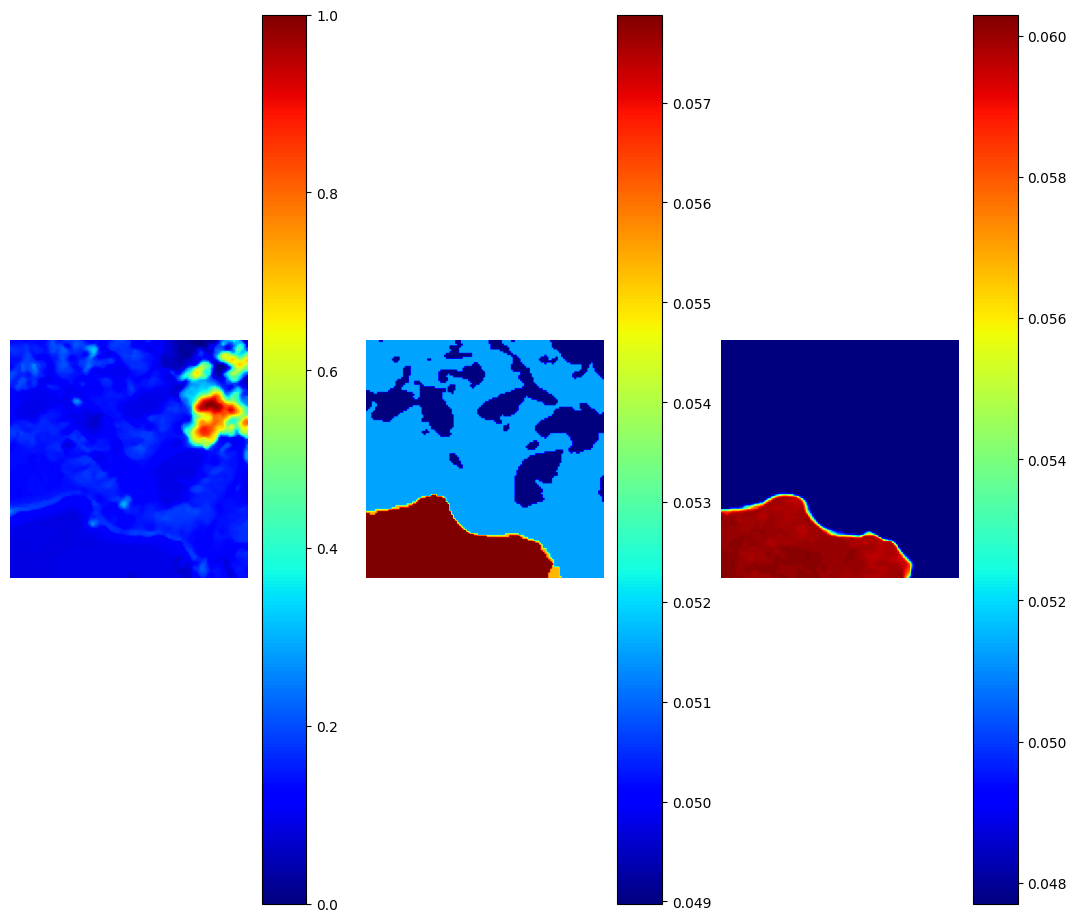

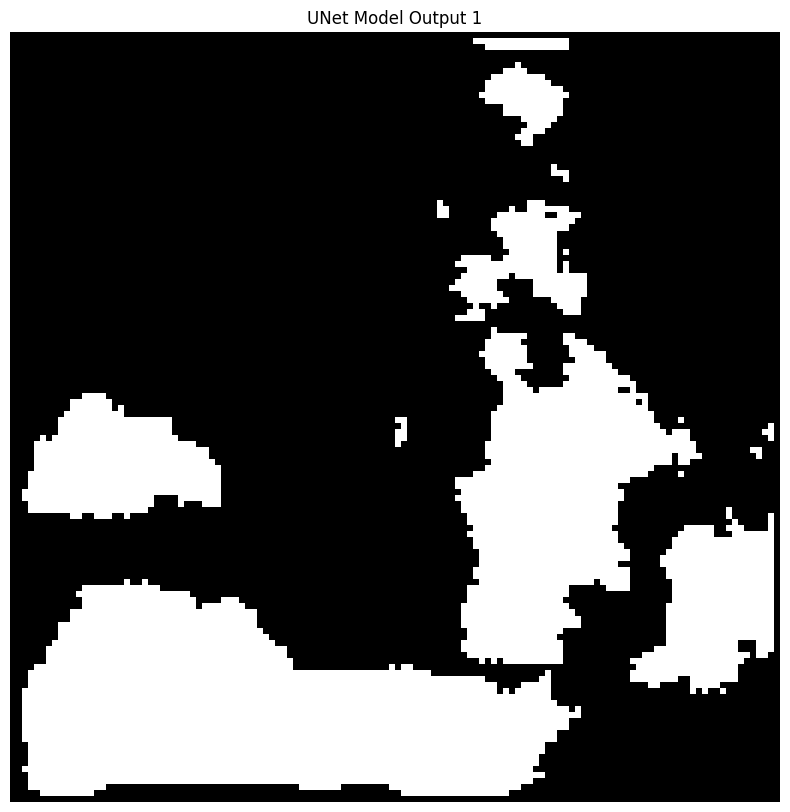

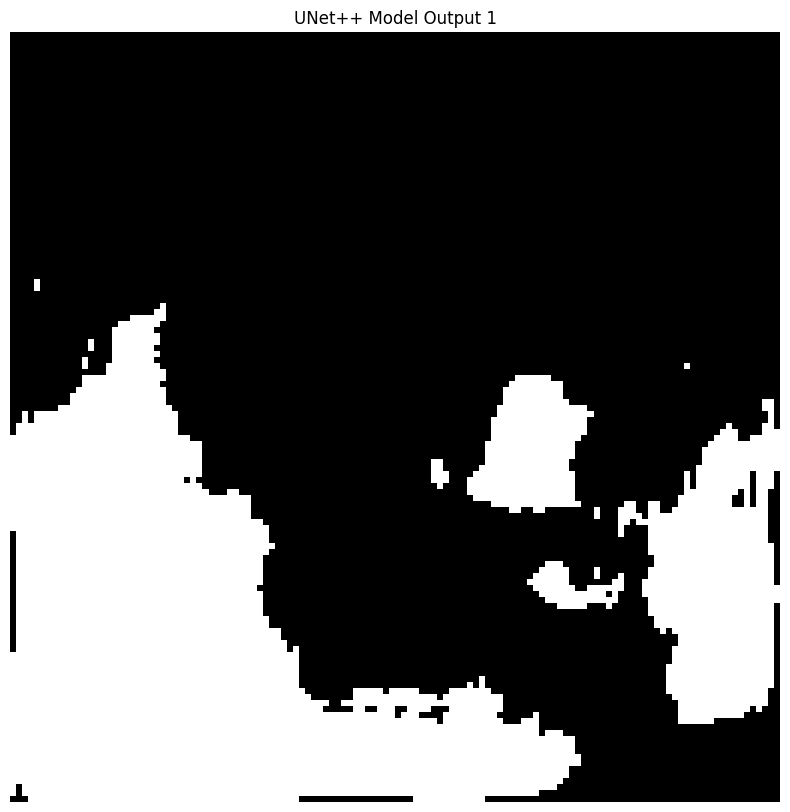

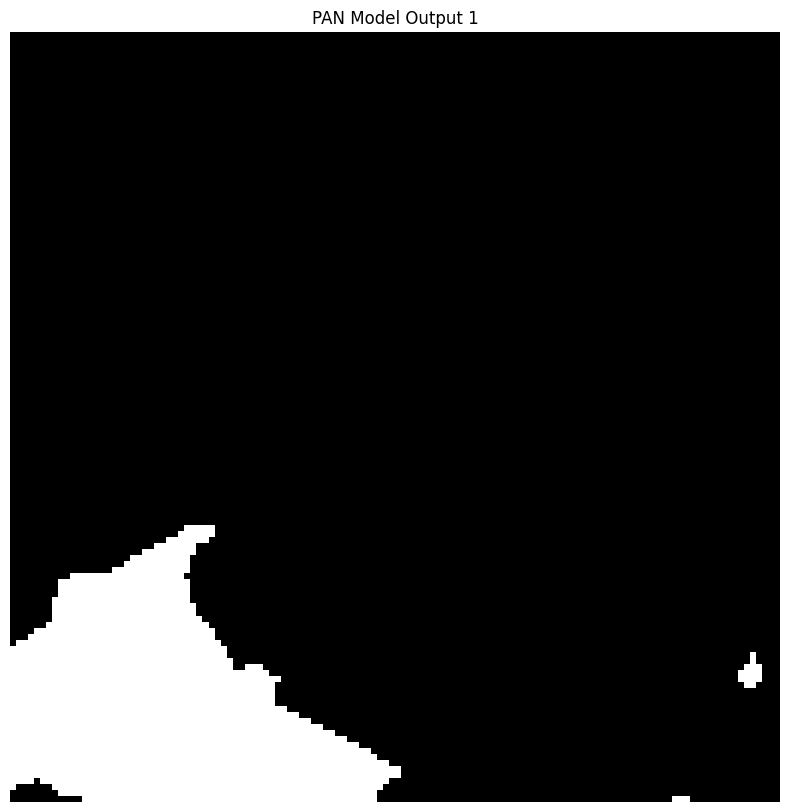

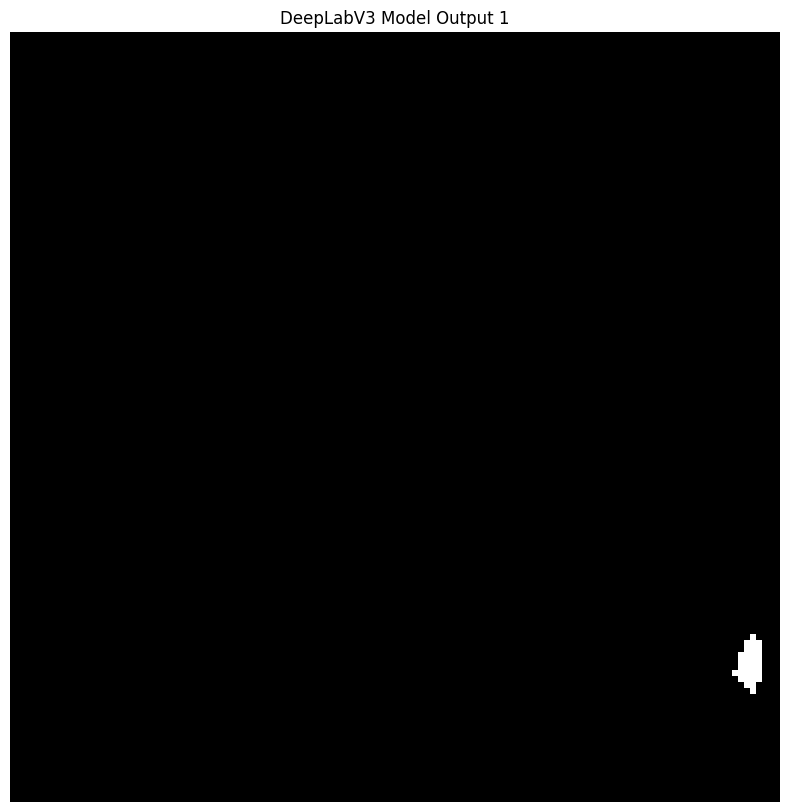

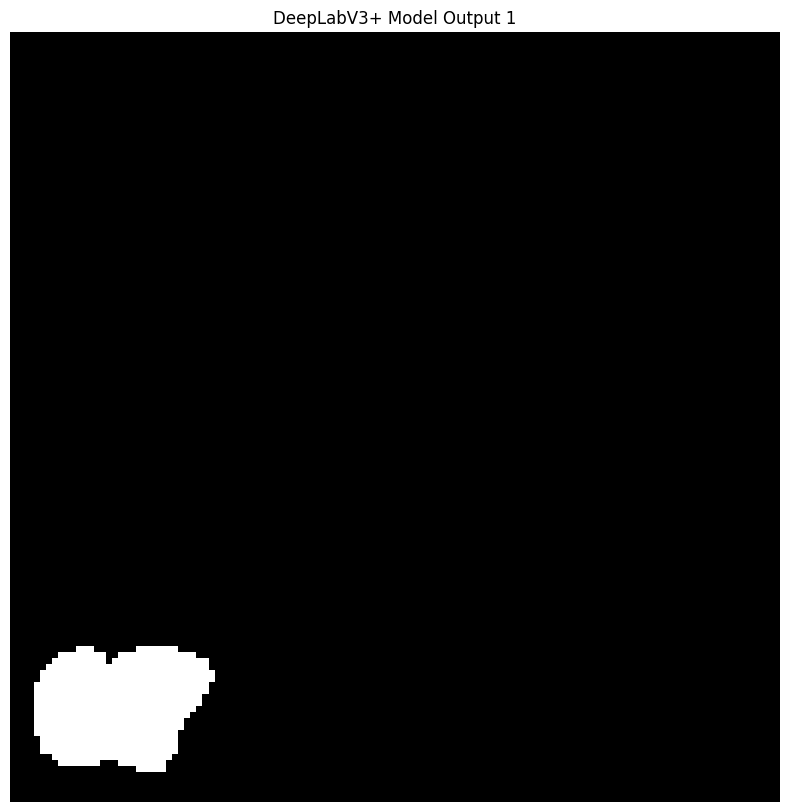

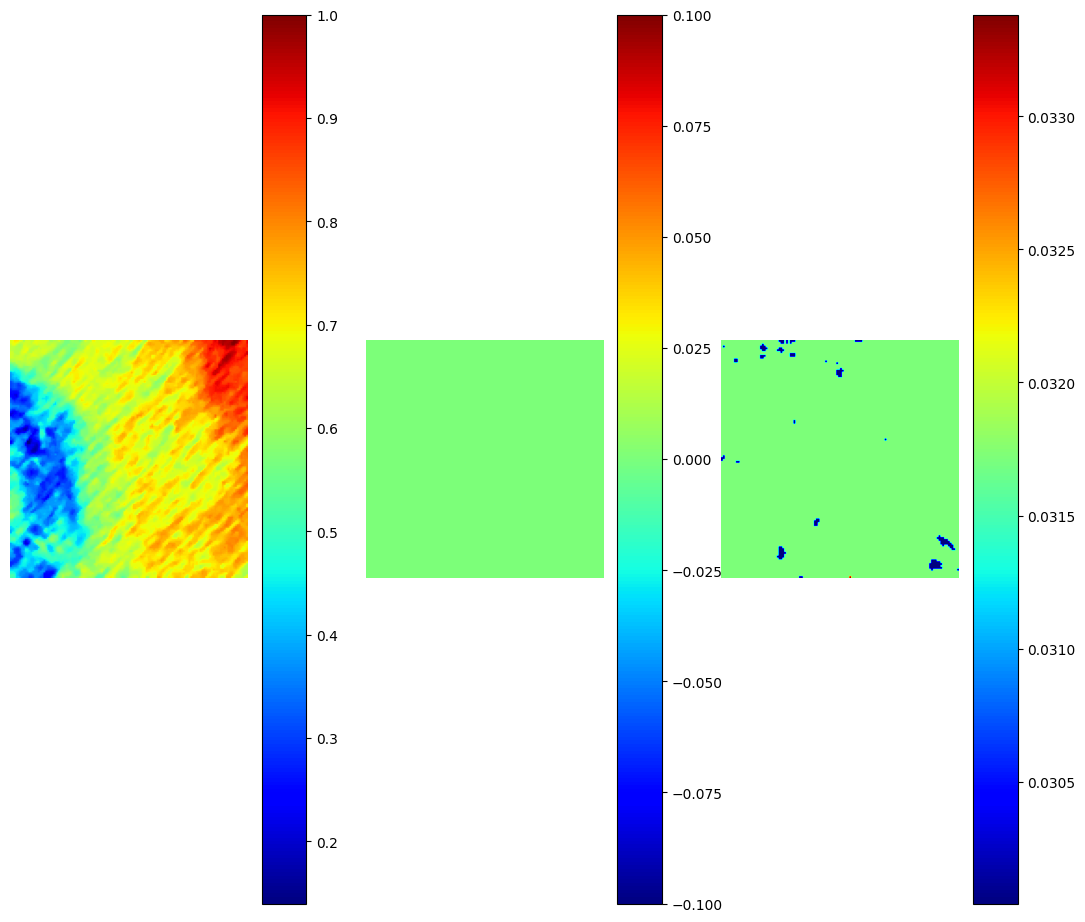

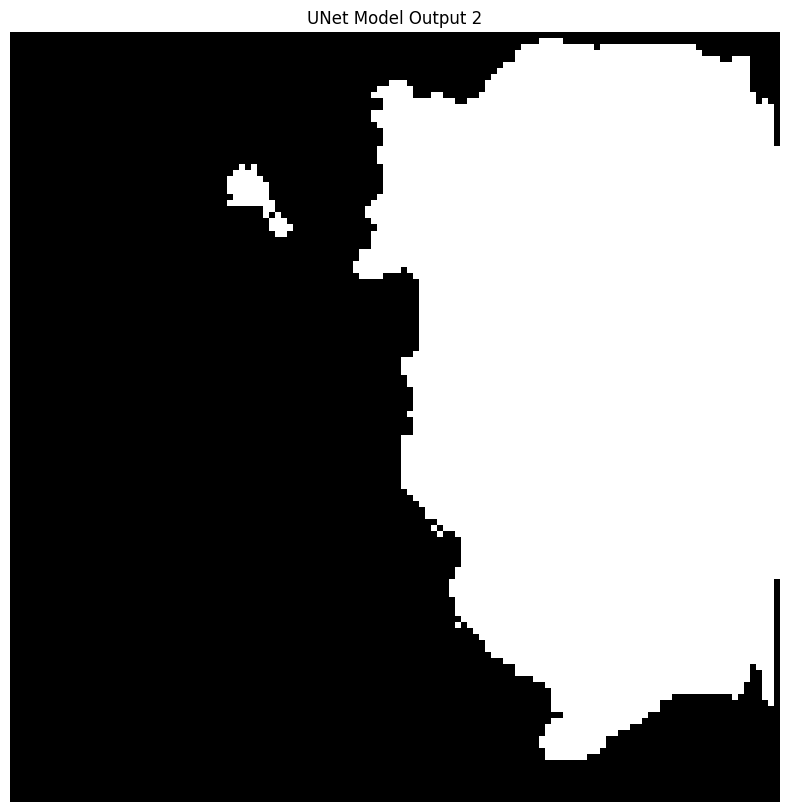

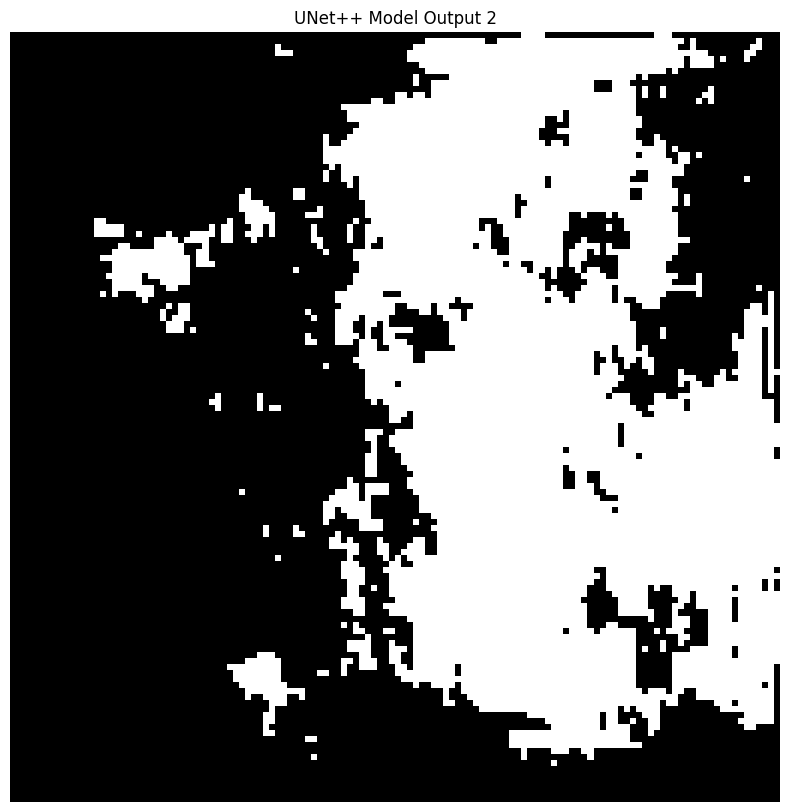

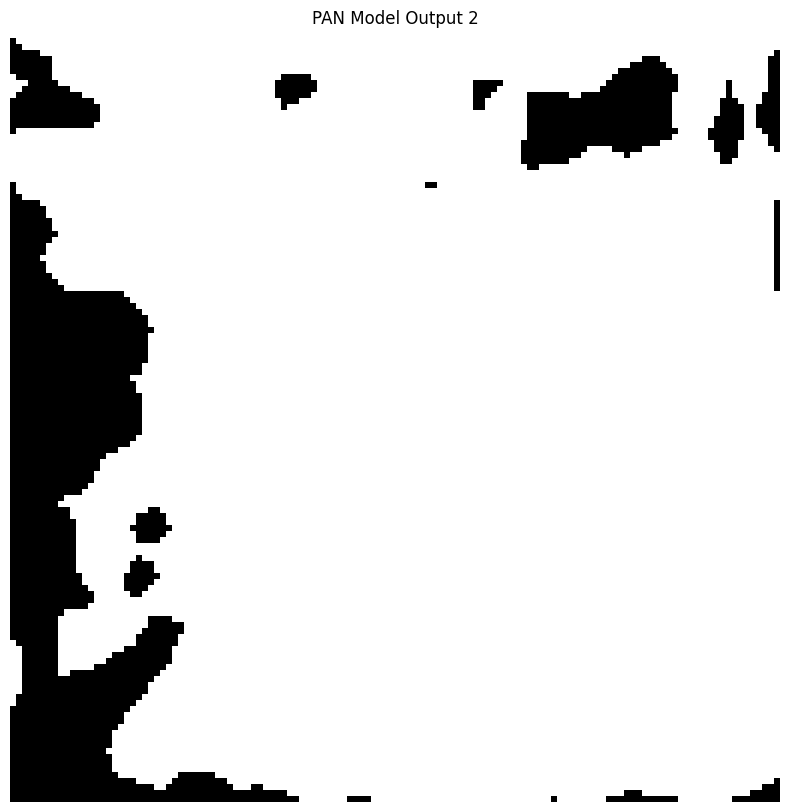

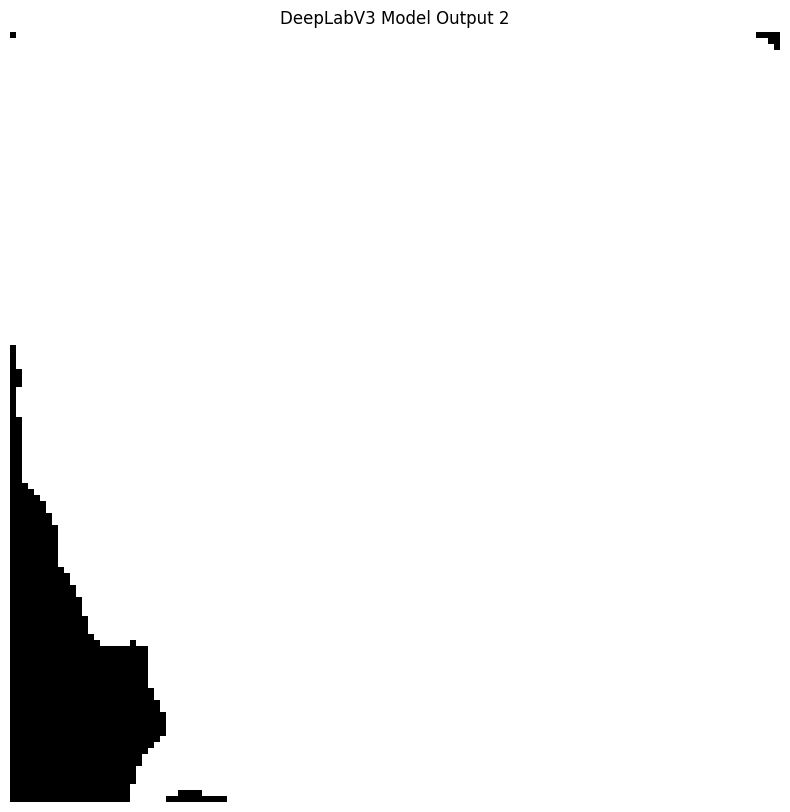

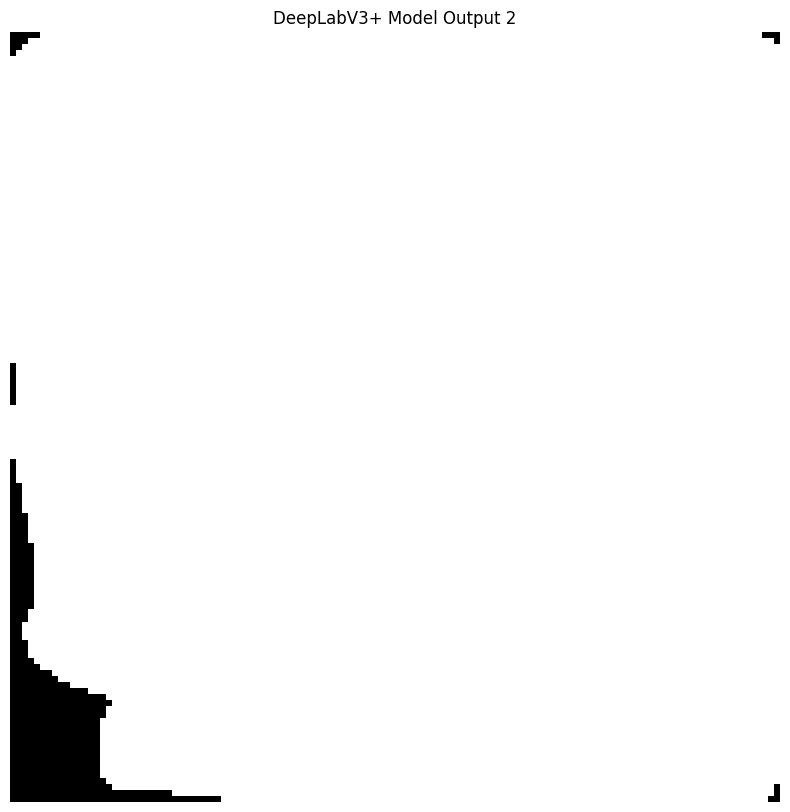

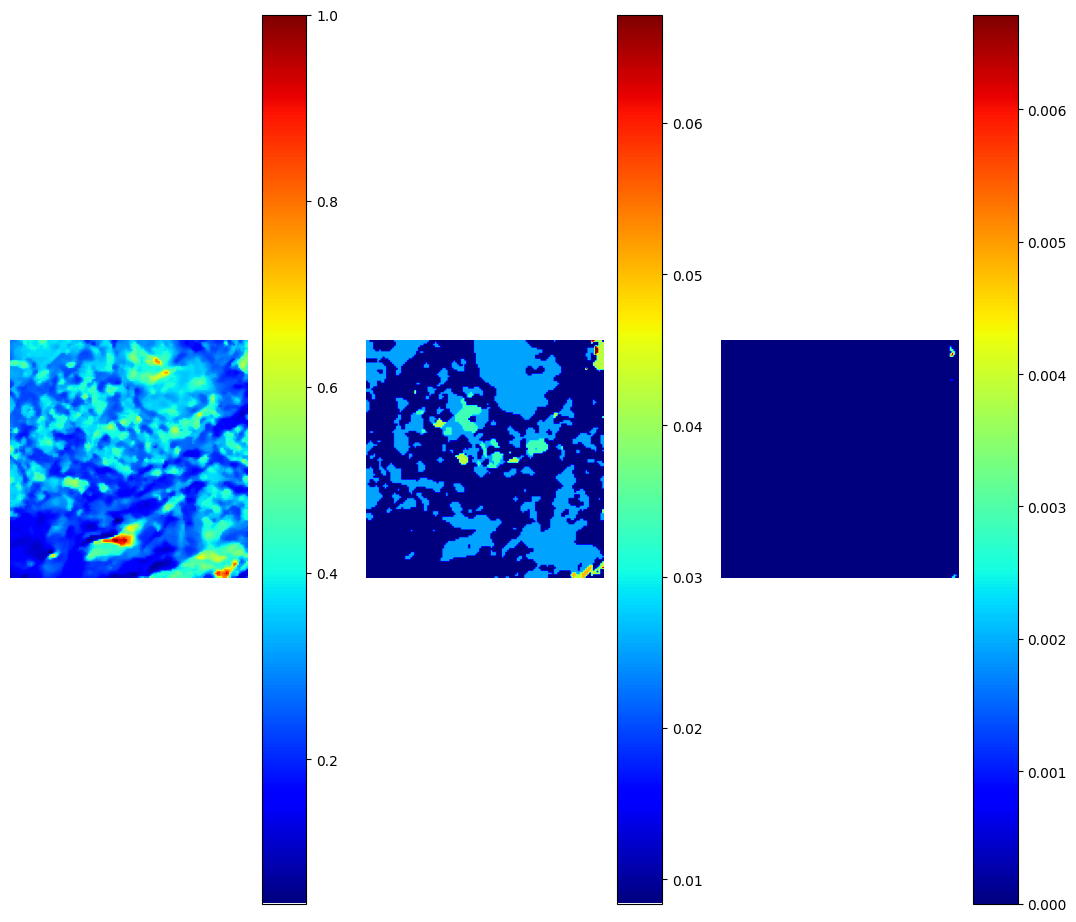

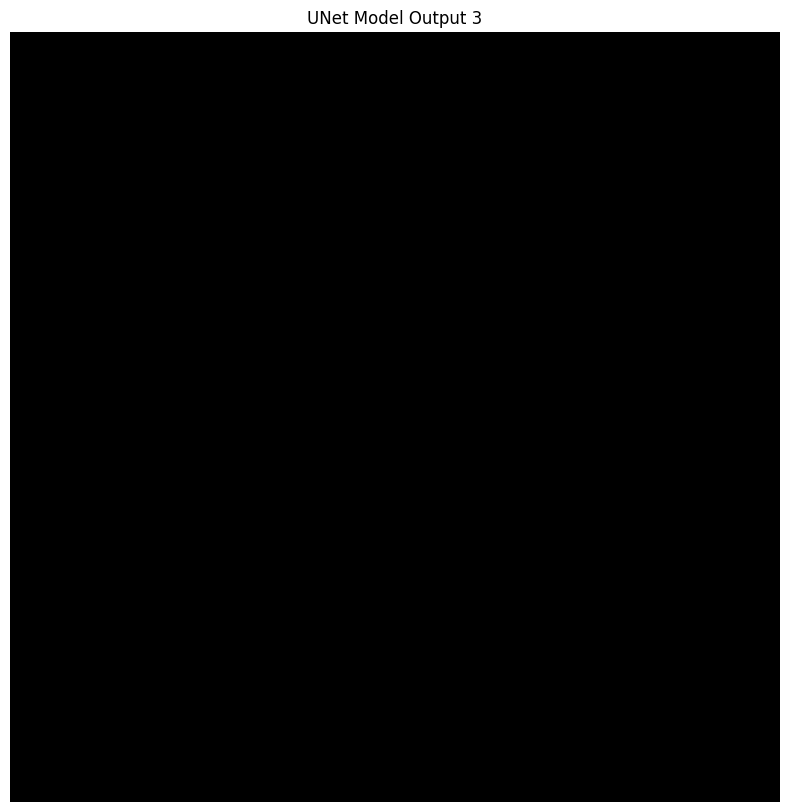

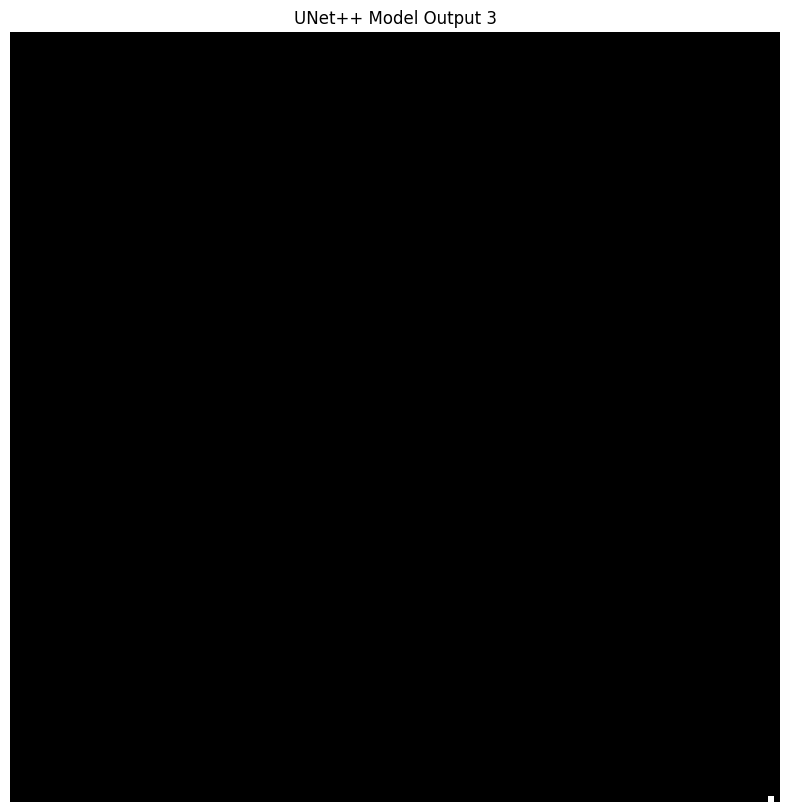

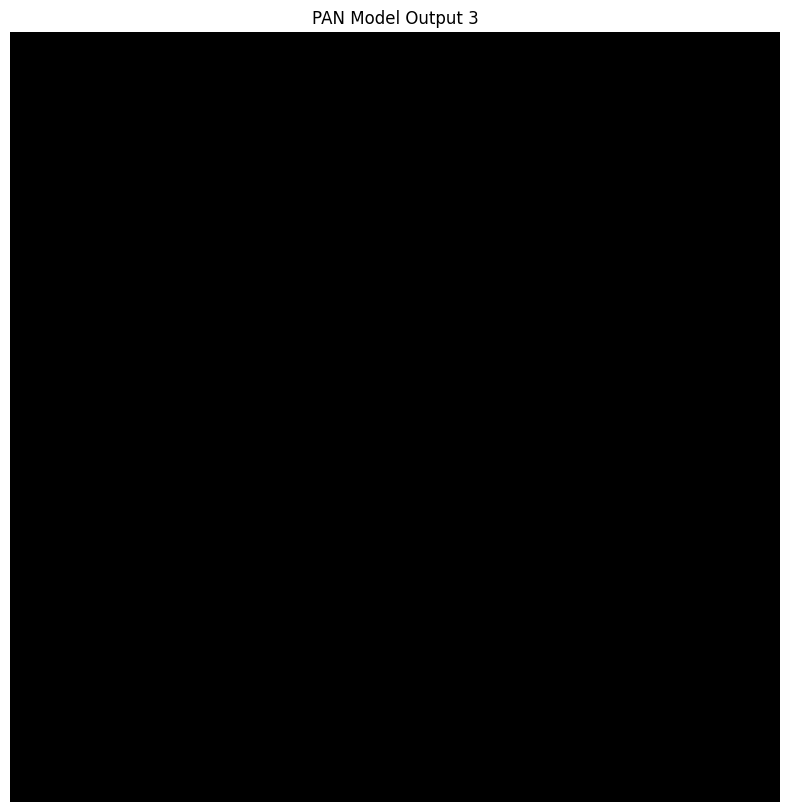

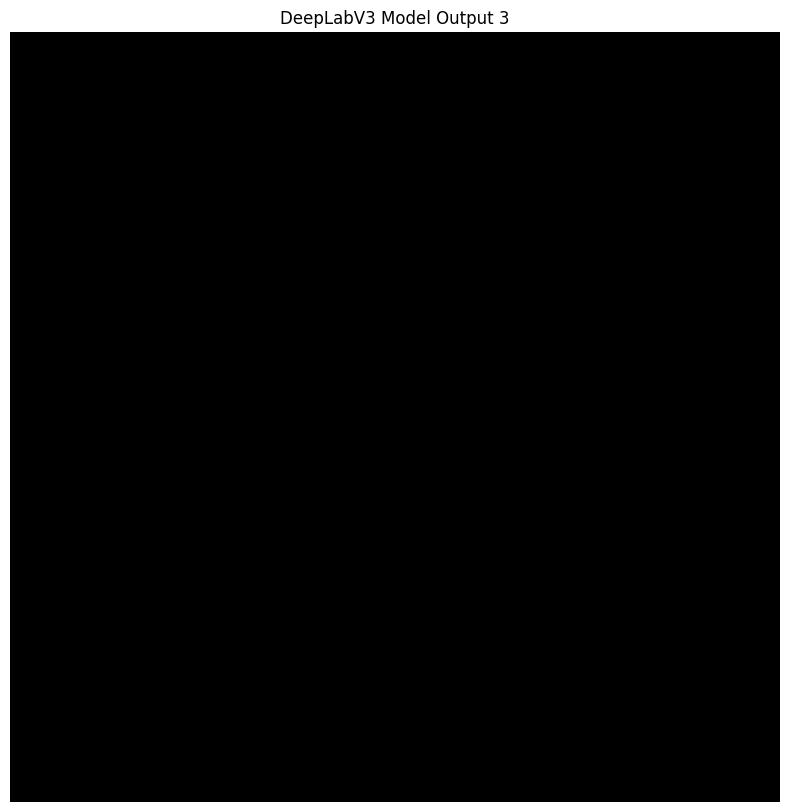

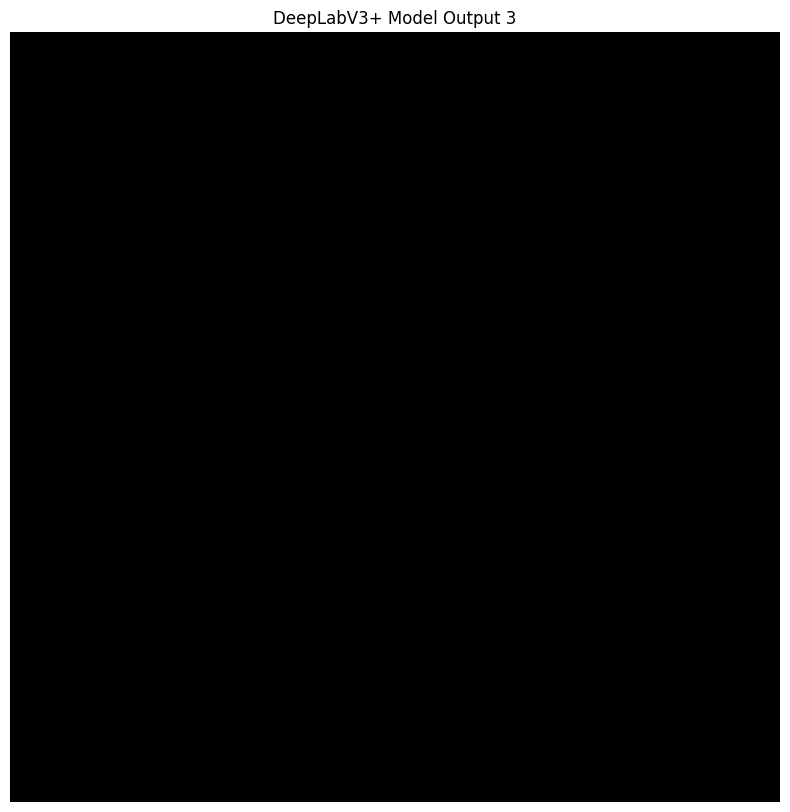

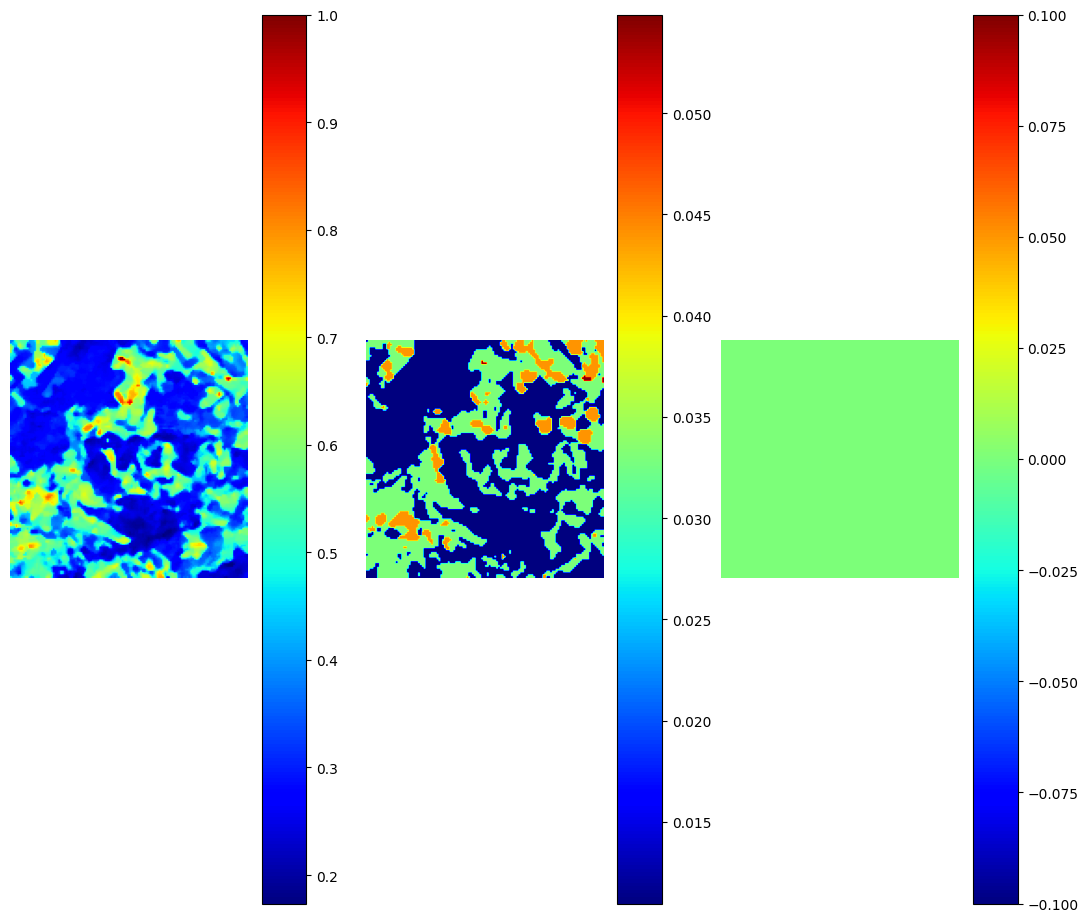

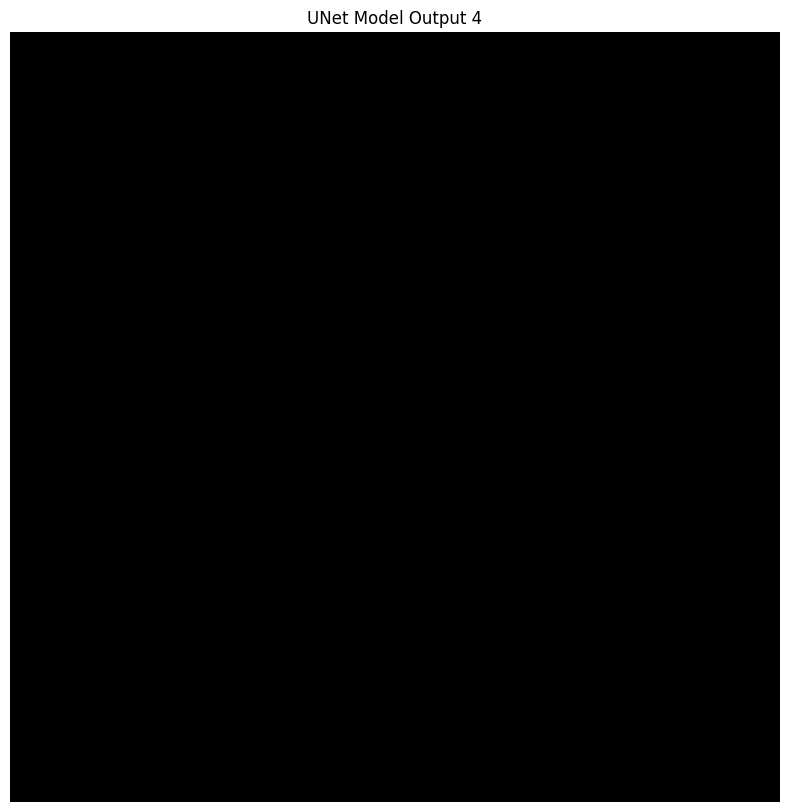

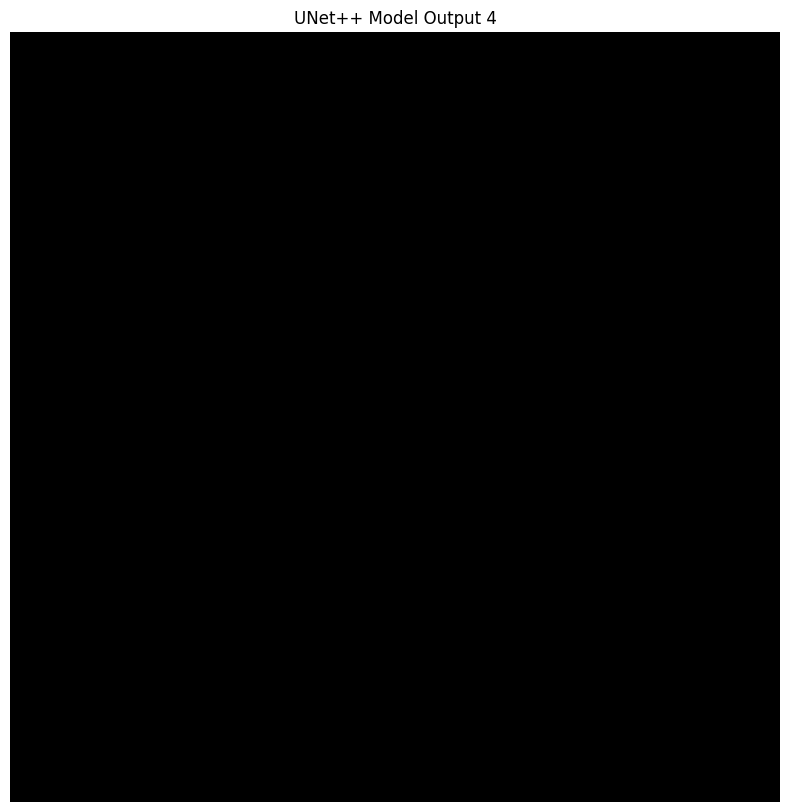

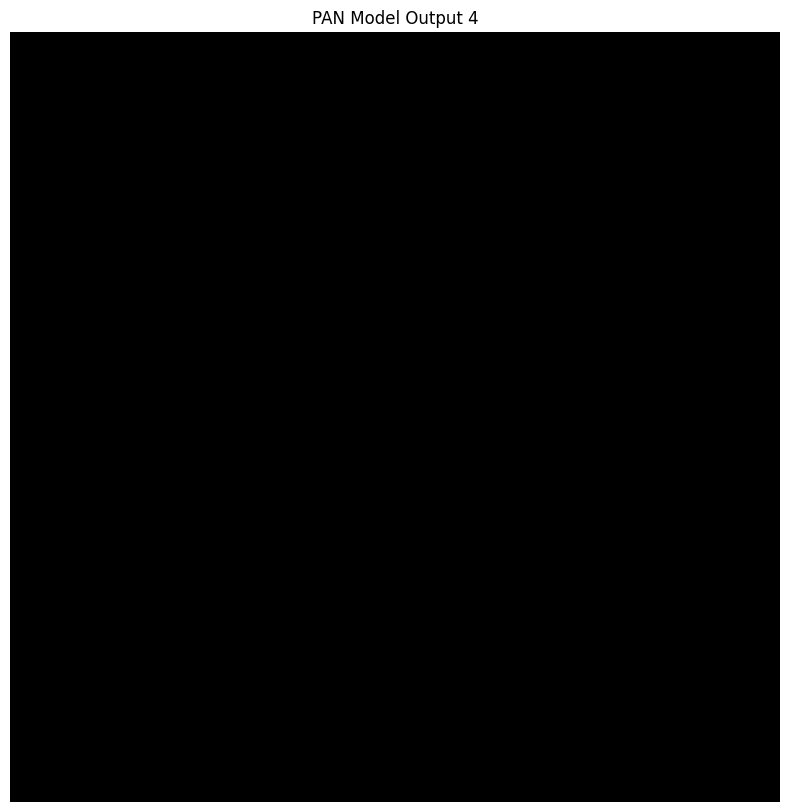

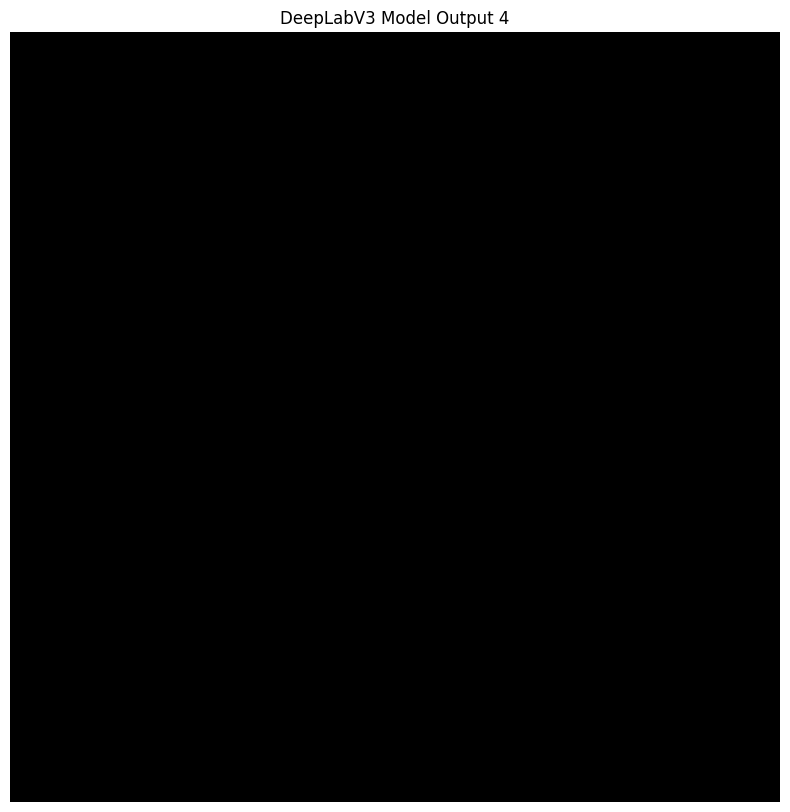

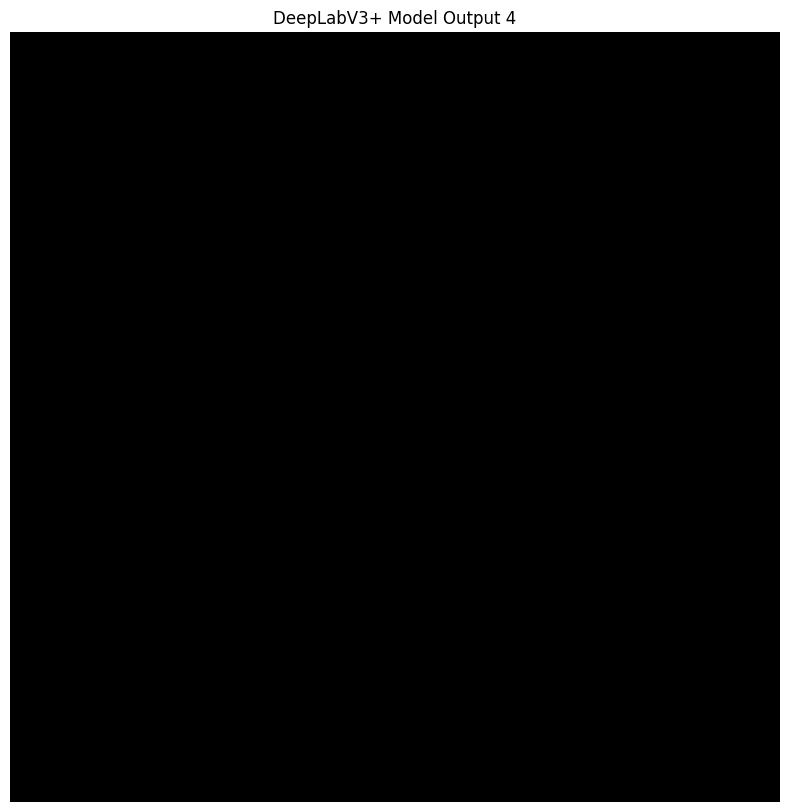

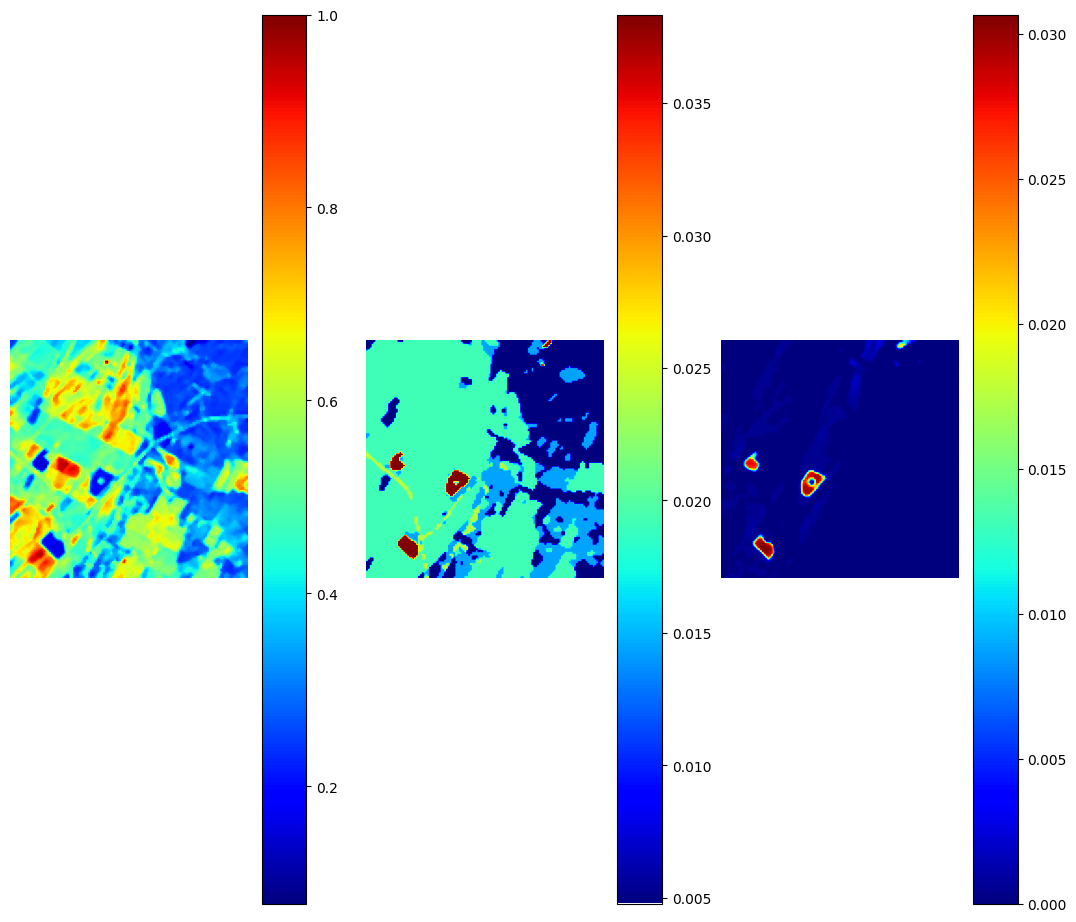

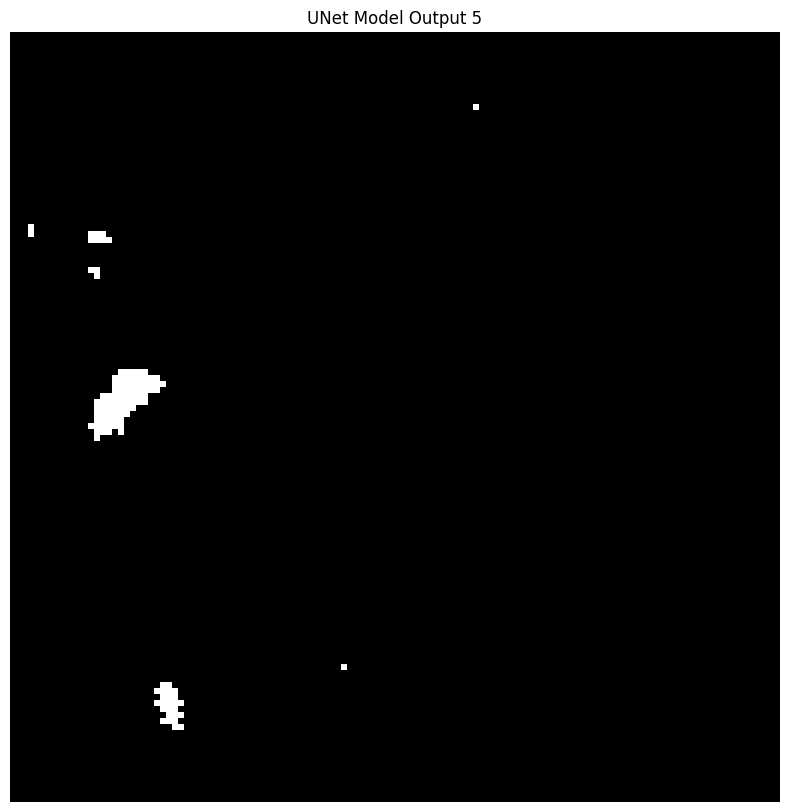

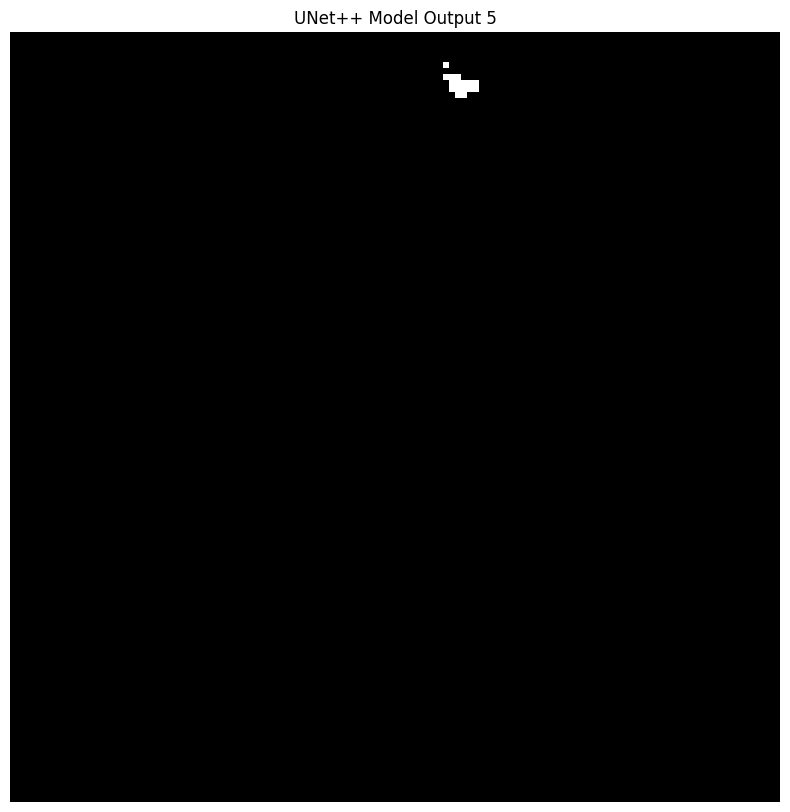

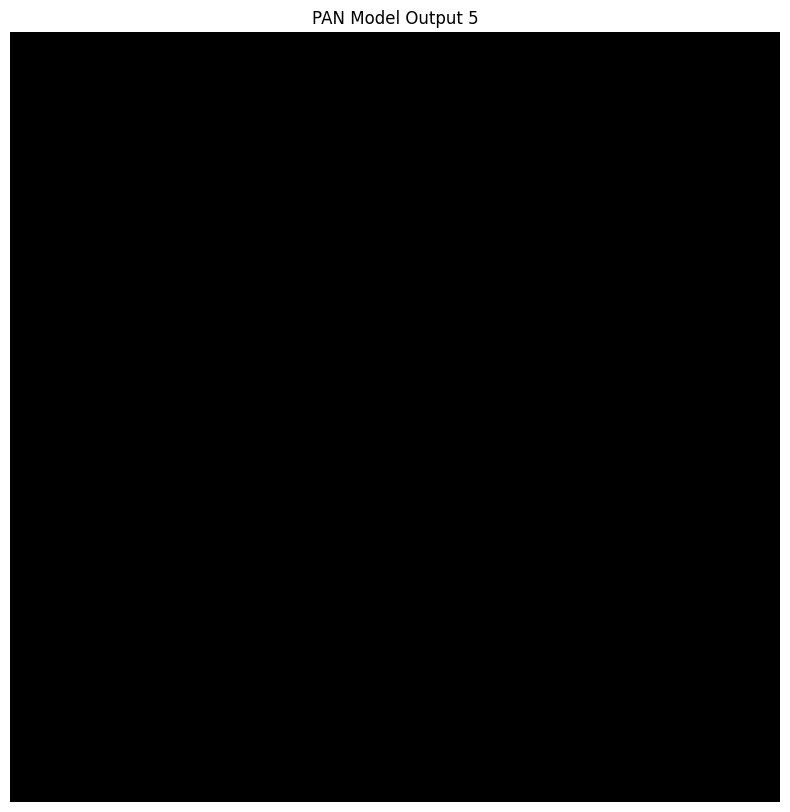

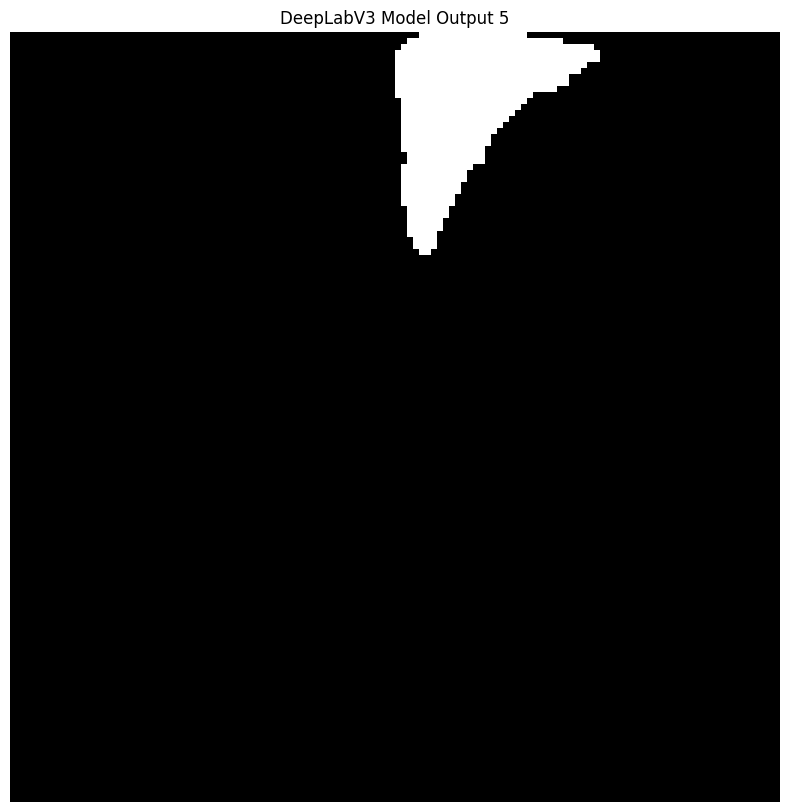

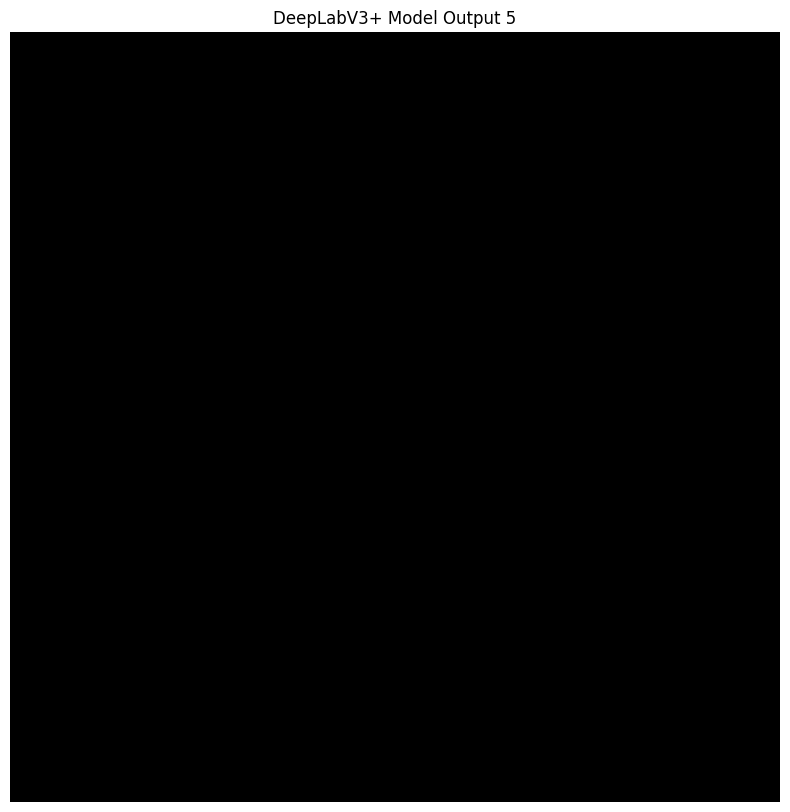

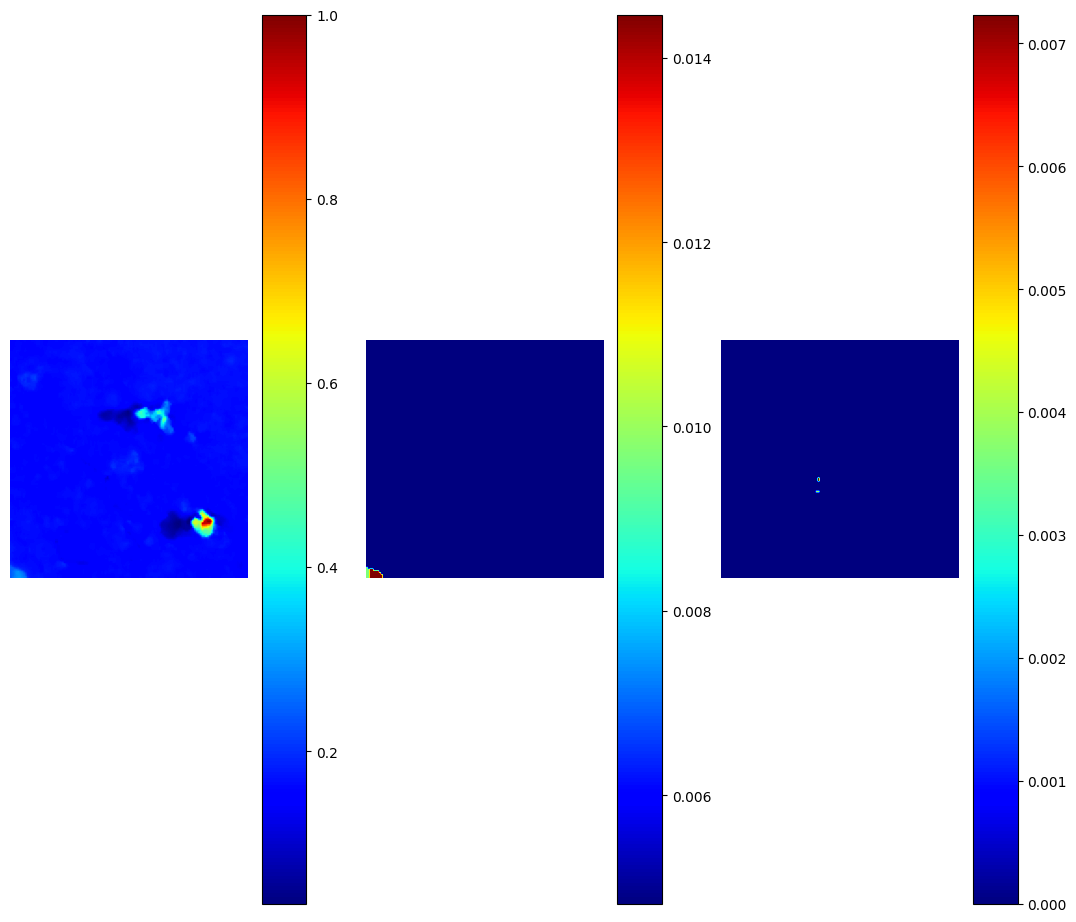

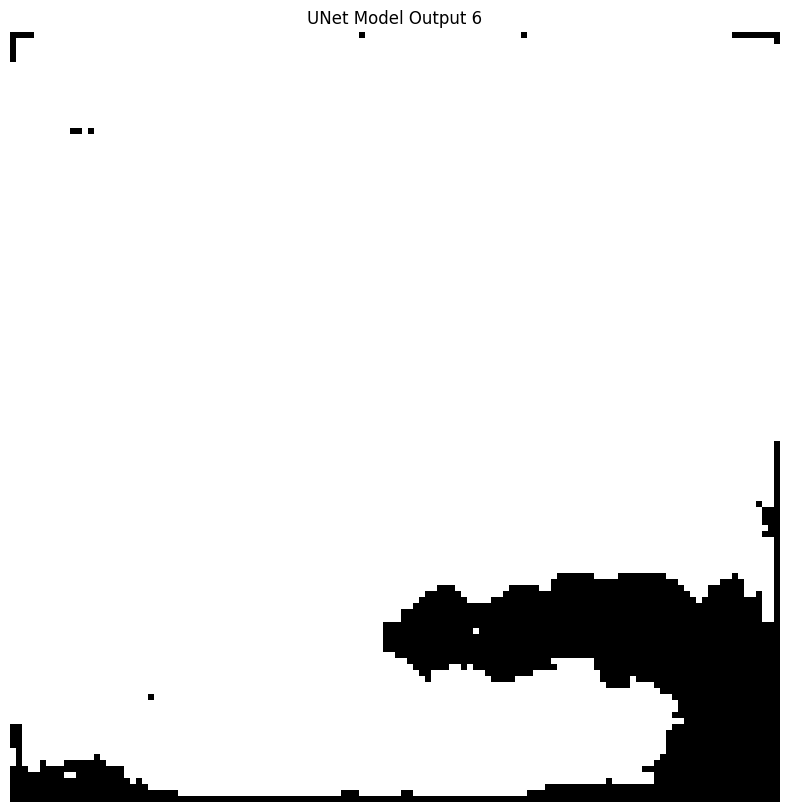

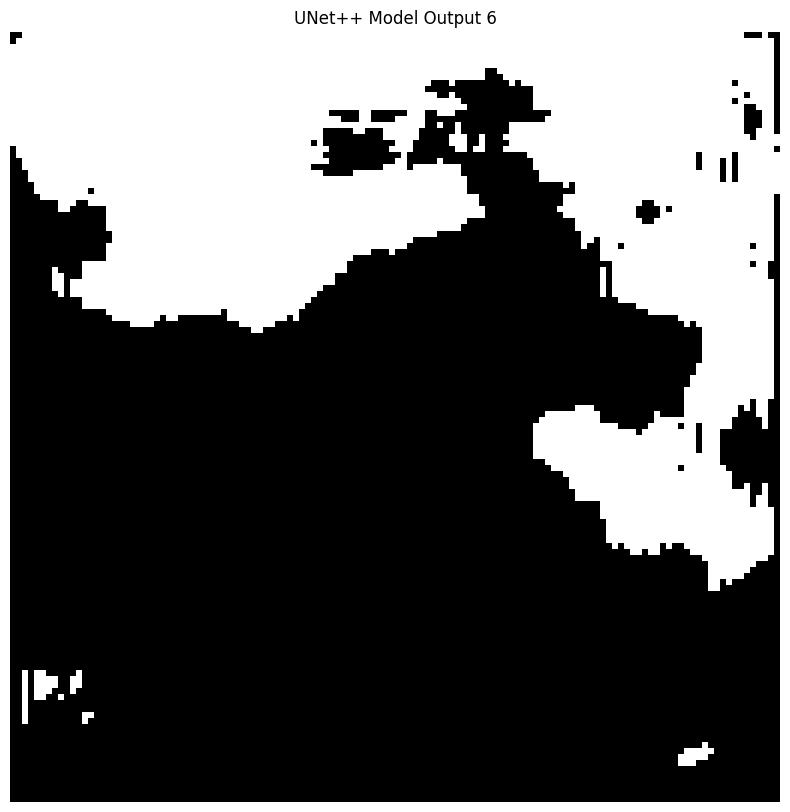

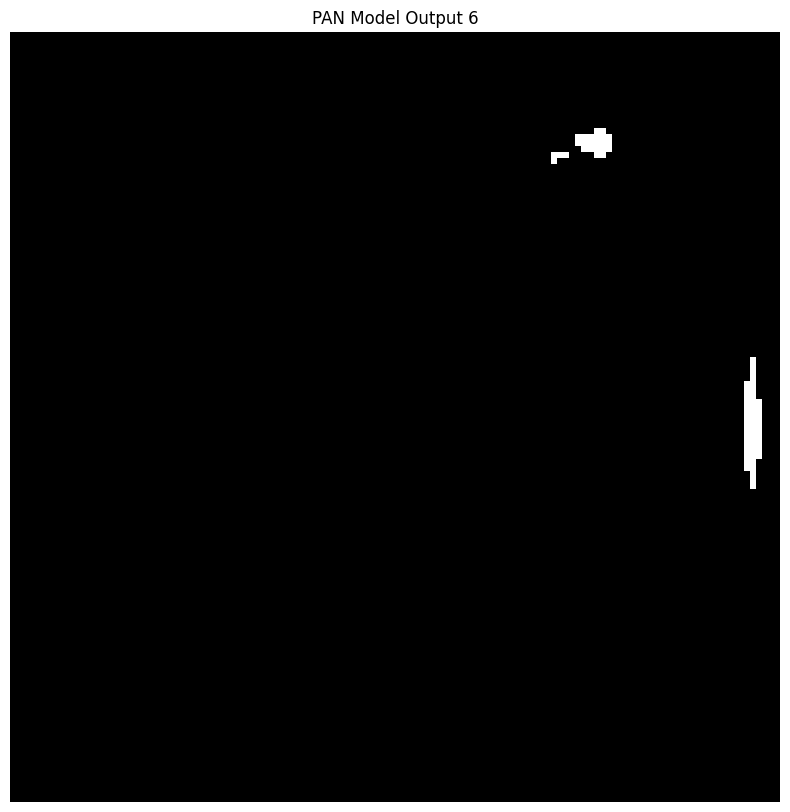

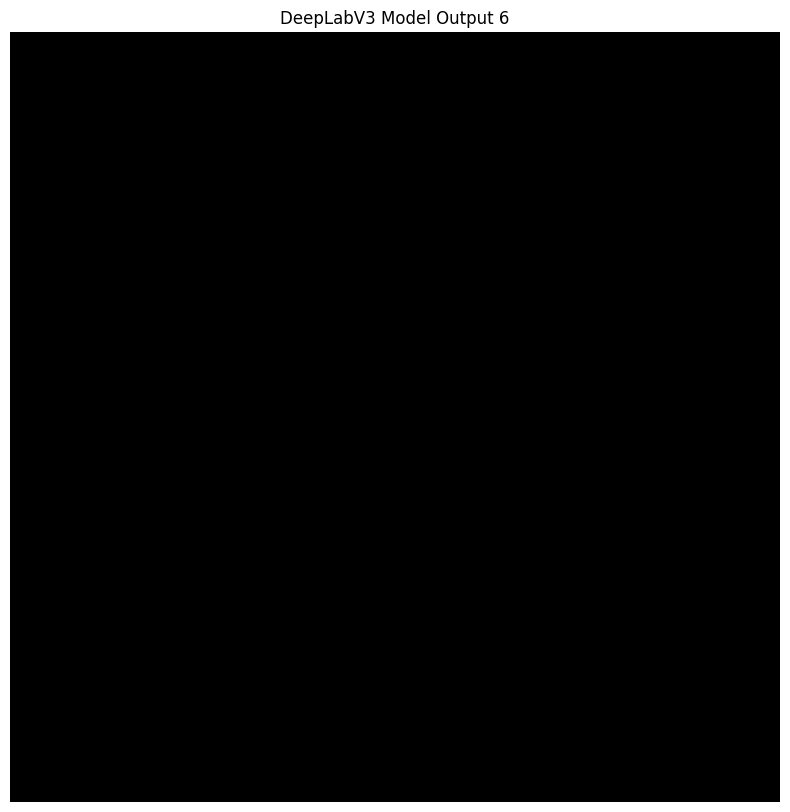

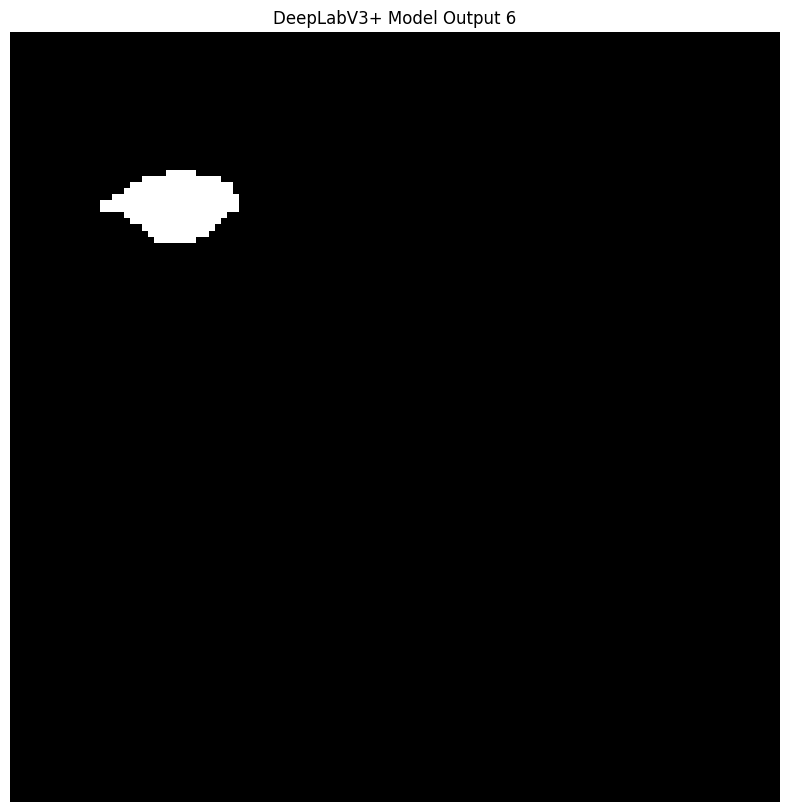

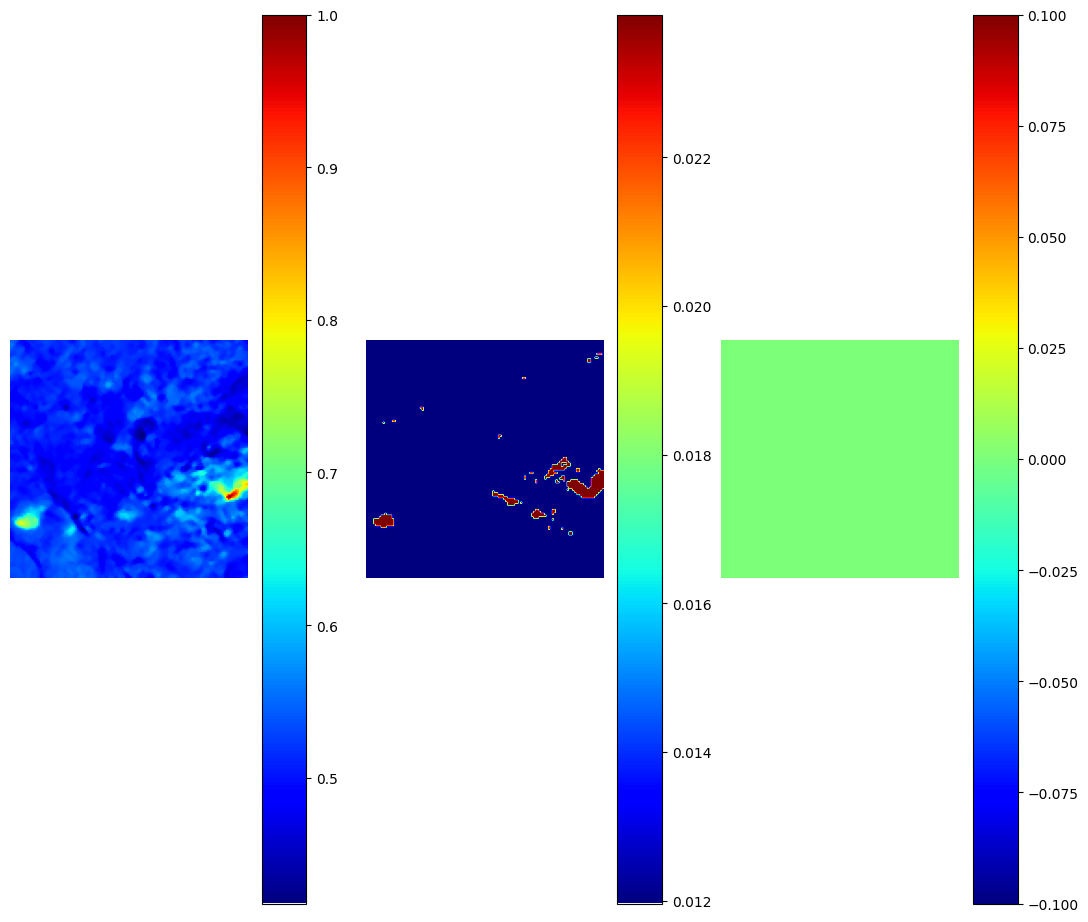

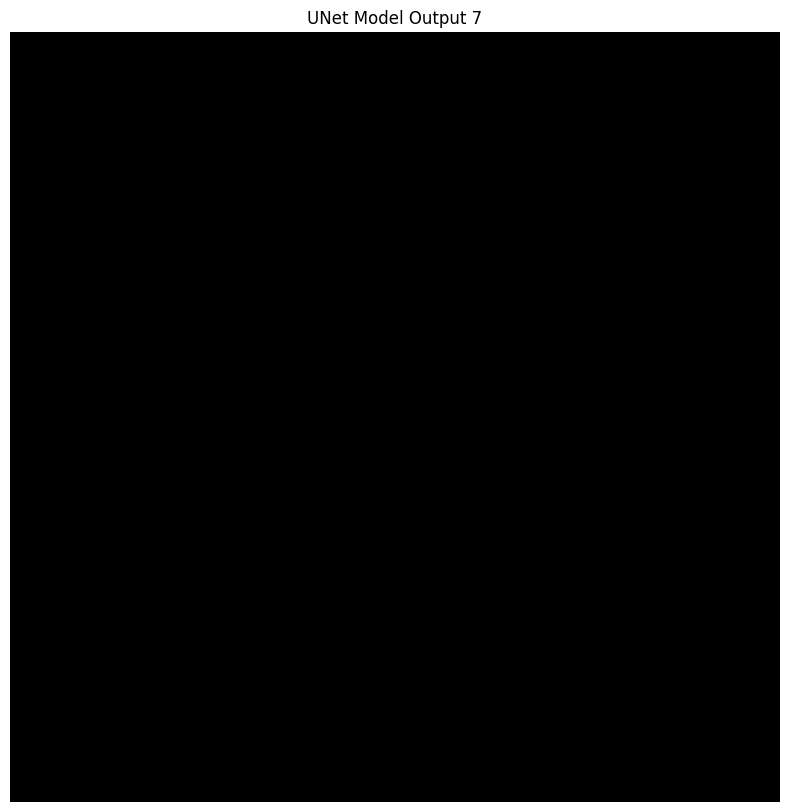

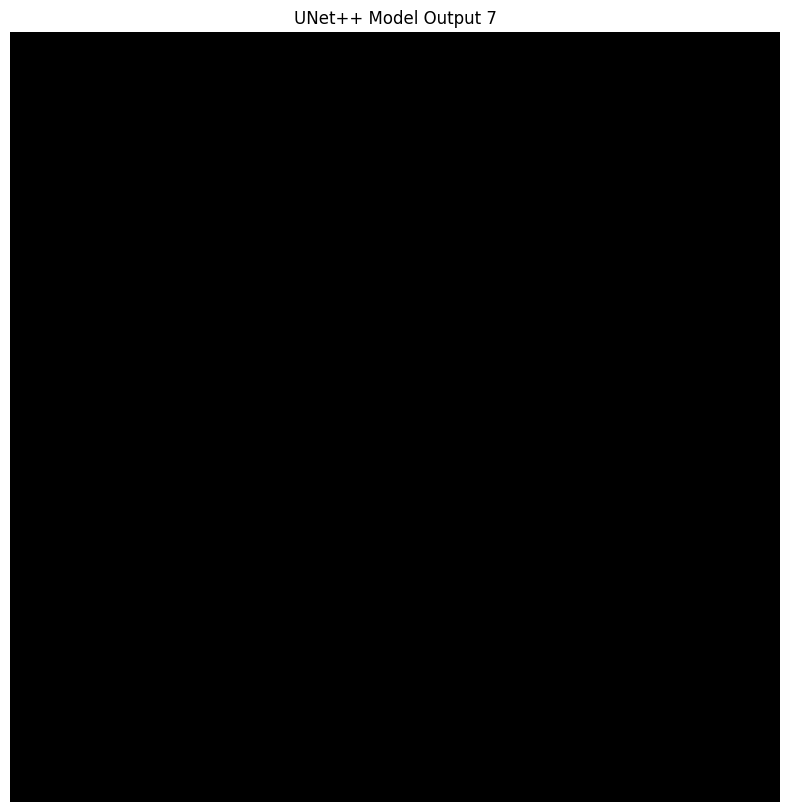

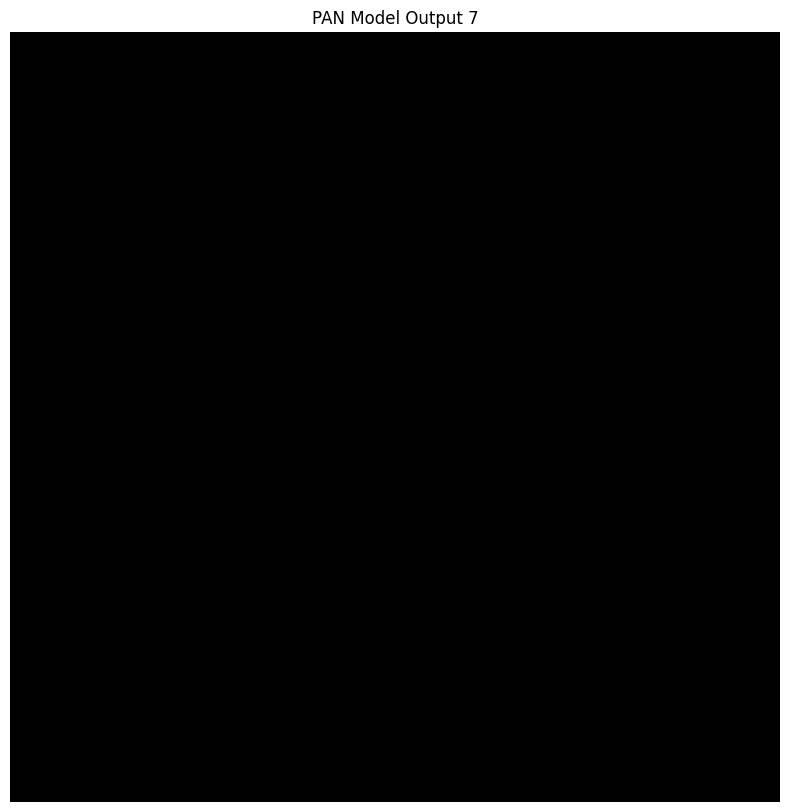

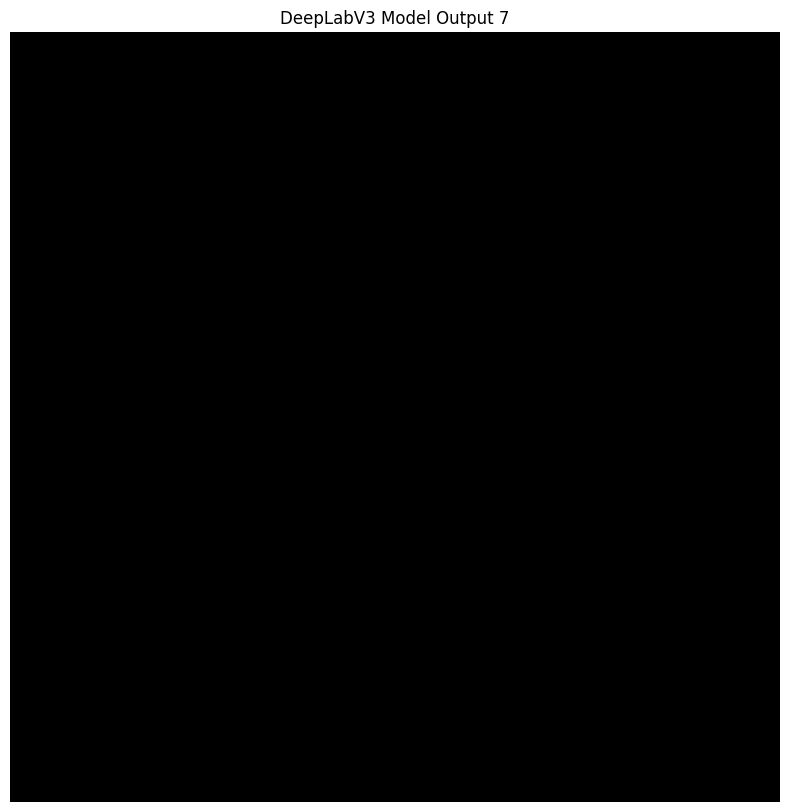

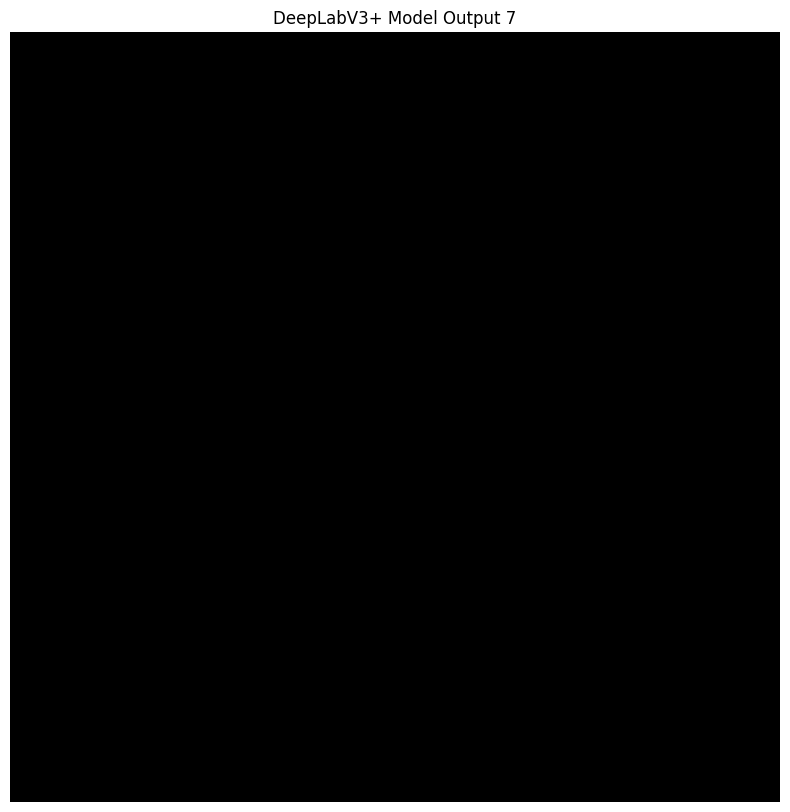

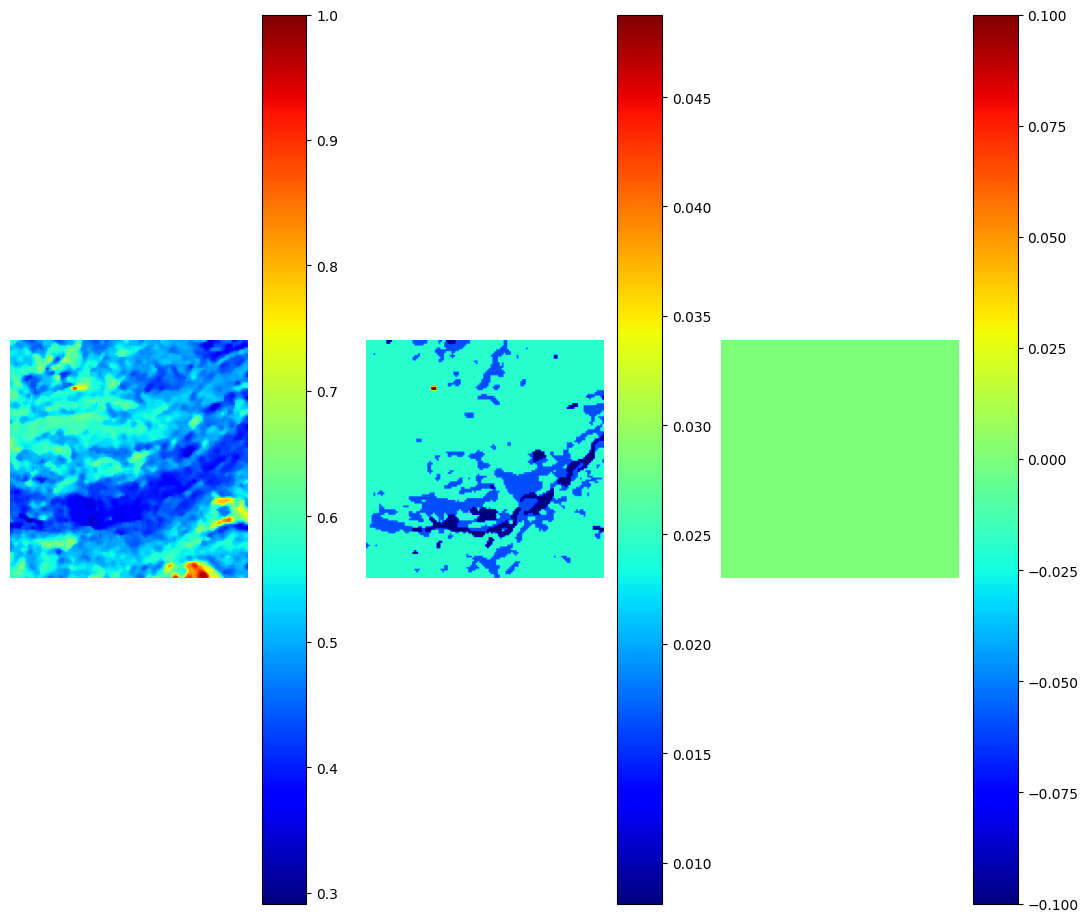

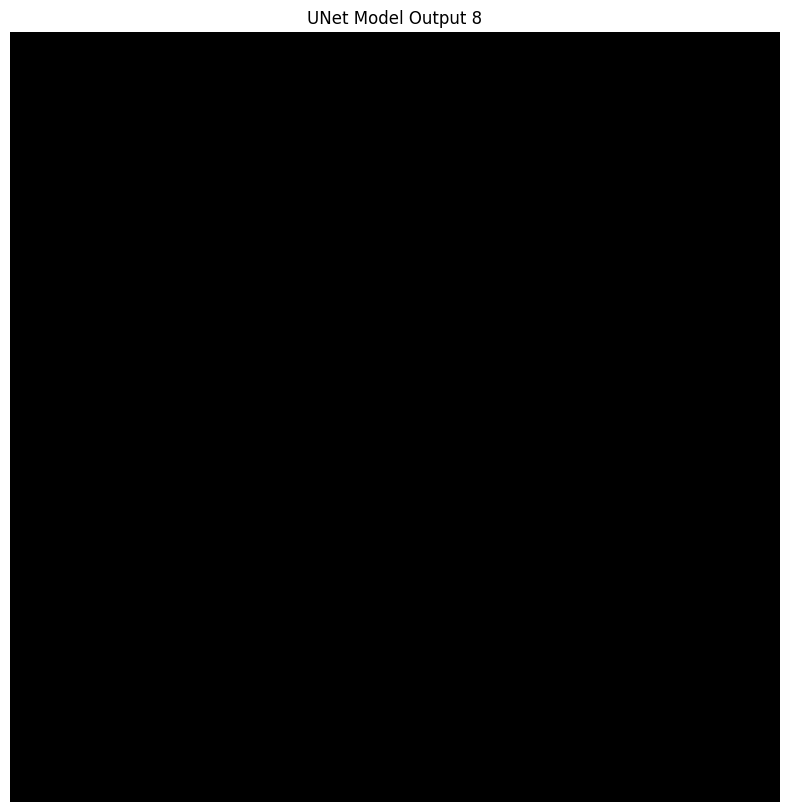

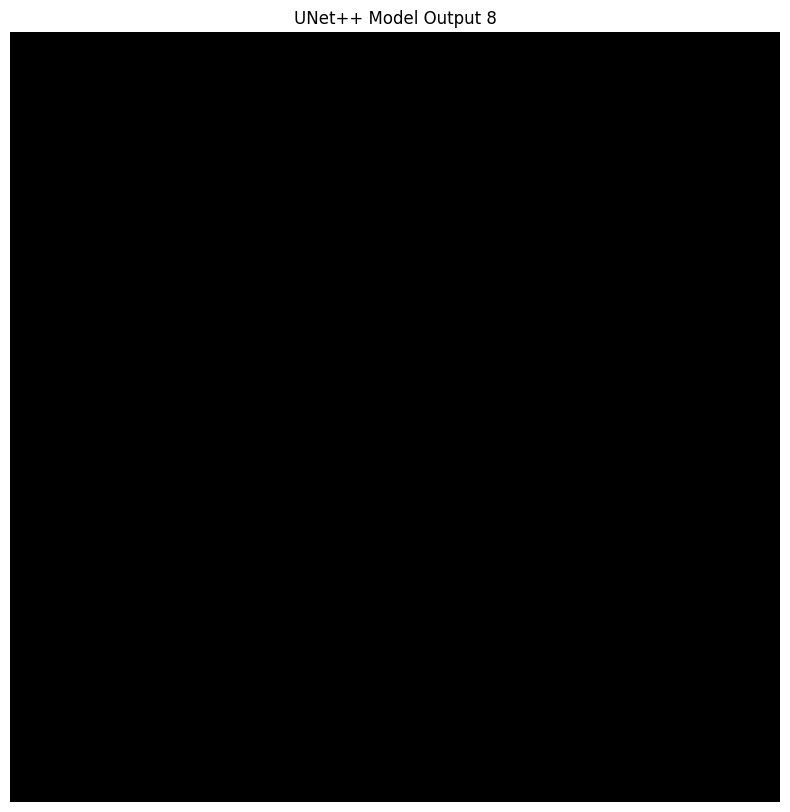

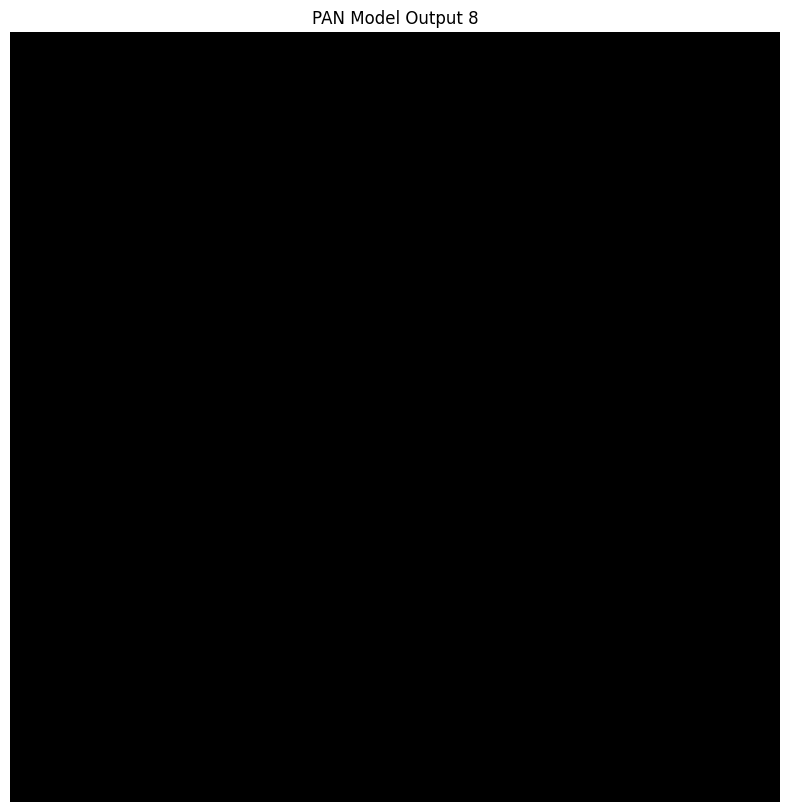

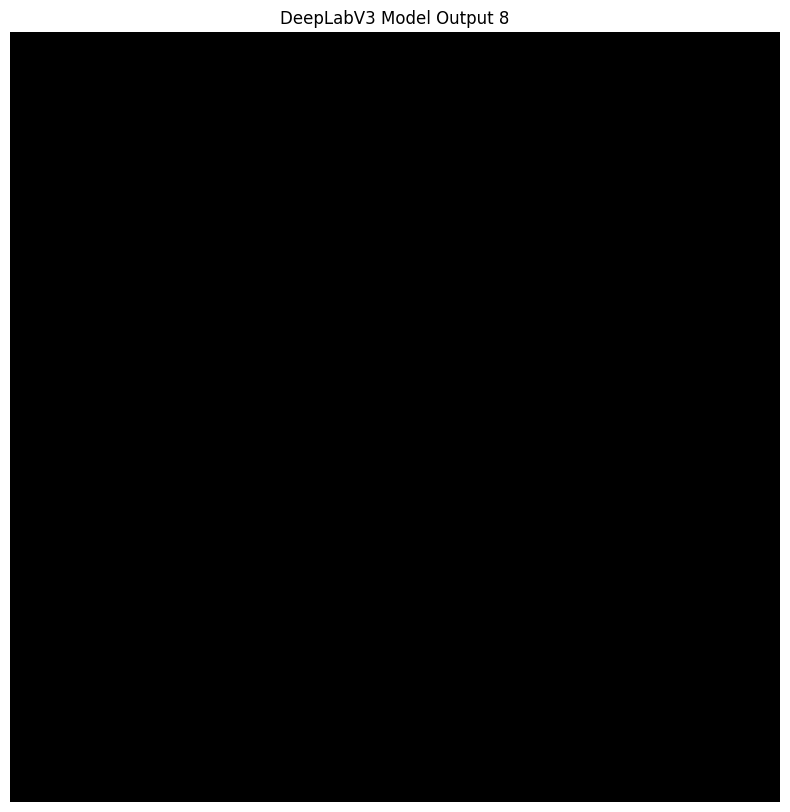

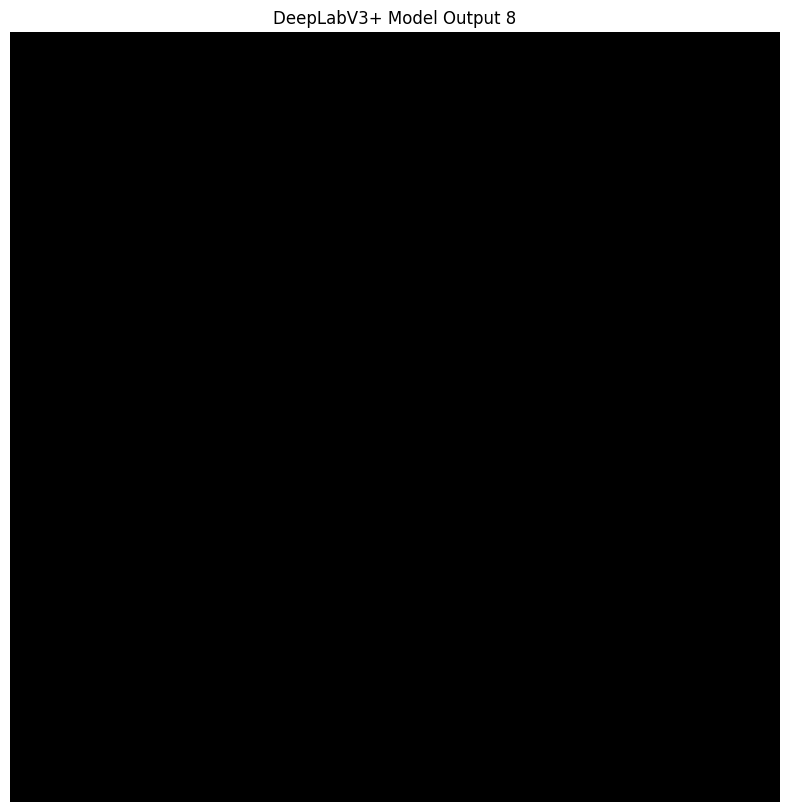

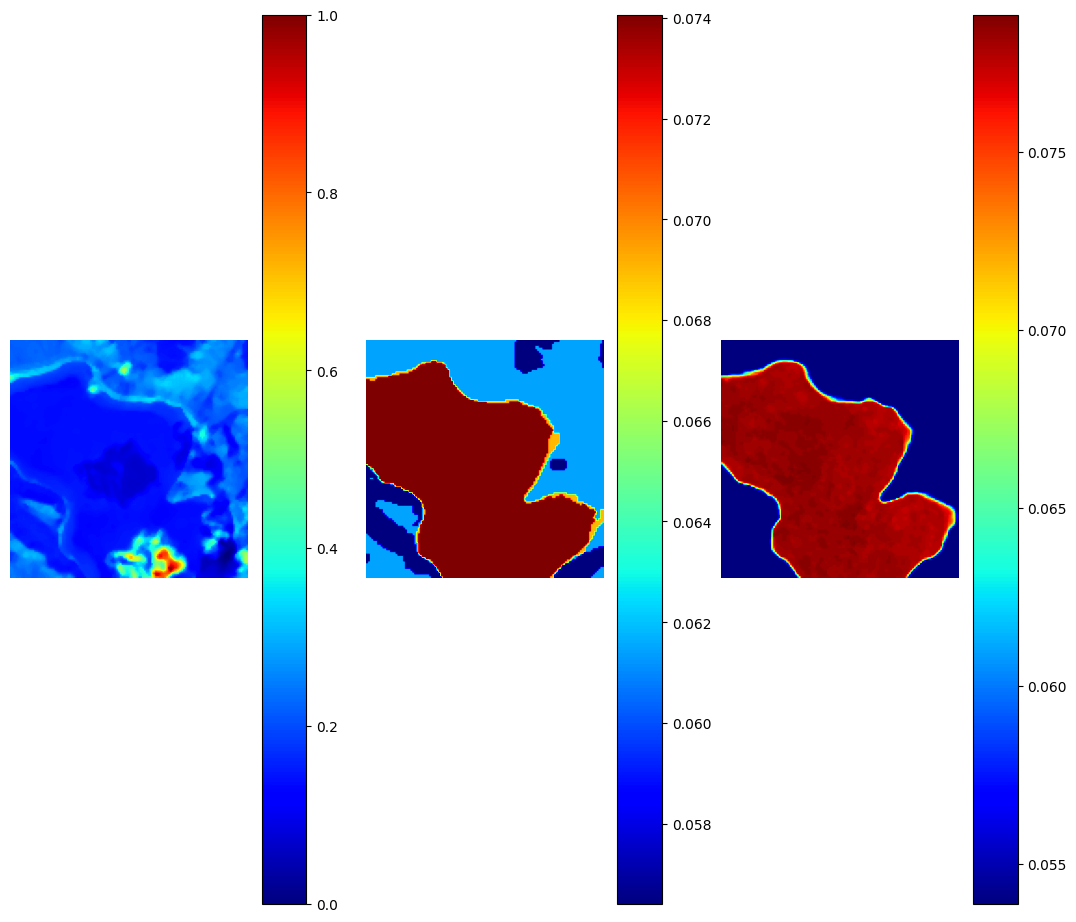

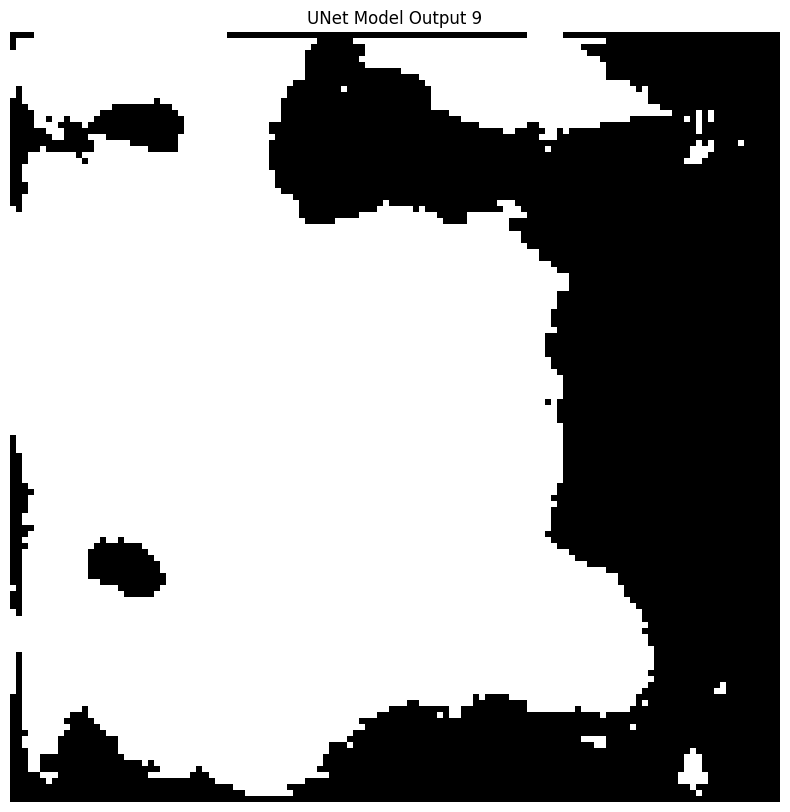

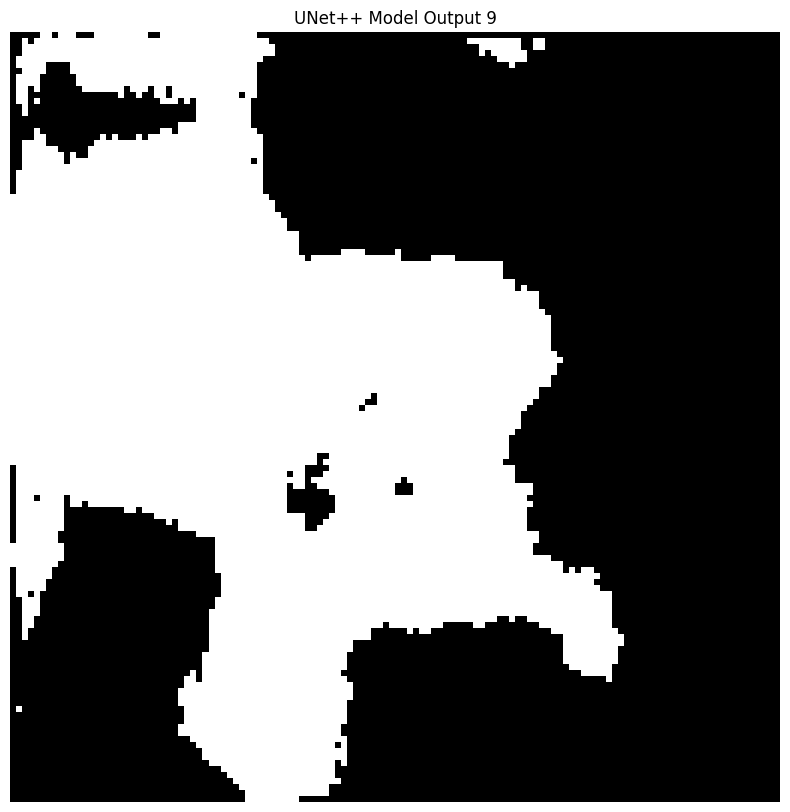

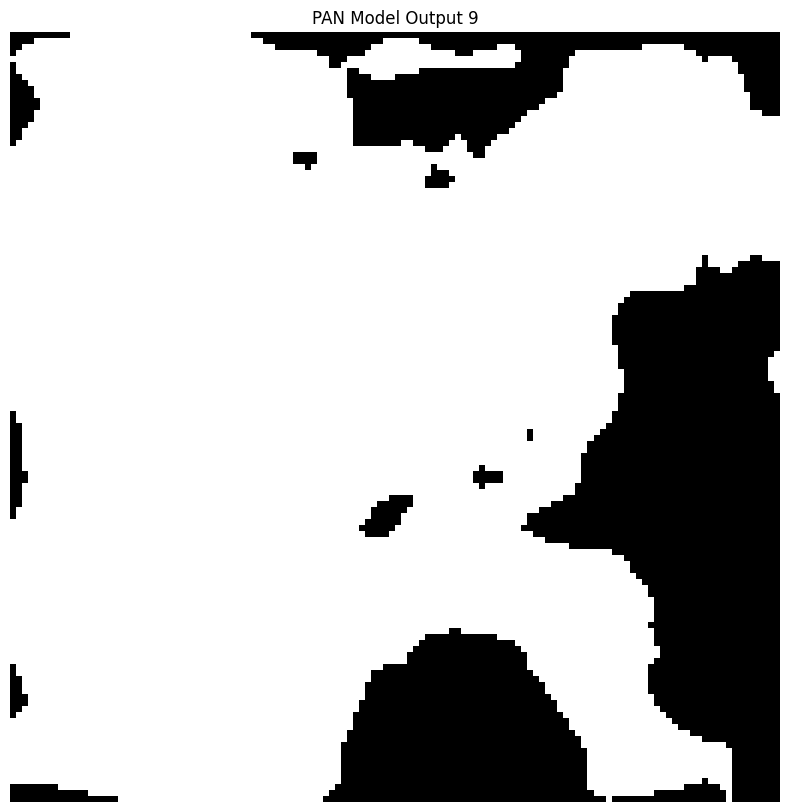

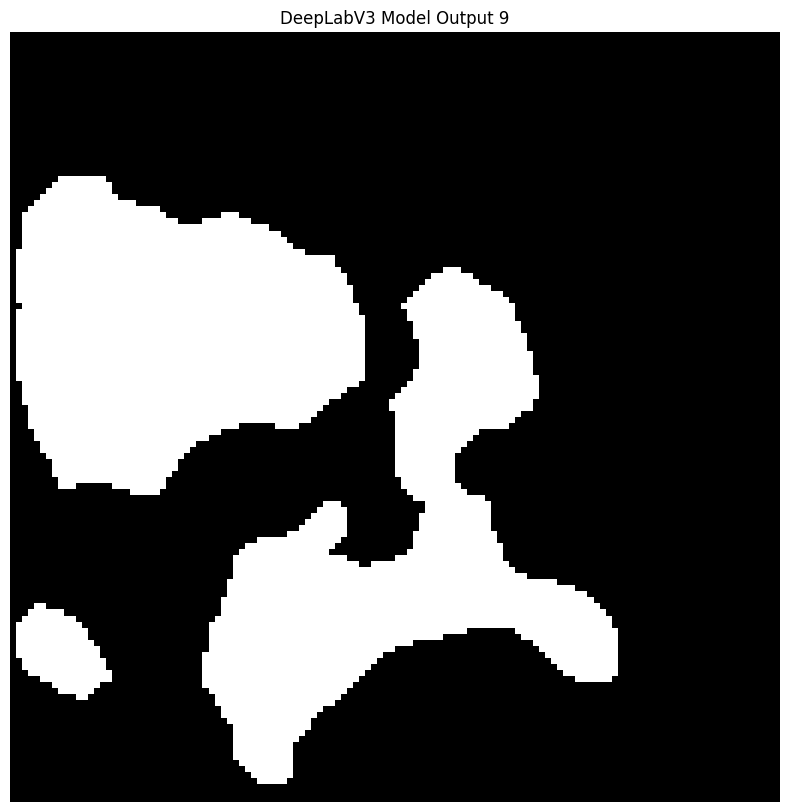

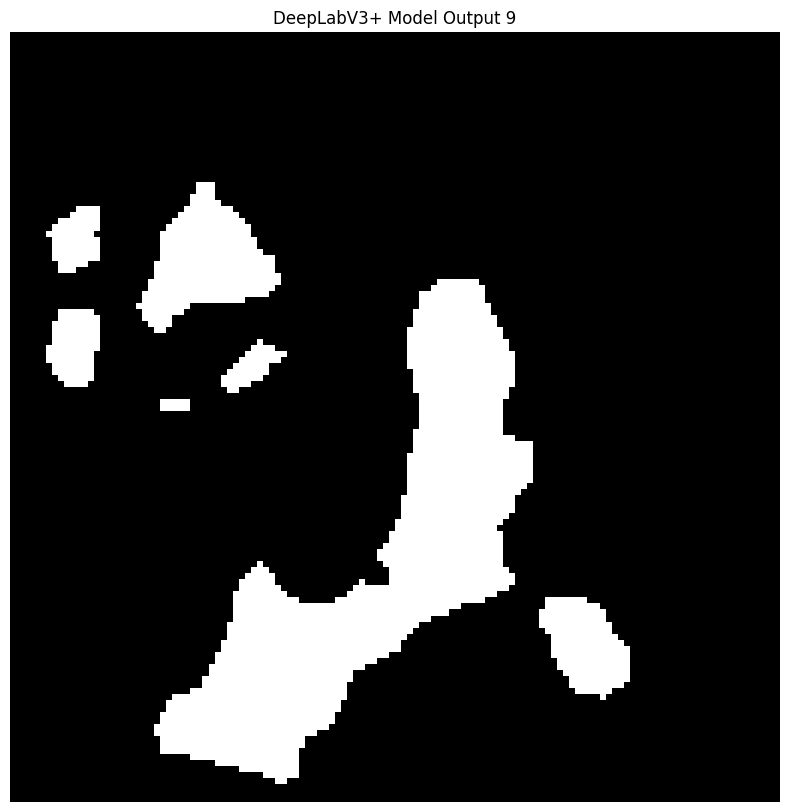

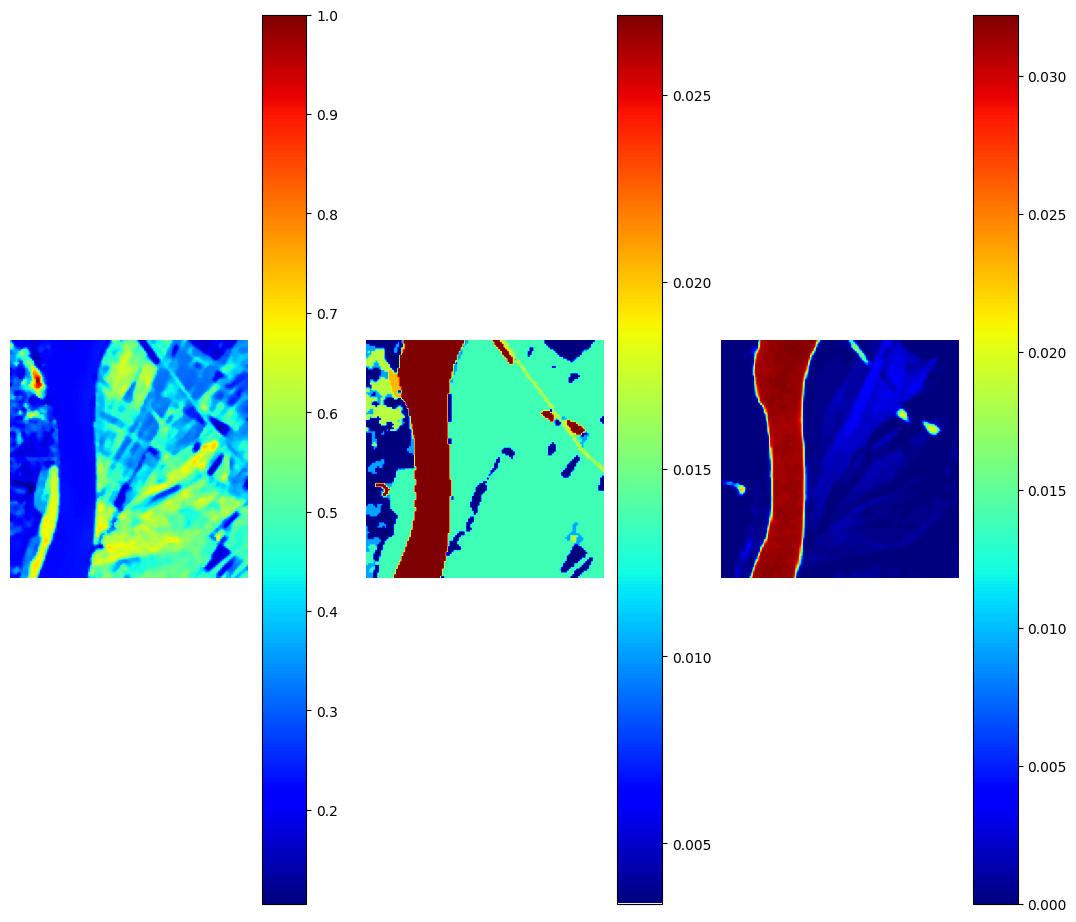

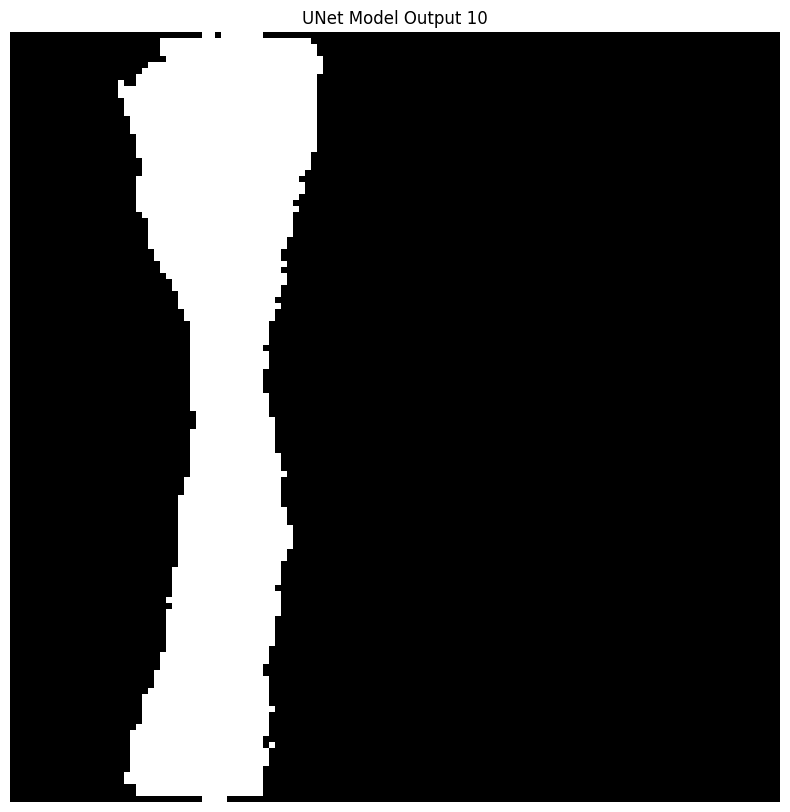

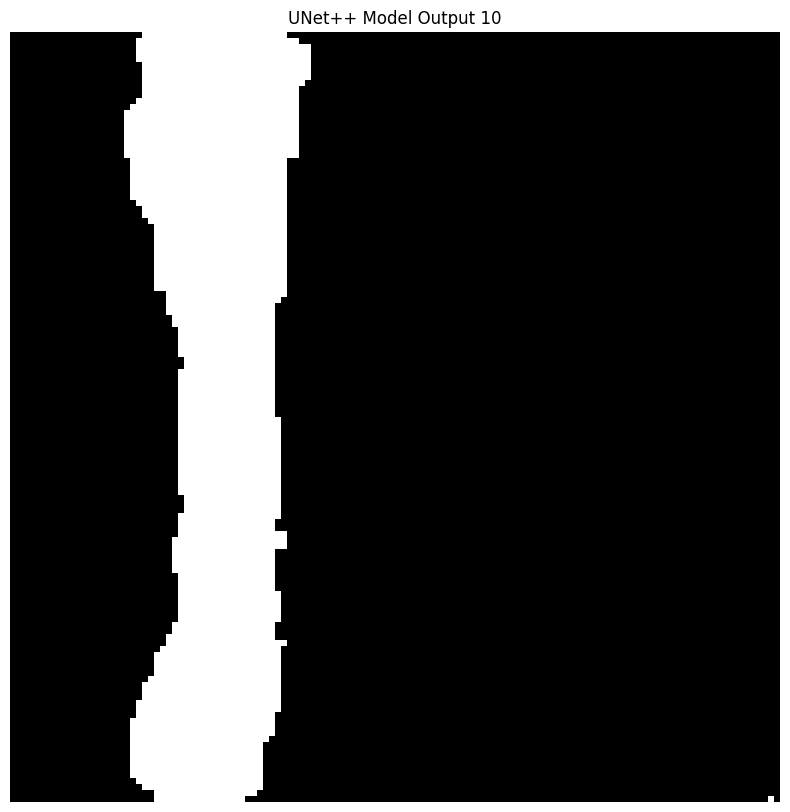

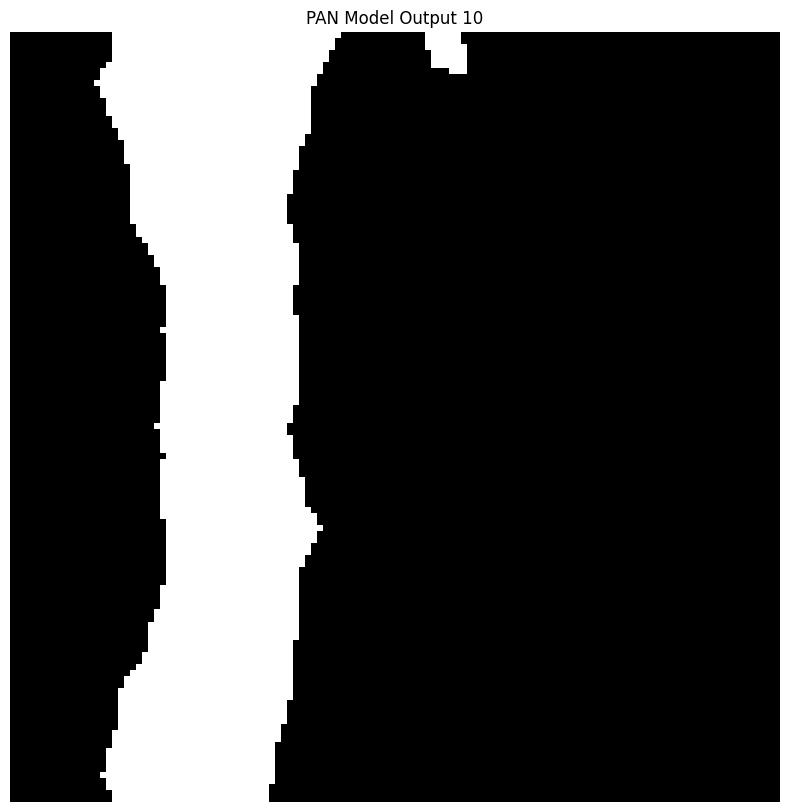

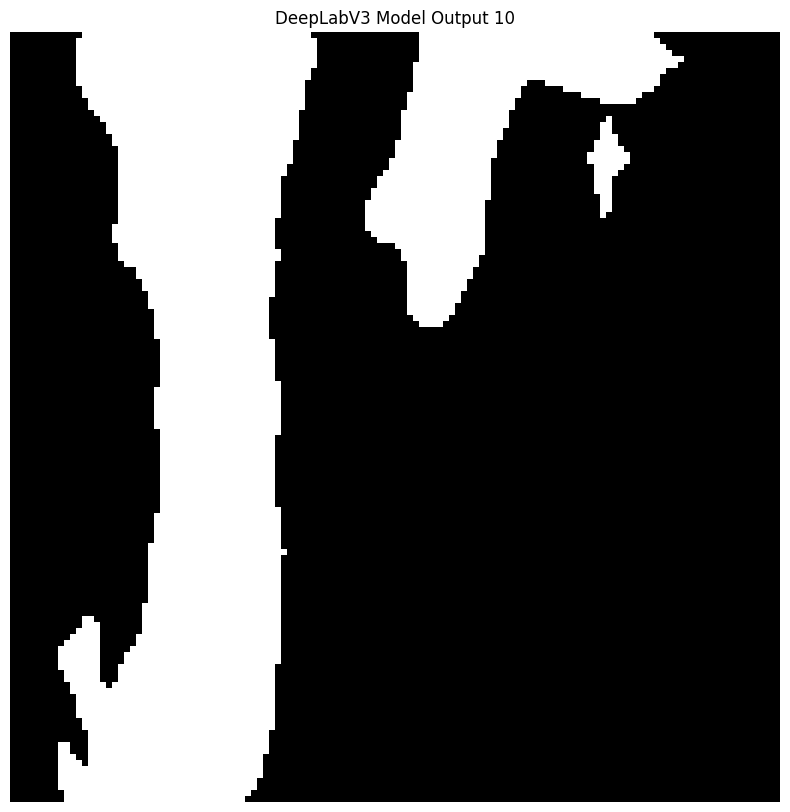

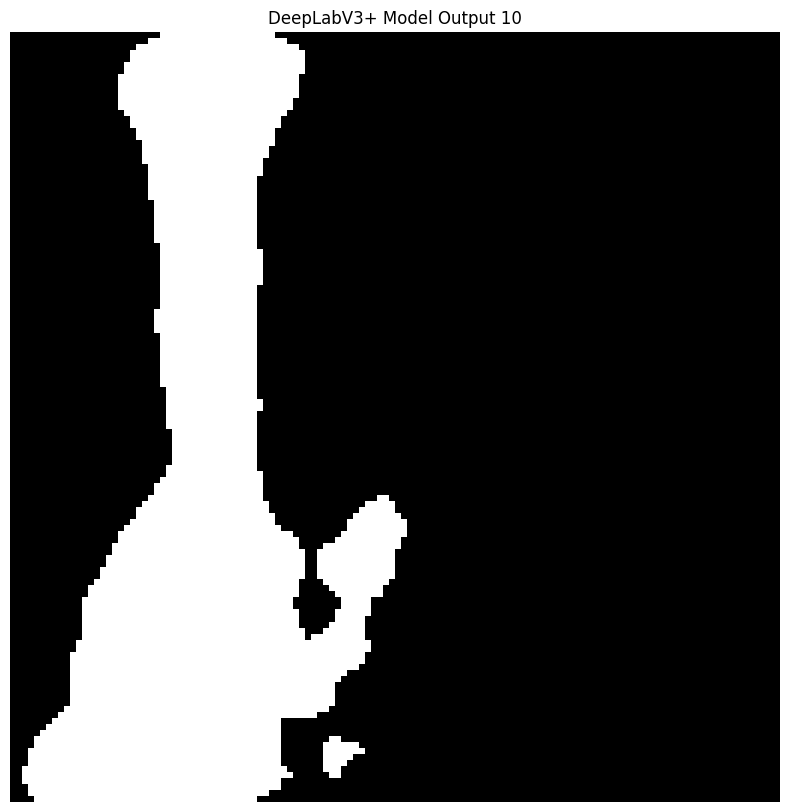

In [35]:
# Set models to evaluation mode
Unet_model.eval()
UnetPlusPlus_model.eval()
pan_model.eval()
DeepLabV3_model.eval()
DeepLabV3Plus_model.eval()

# Function to generate and show model output
def generate_and_show_output(model, input_batch, title):
    with torch.no_grad():
        output = model(input_batch)
        output = output.squeeze(0).cpu().numpy()
        output = (output > 0.5).astype(np.uint8)  # Apply thresholding
        plt.figure(figsize=(10, 10))
        plt.imshow(output[0], cmap='gray')
        plt.title(title)
        plt.axis('off')
        plt.show()

# Sample size
sample_size = 10

# Loop through a sample of the validation images
for i in range(sample_size):
    # Show the input image
    show(dataset.images[i],'None',dataset.images[i].shape[2])
    
    # Prepare the input batch
    input_batch = val_images_torch[i].unsqueeze(0).to(device)
    
    # Generate and show outputs for each model
    generate_and_show_output(Unet_model, input_batch, f'UNet Model Output {i+1}')
    generate_and_show_output(UnetPlusPlus_model, input_batch, f'UNet++ Model Output {i+1}')
    generate_and_show_output(pan_model, input_batch, f'PAN Model Output {i+1}')
    generate_and_show_output(DeepLabV3_model, input_batch, f'DeepLabV3 Model Output {i+1}')
    generate_and_show_output(DeepLabV3Plus_model, input_batch, f'DeepLabV3+ Model Output {i+1}')

In [36]:
# Assuming the SatelliteDataset class returns lists
val_image_path="/kaggle/input/satellite-data/satalite data/val/images"
dataset_2 = SatelliteDataset_2(val_image_path, None, None, "medianBlur", 3)

val_images = np.array(dataset_2.images)

# Transpose and convert to tensors
val_images_torch = torch.tensor(val_images.transpose(0, 3, 1, 2)).float()

val_images_torch = val_images_torch.to(device)
print(val_images_torch.shape)

torch.Size([125, 12, 128, 128])


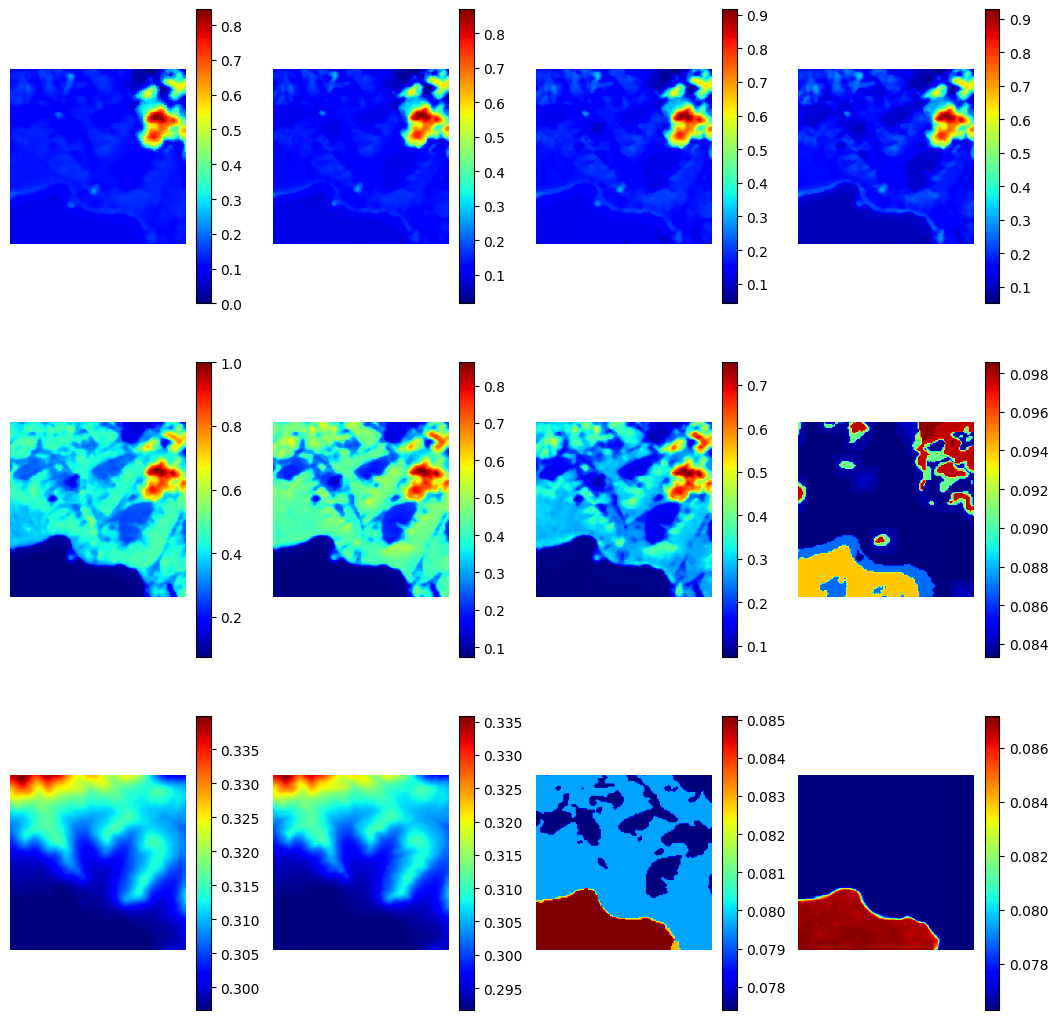

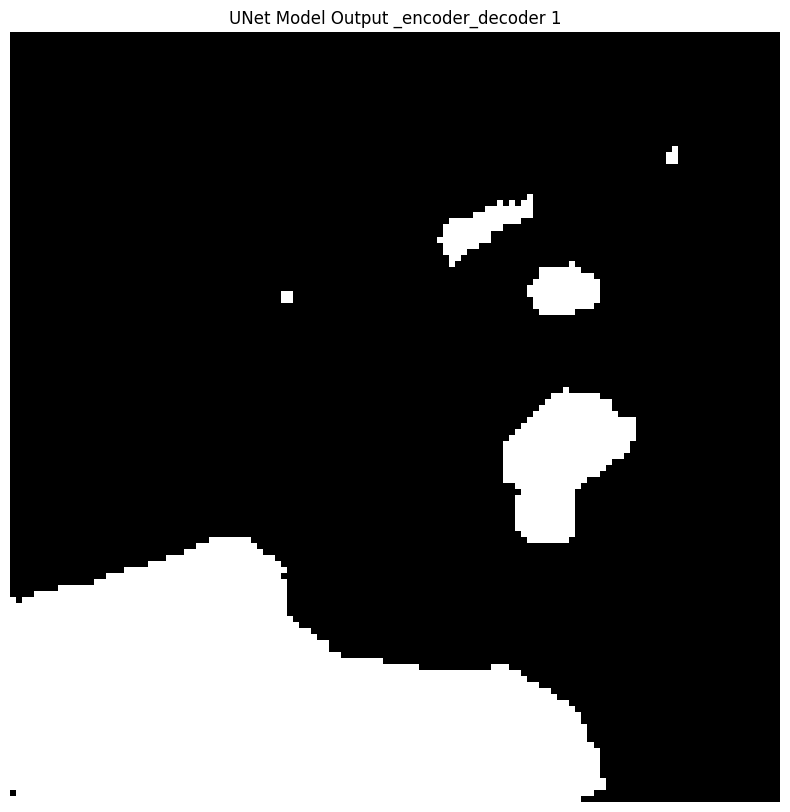

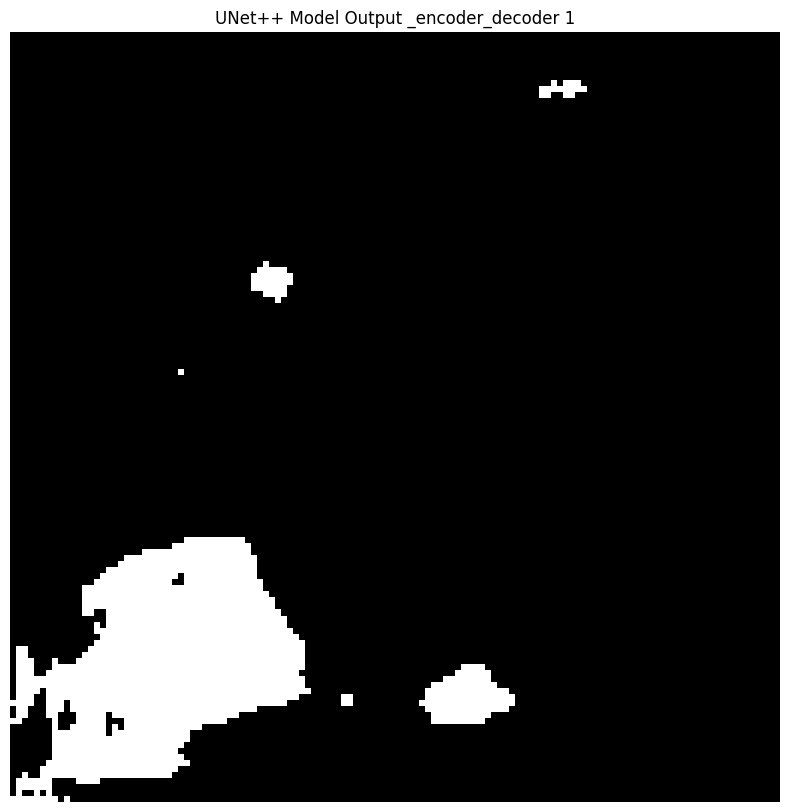

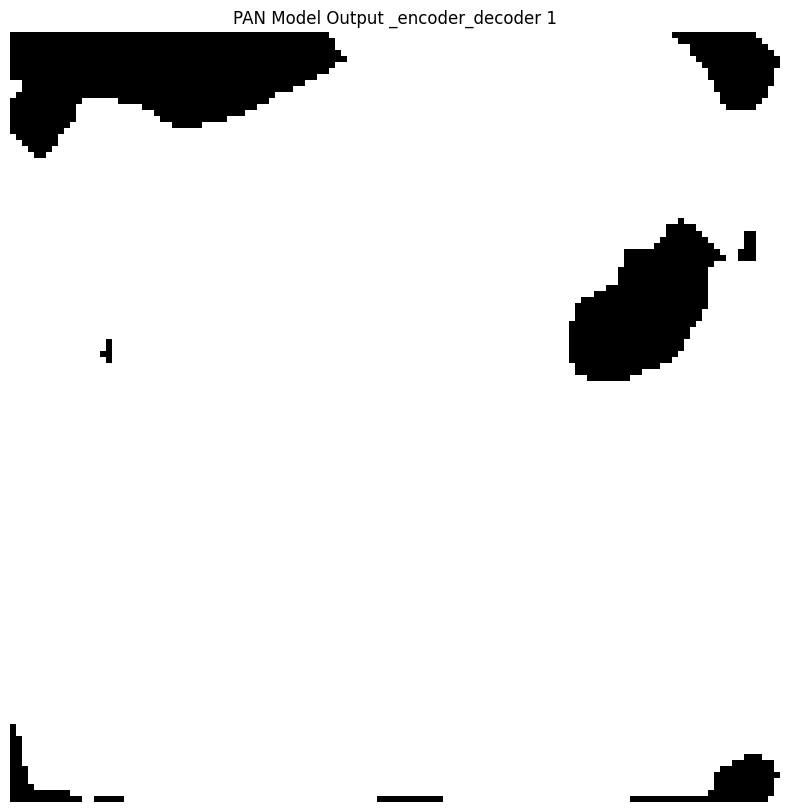

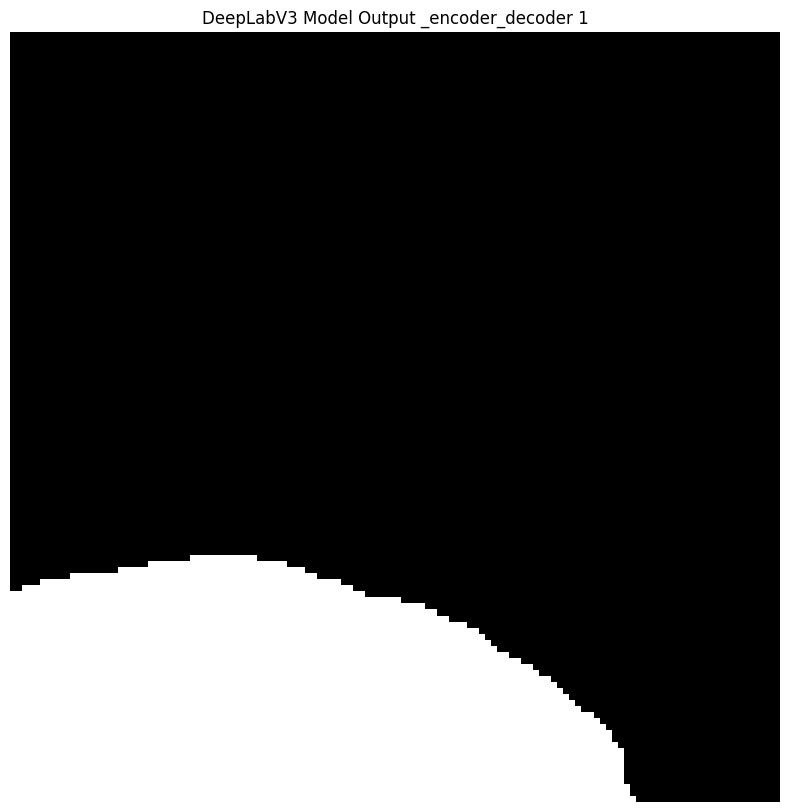

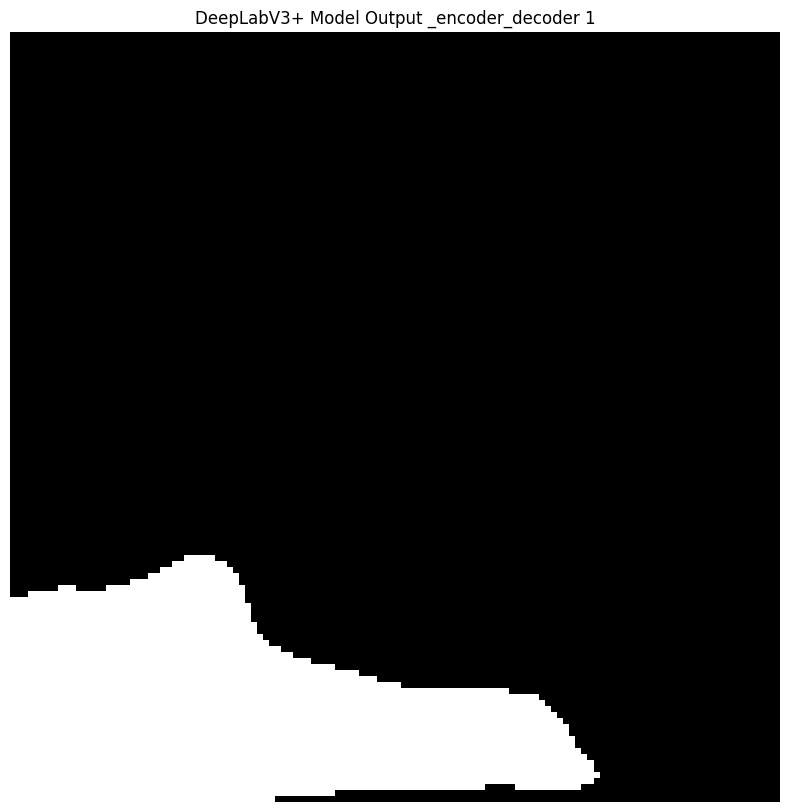

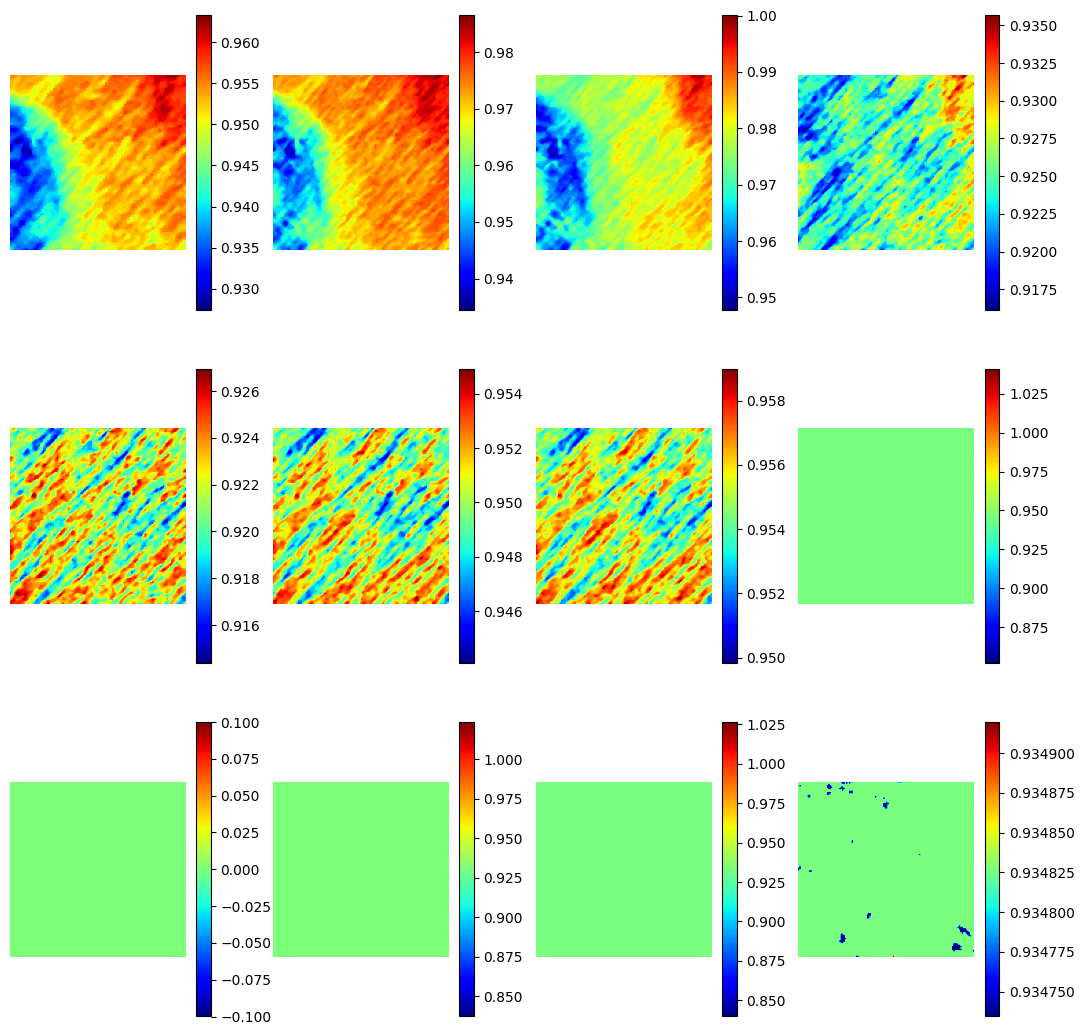

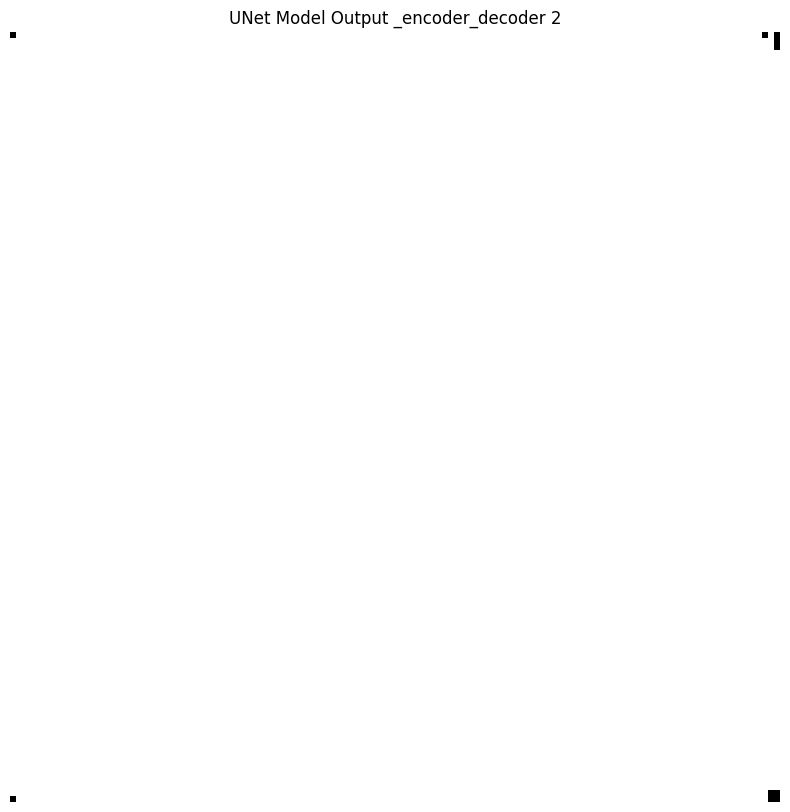

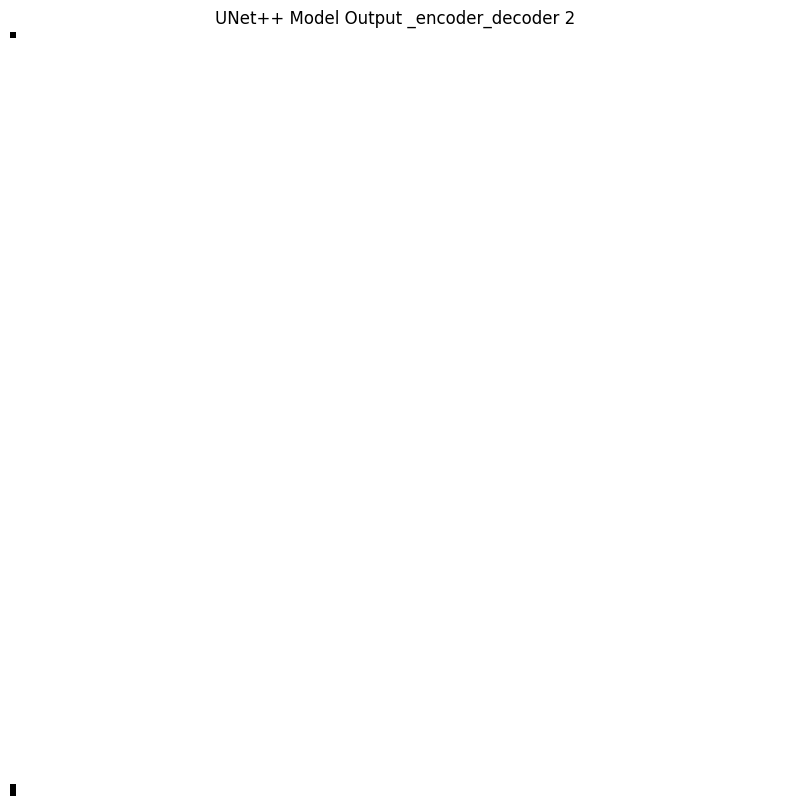

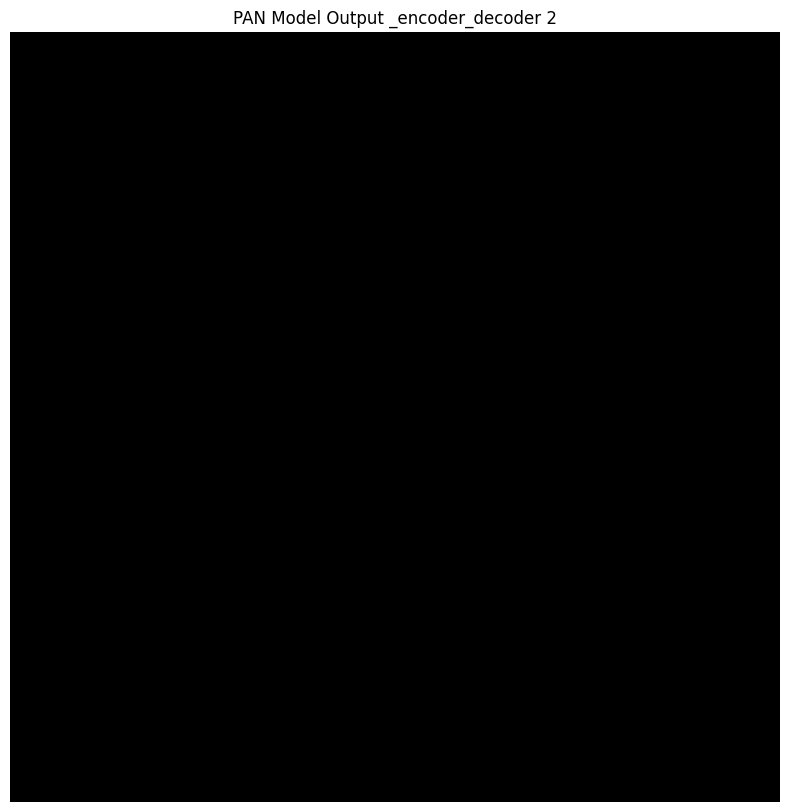

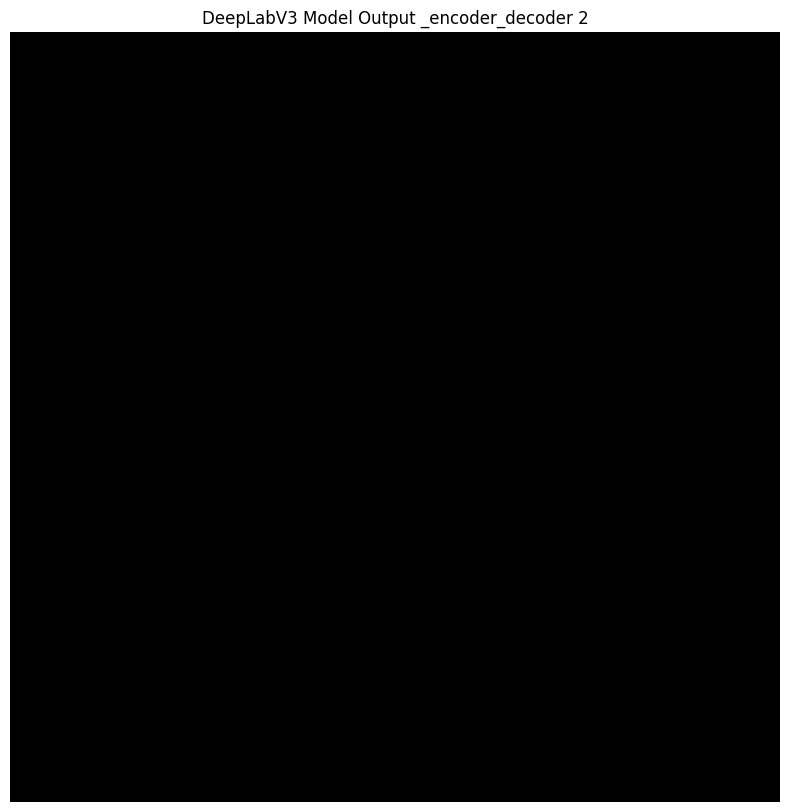

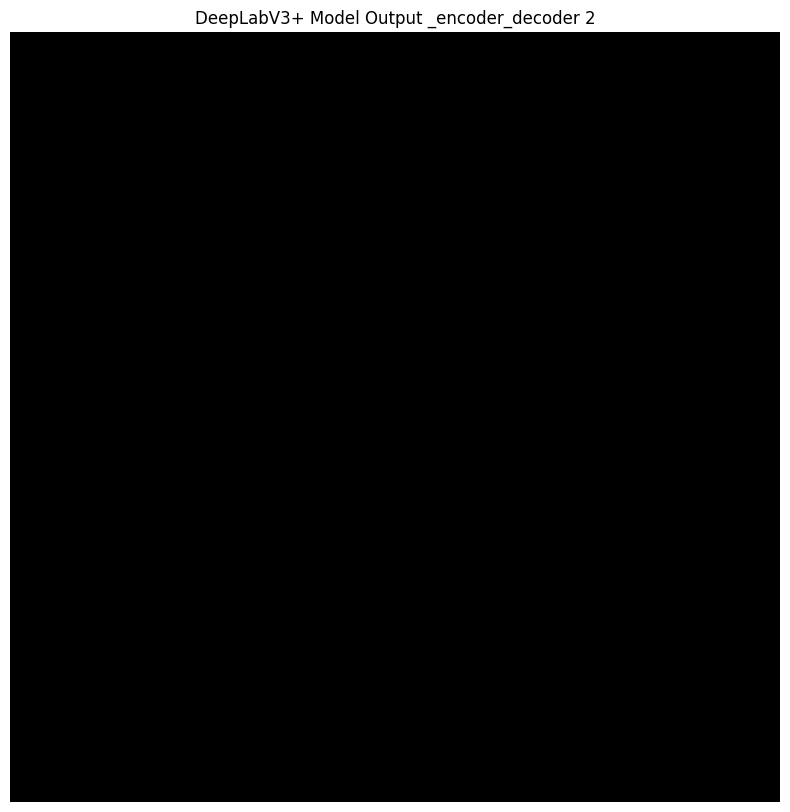

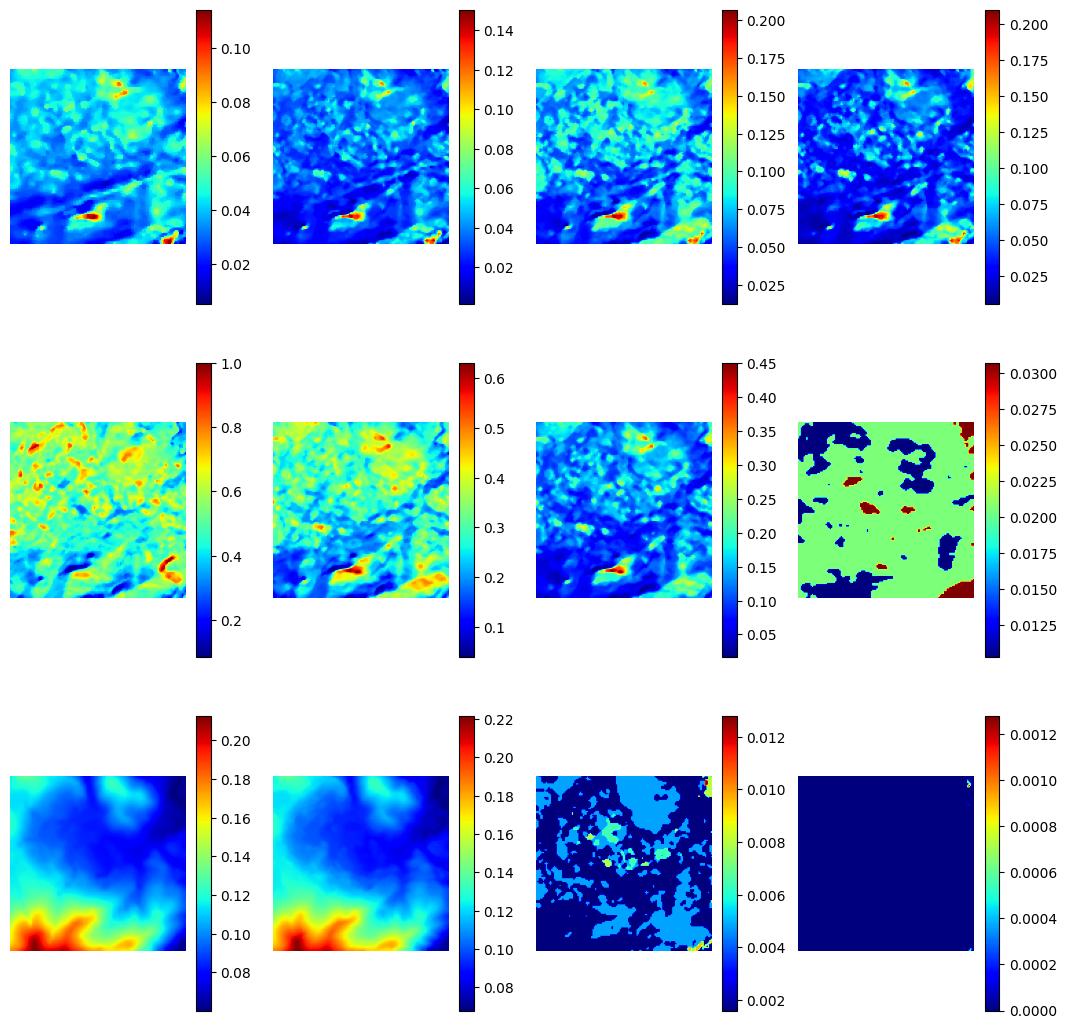

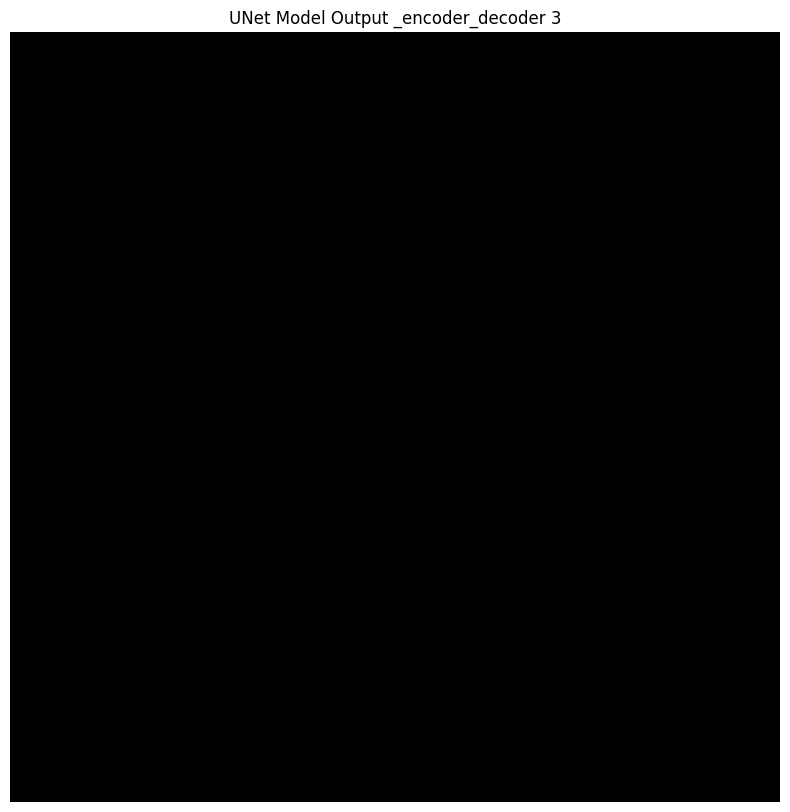

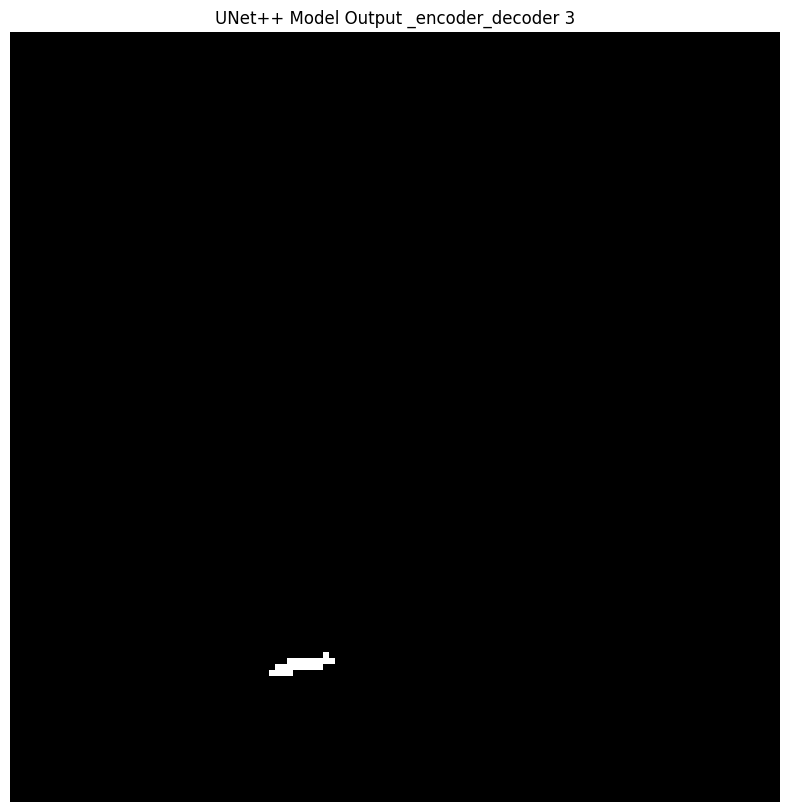

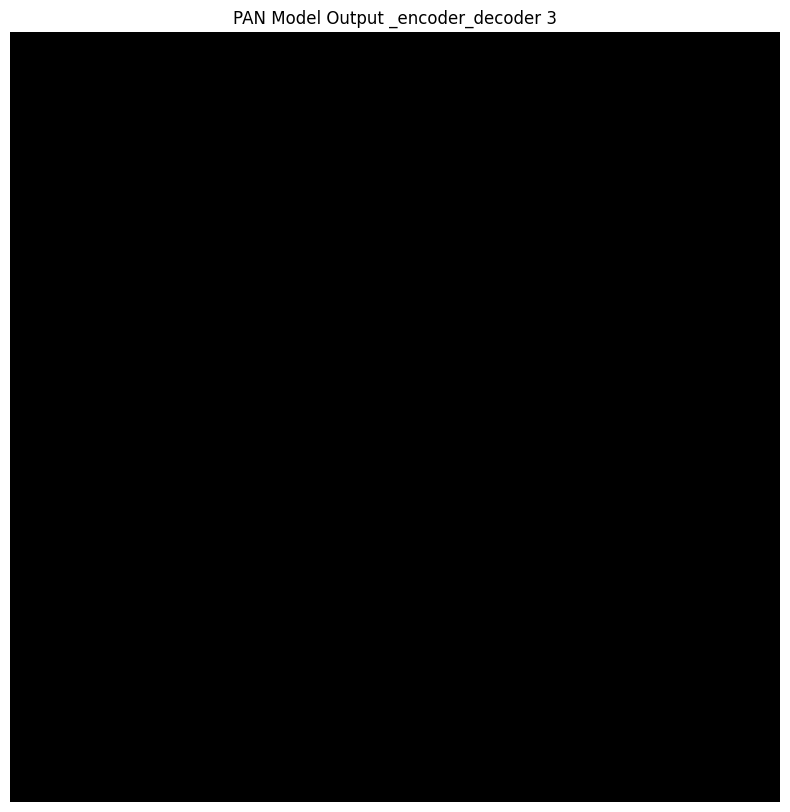

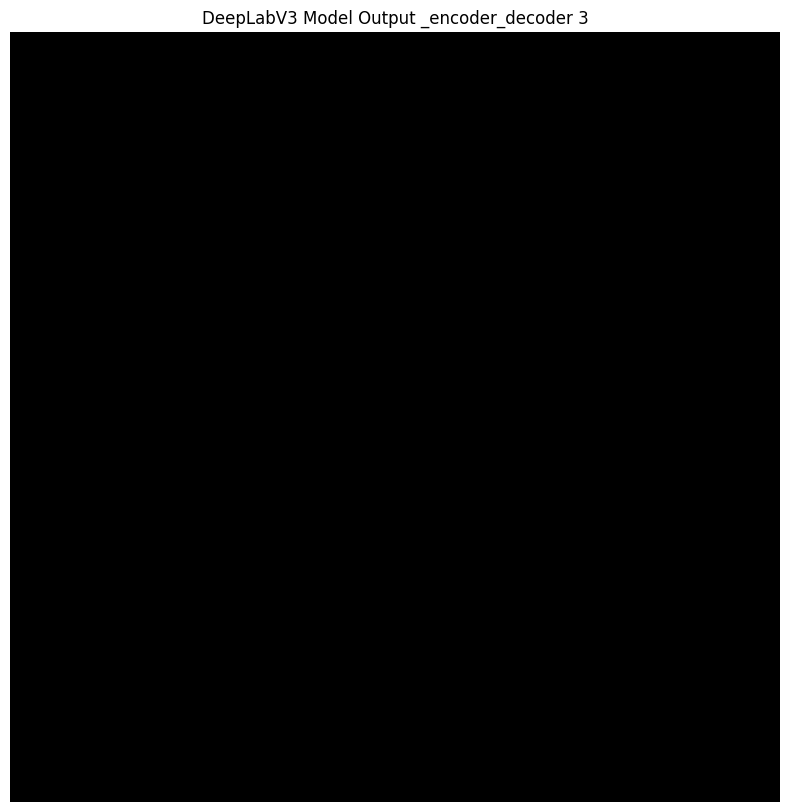

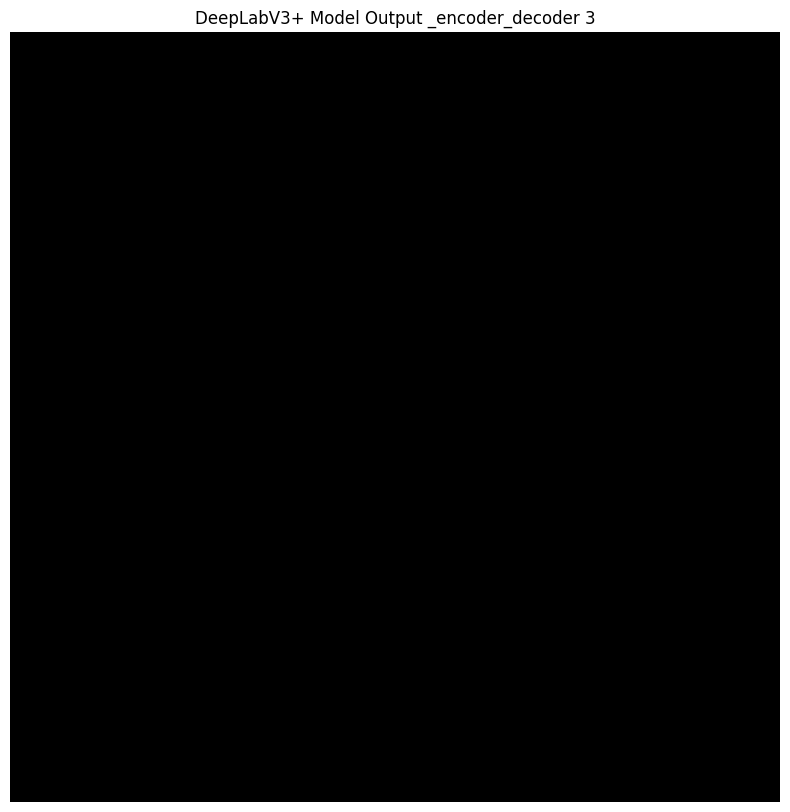

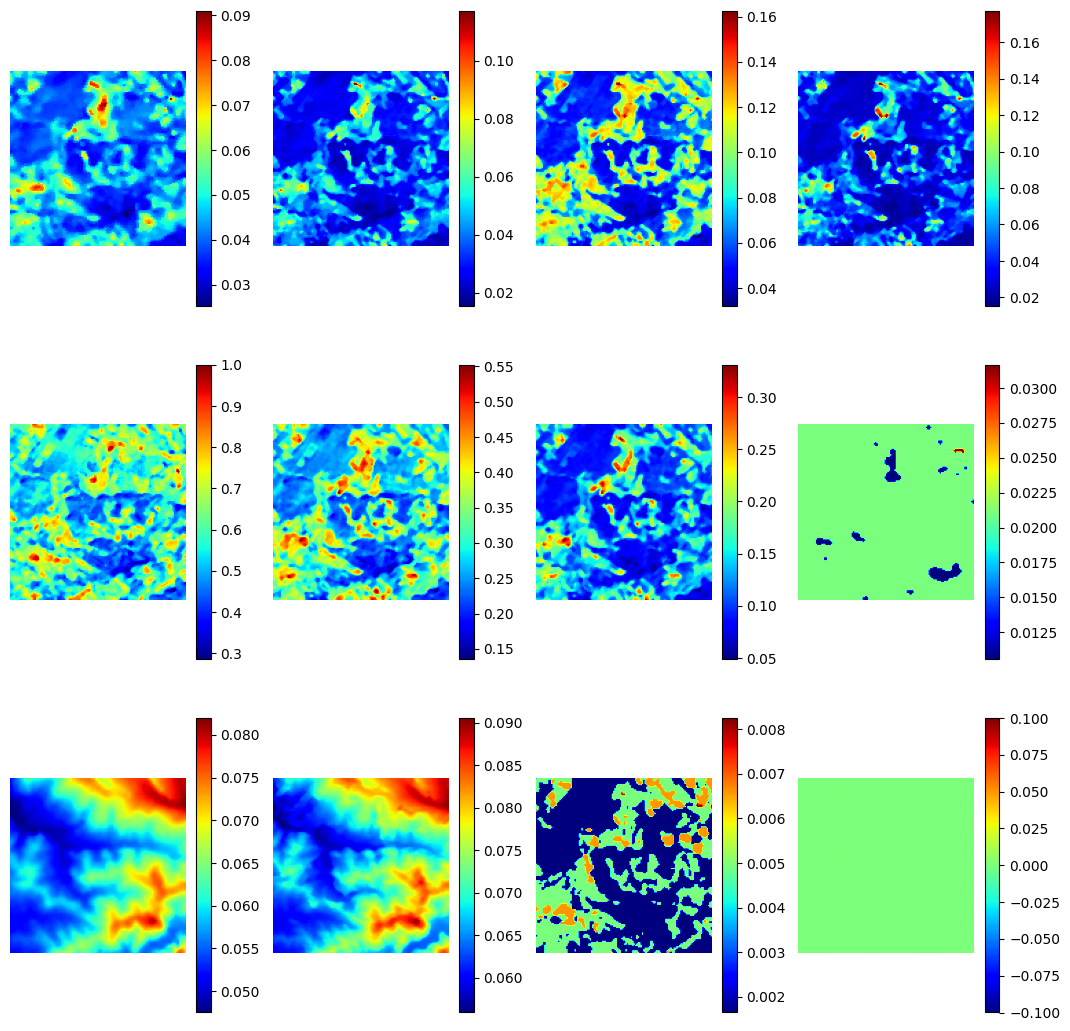

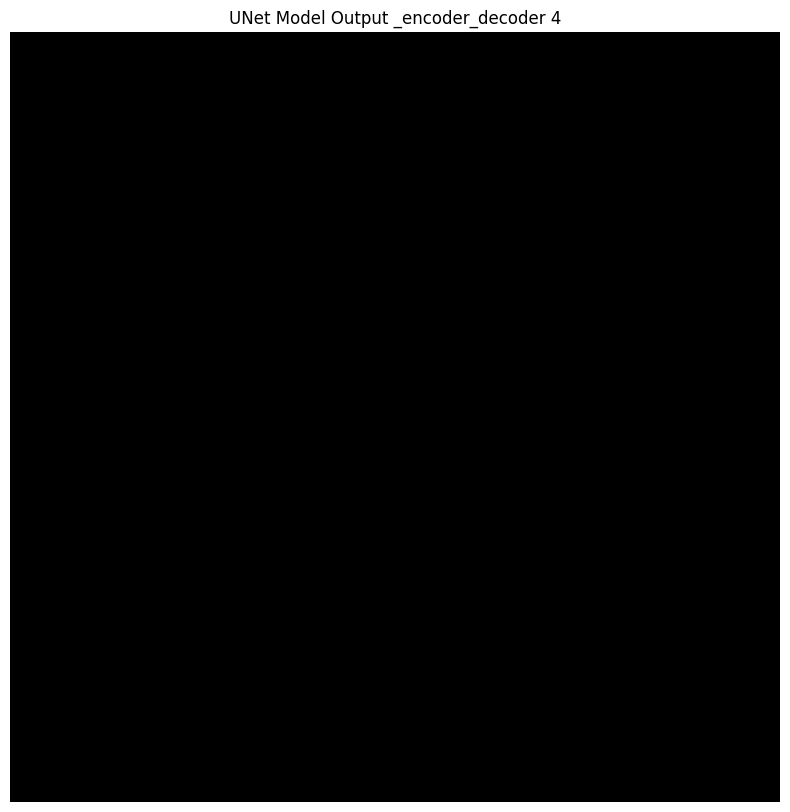

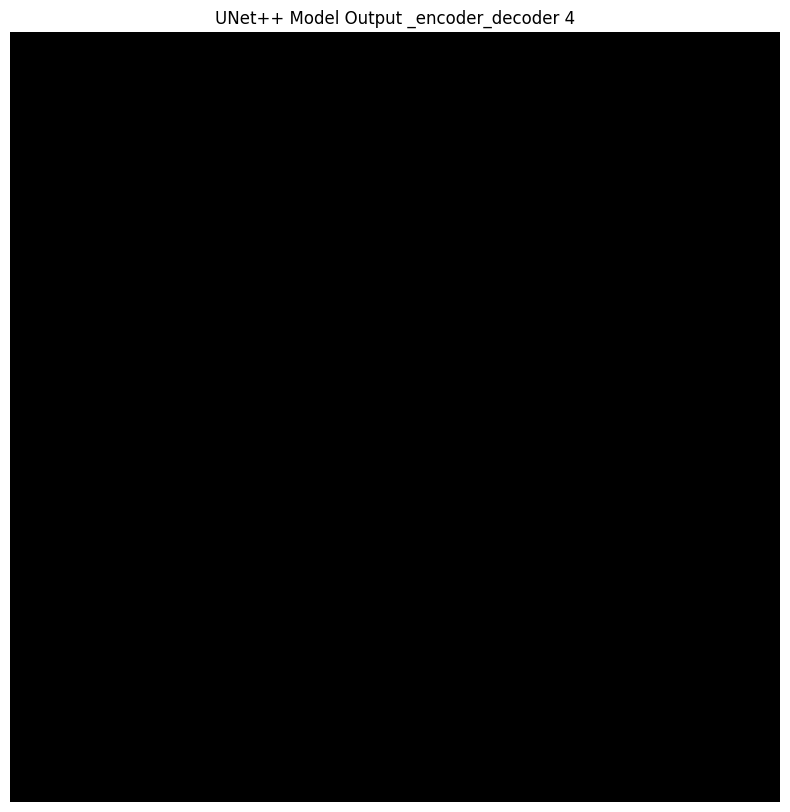

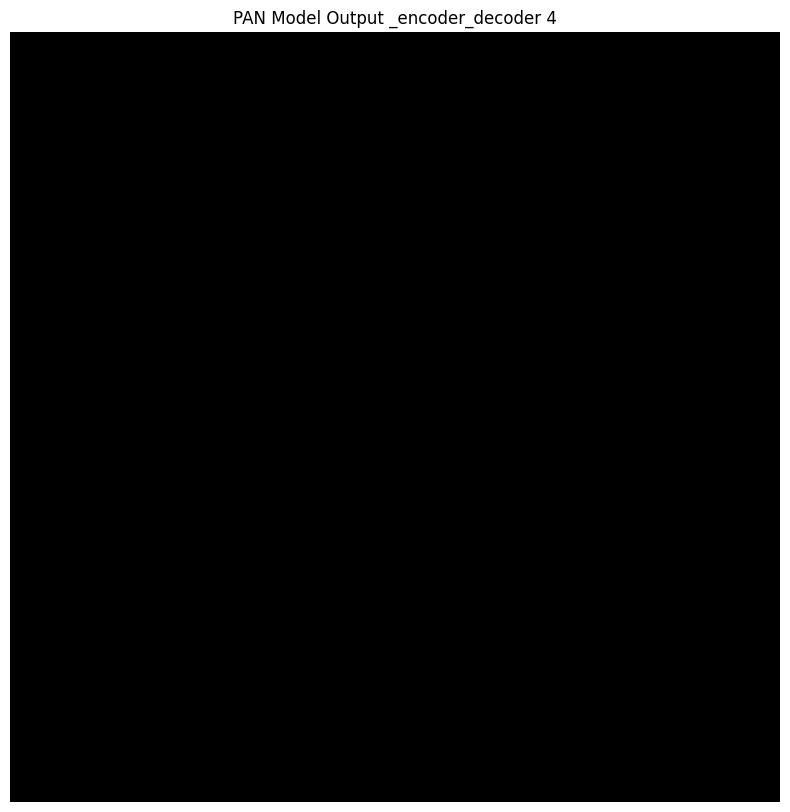

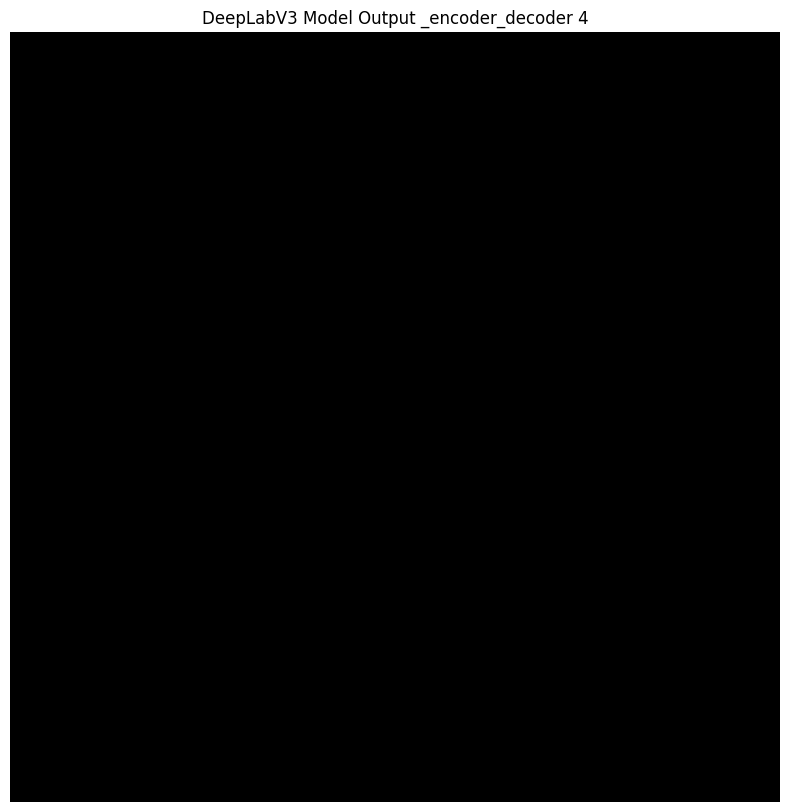

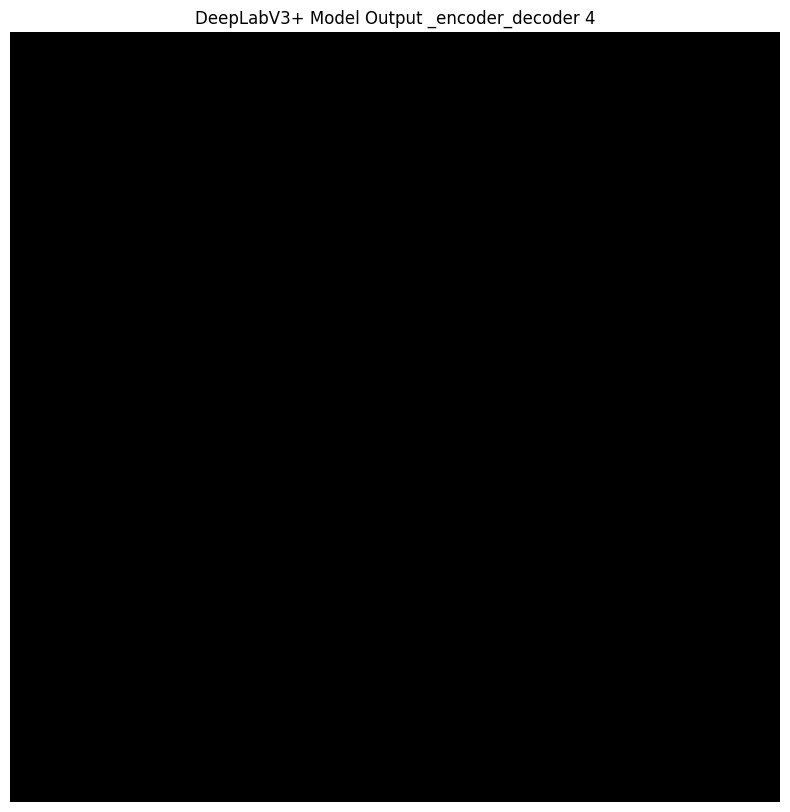

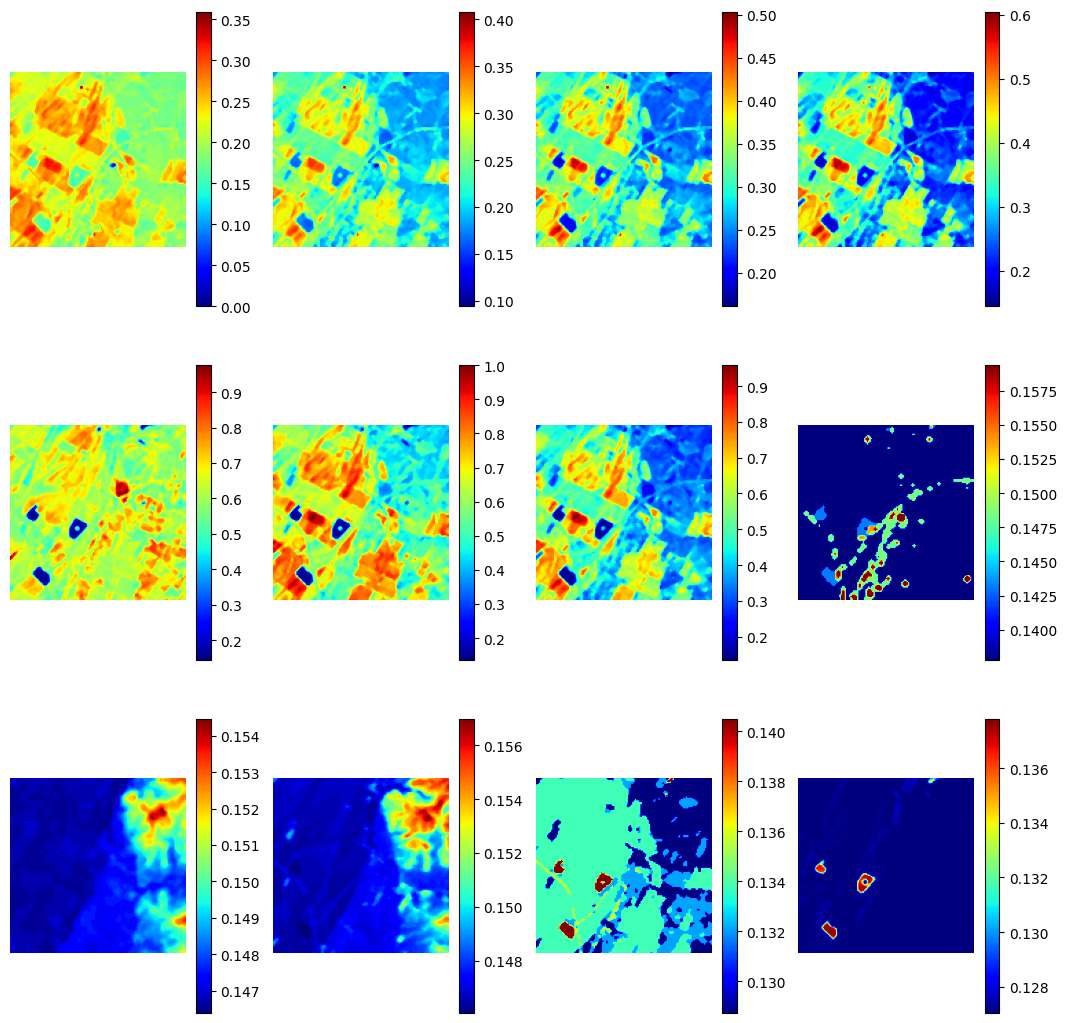

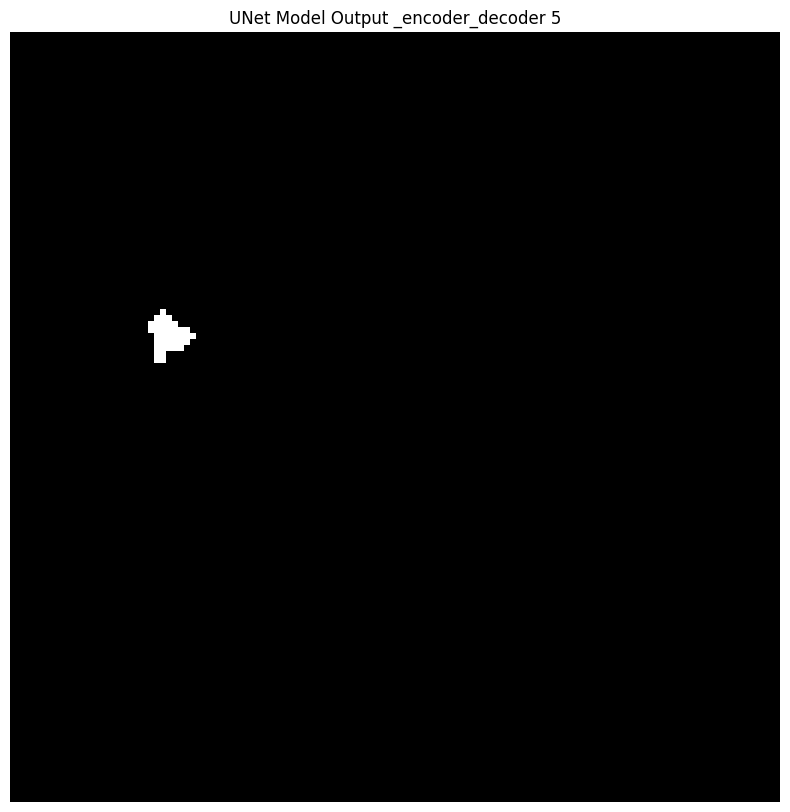

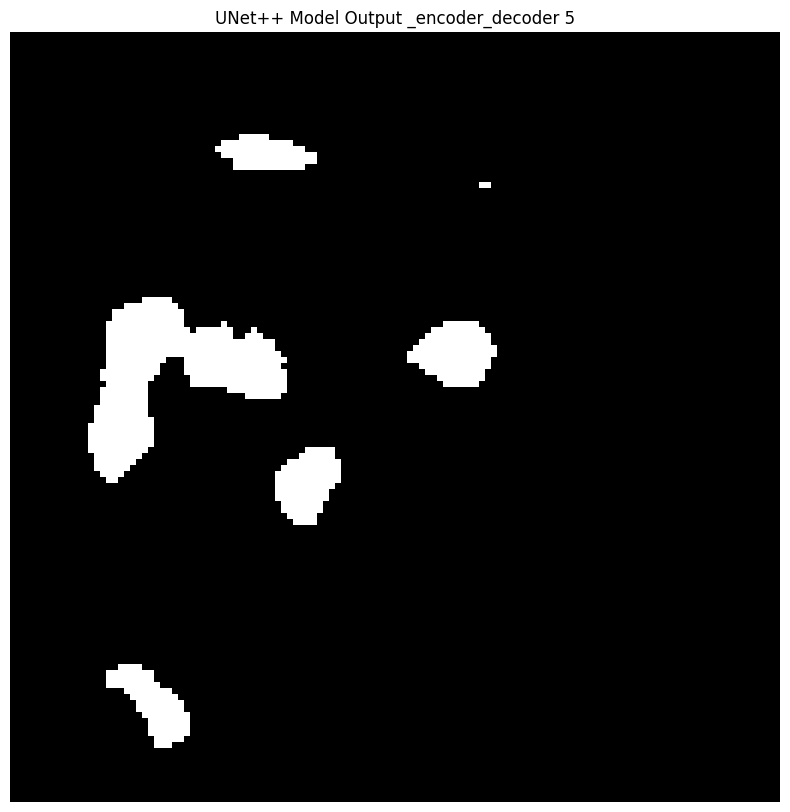

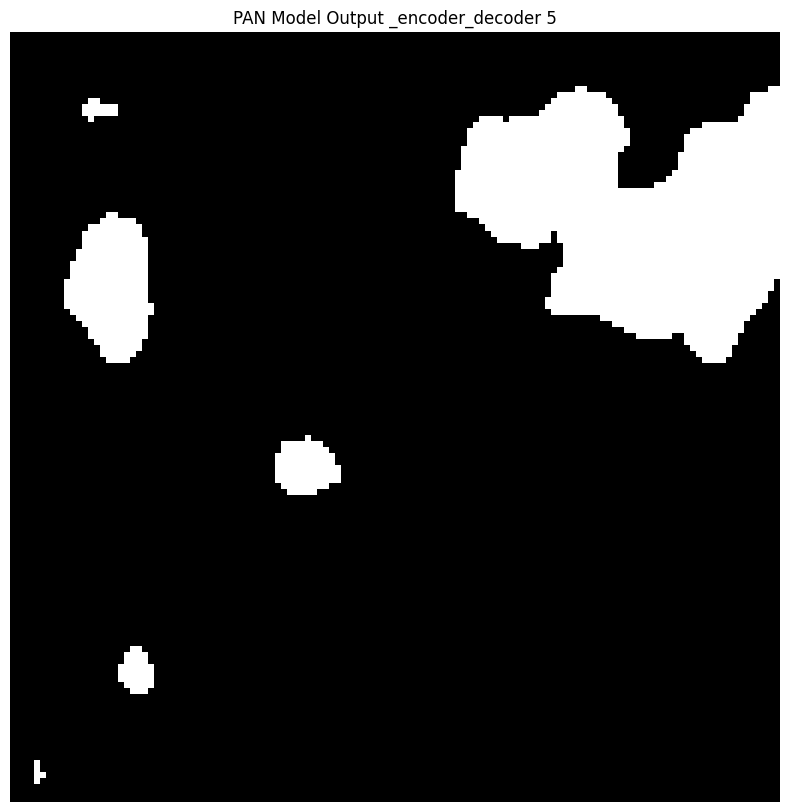

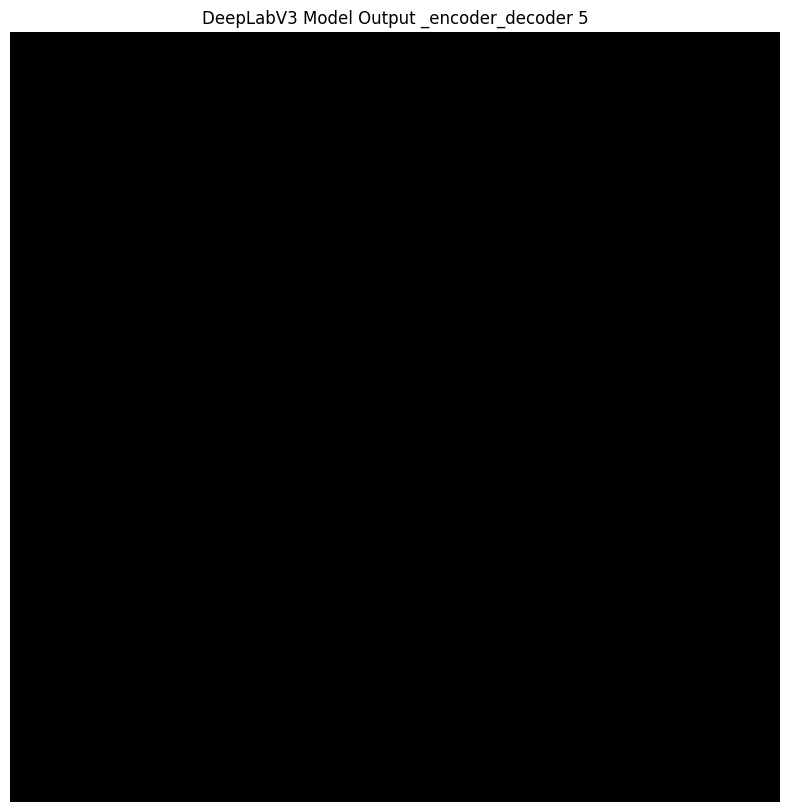

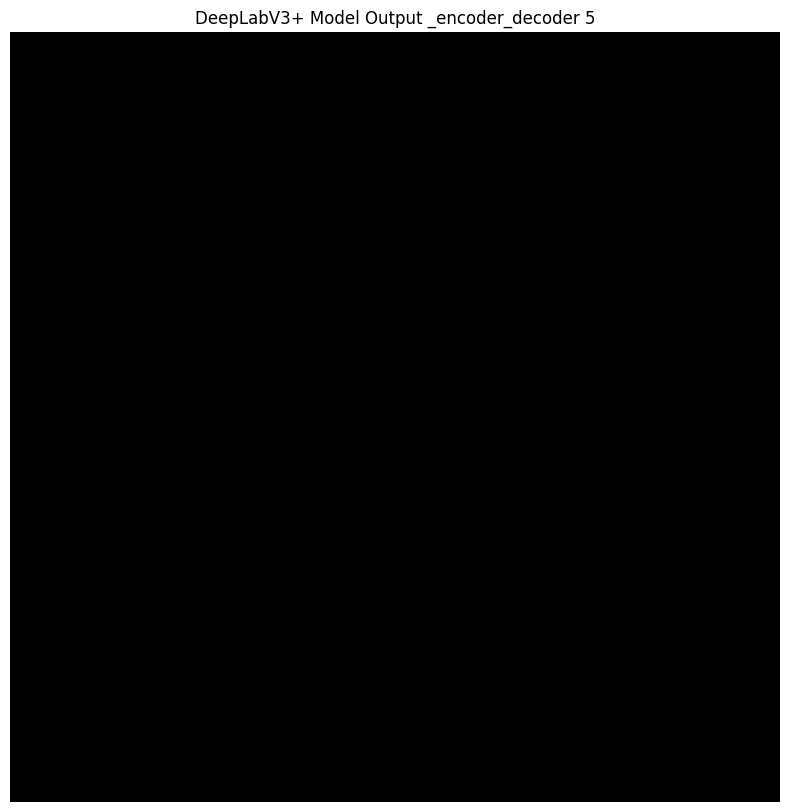

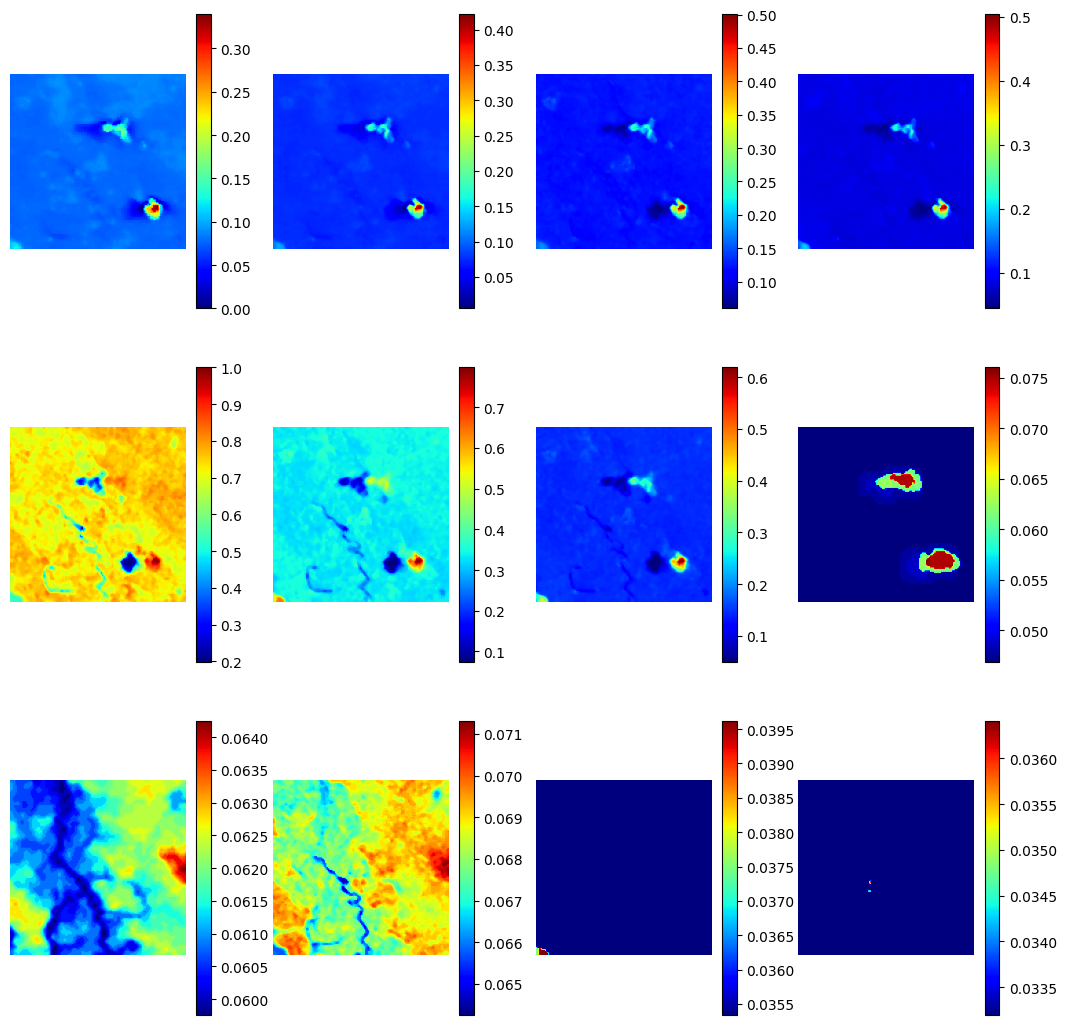

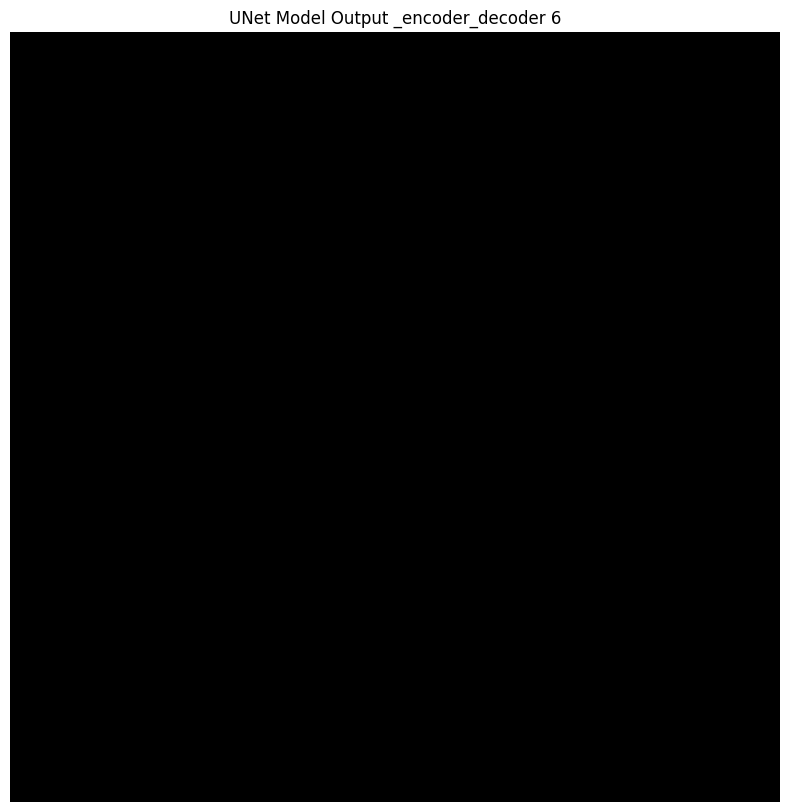

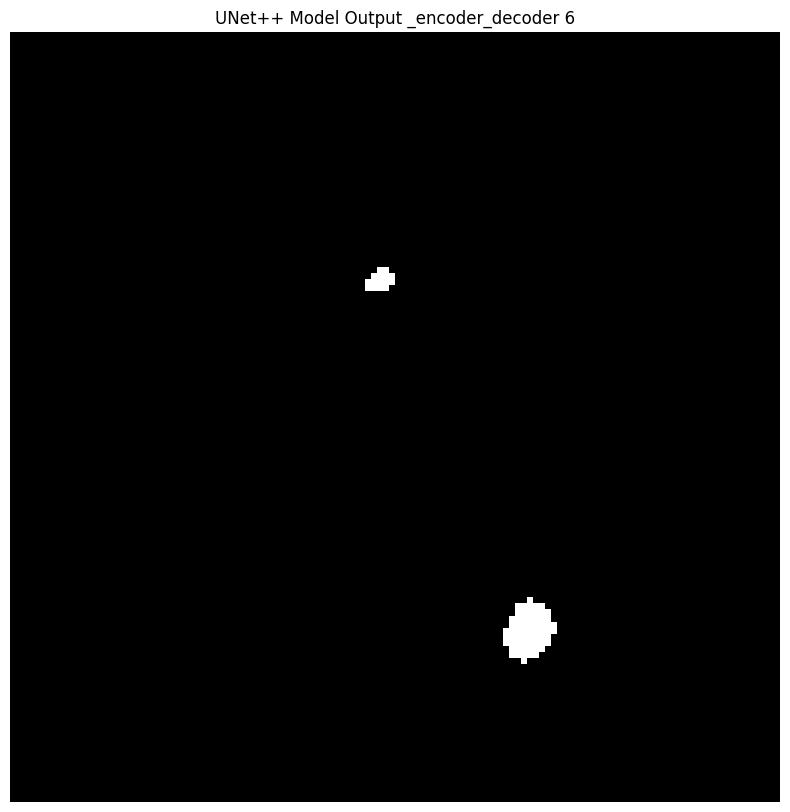

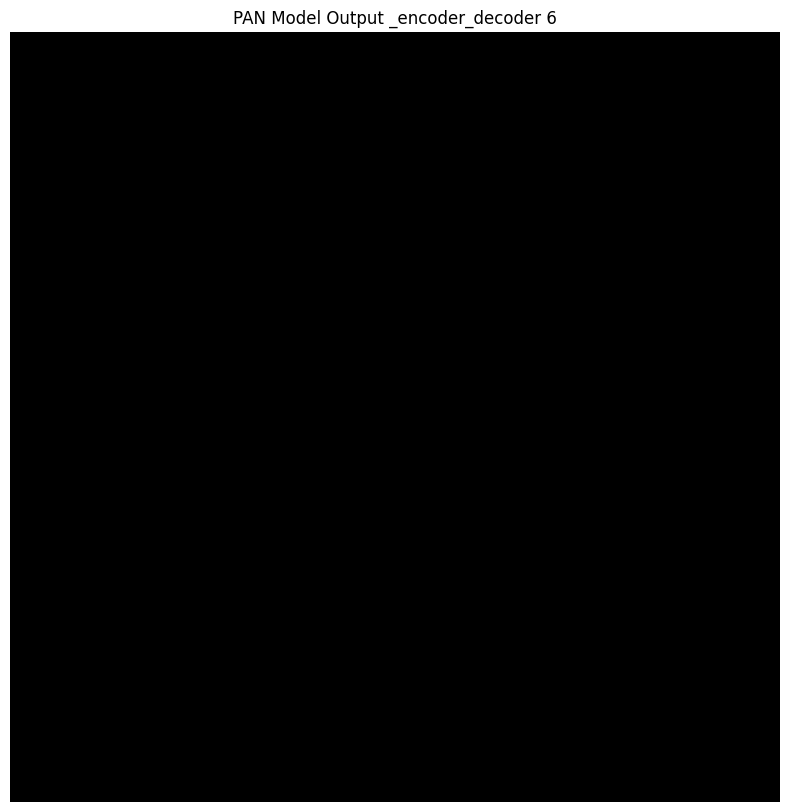

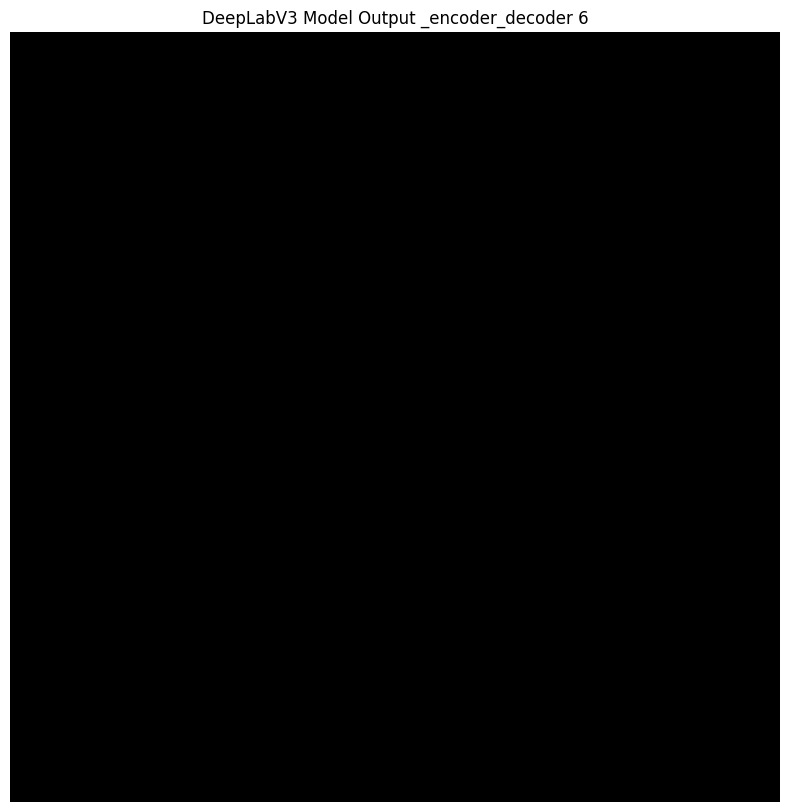

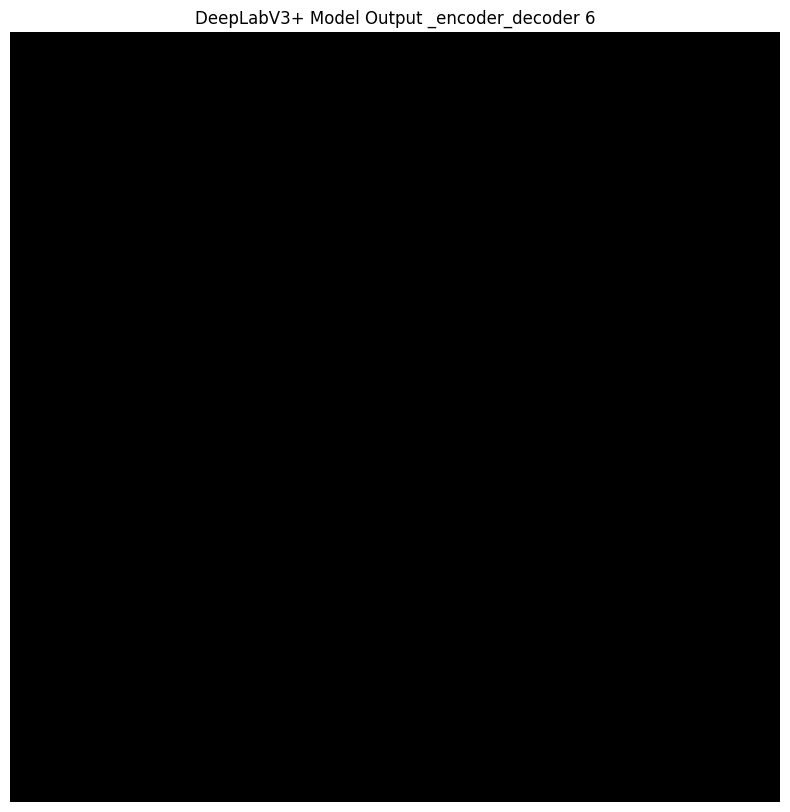

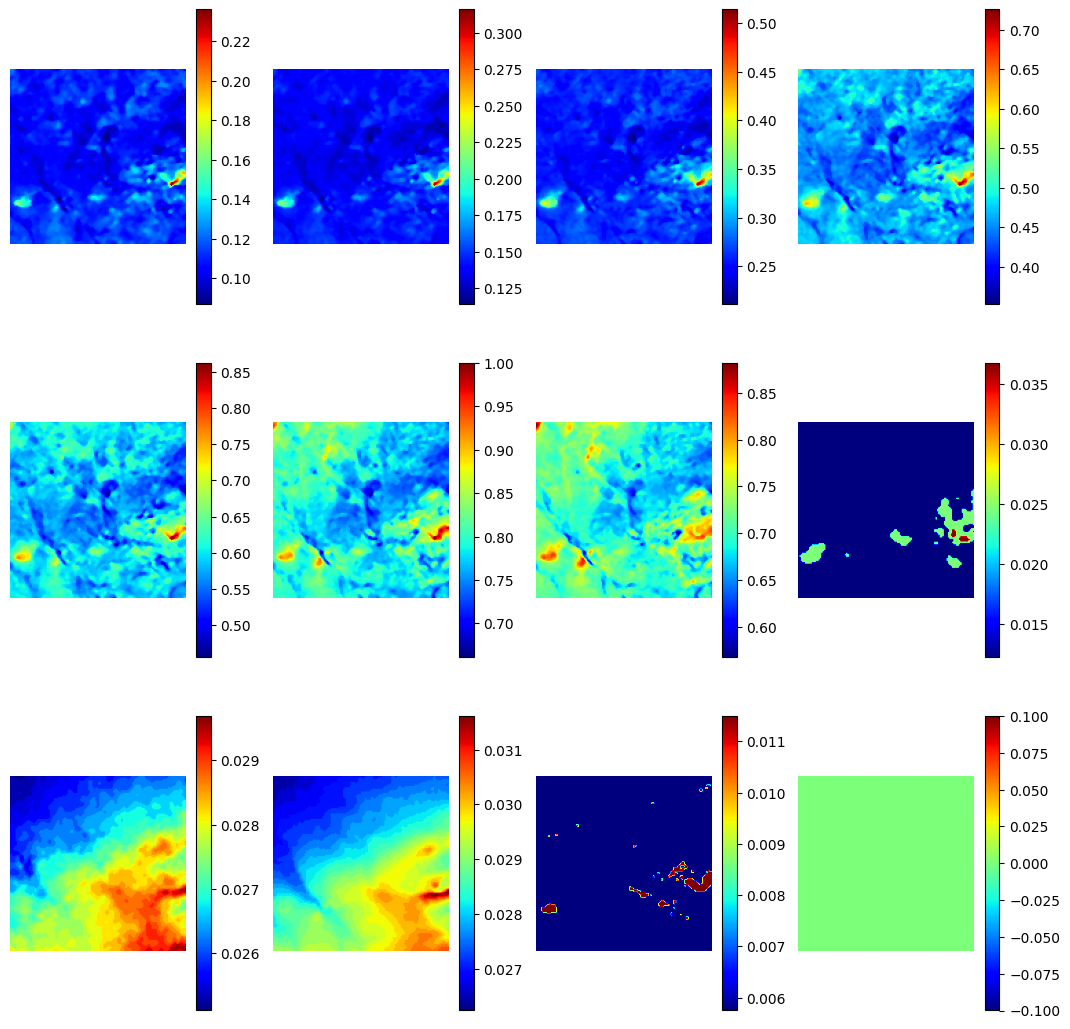

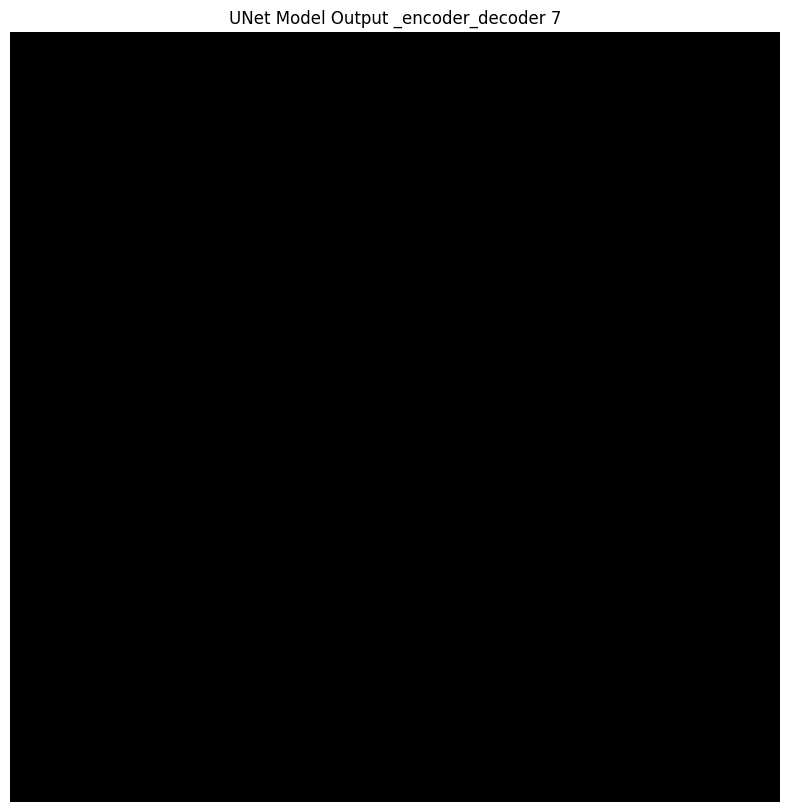

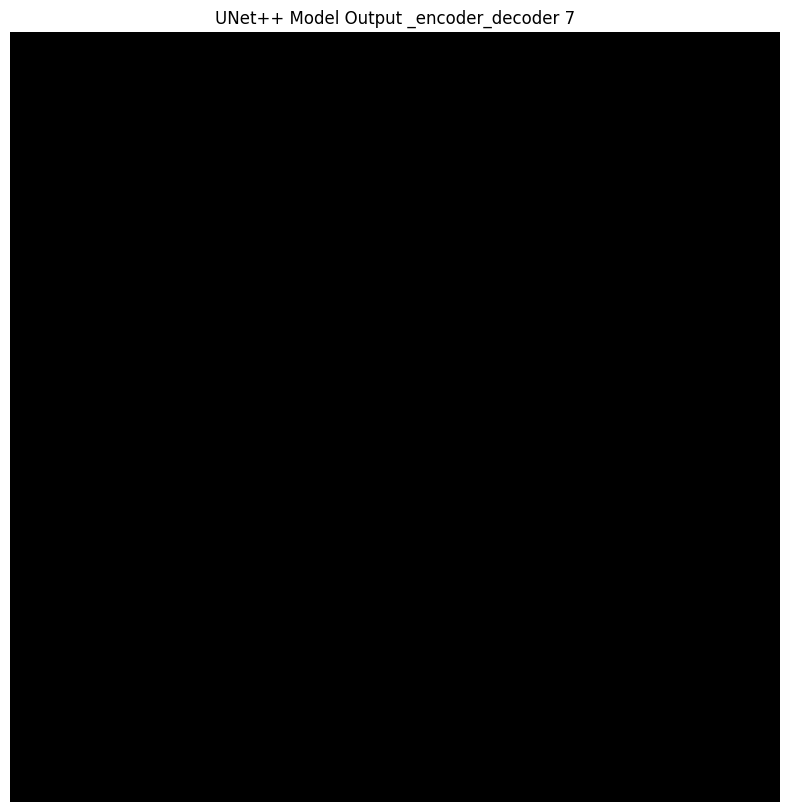

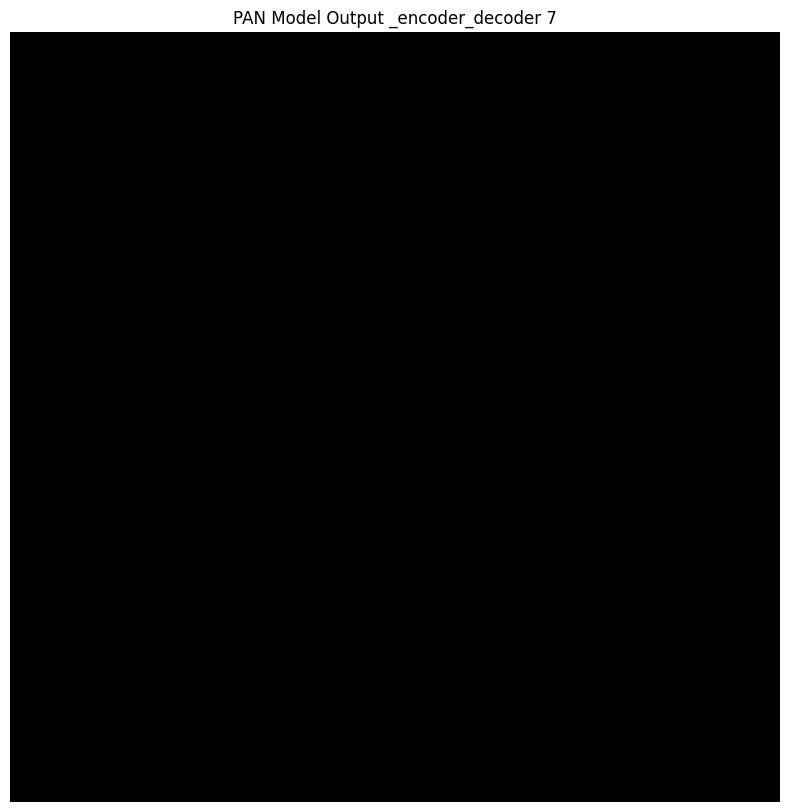

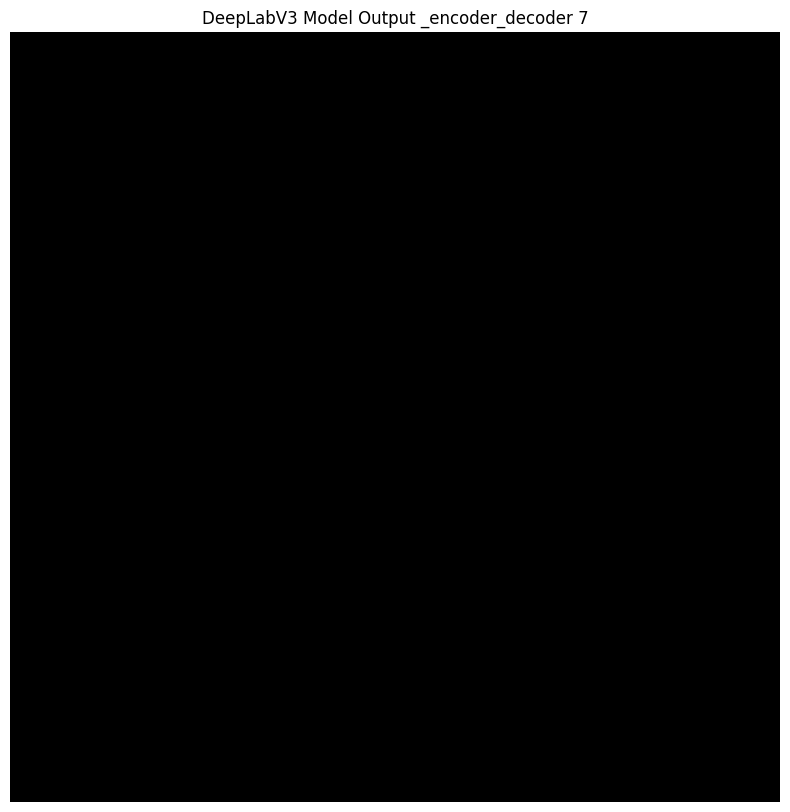

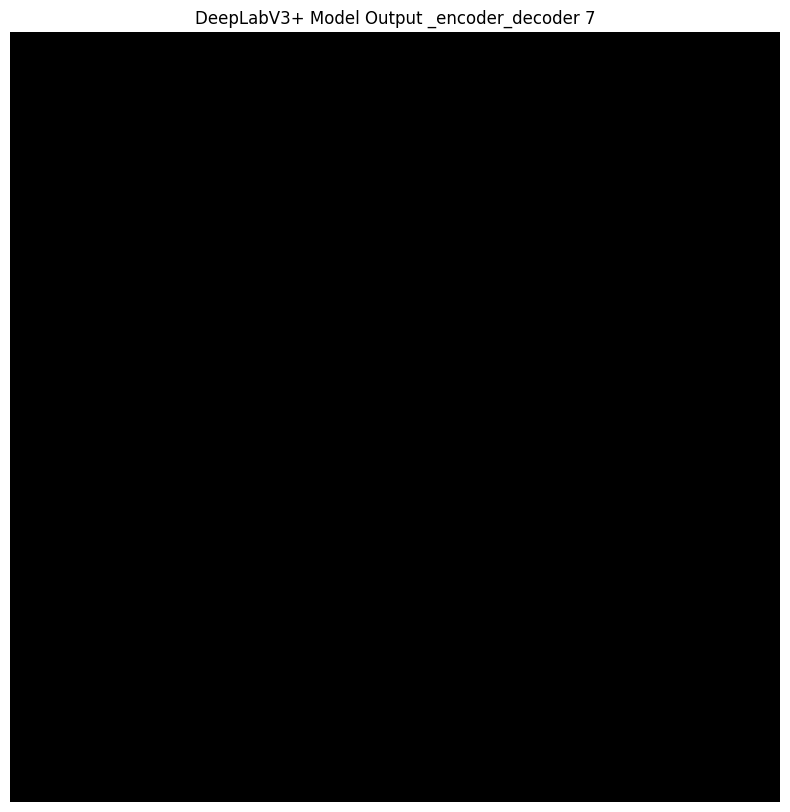

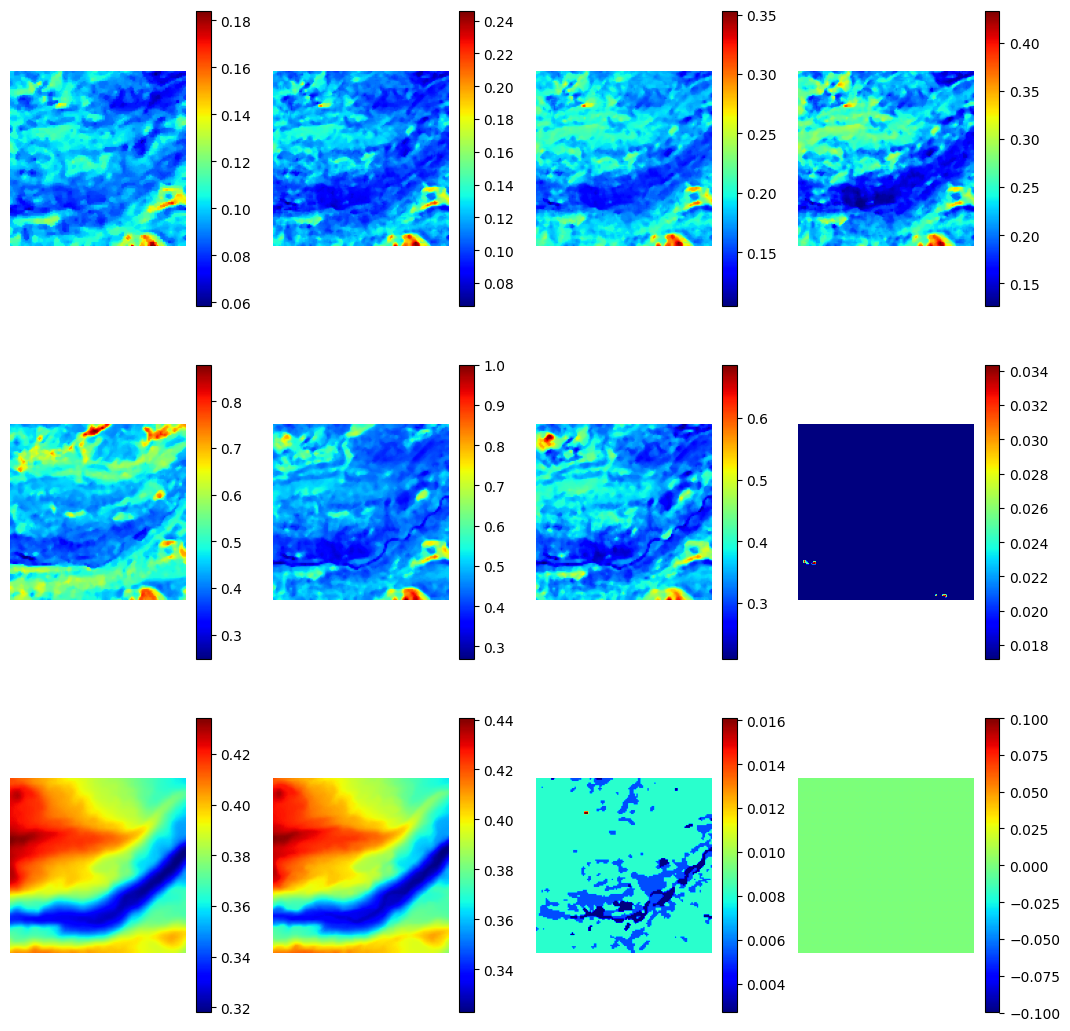

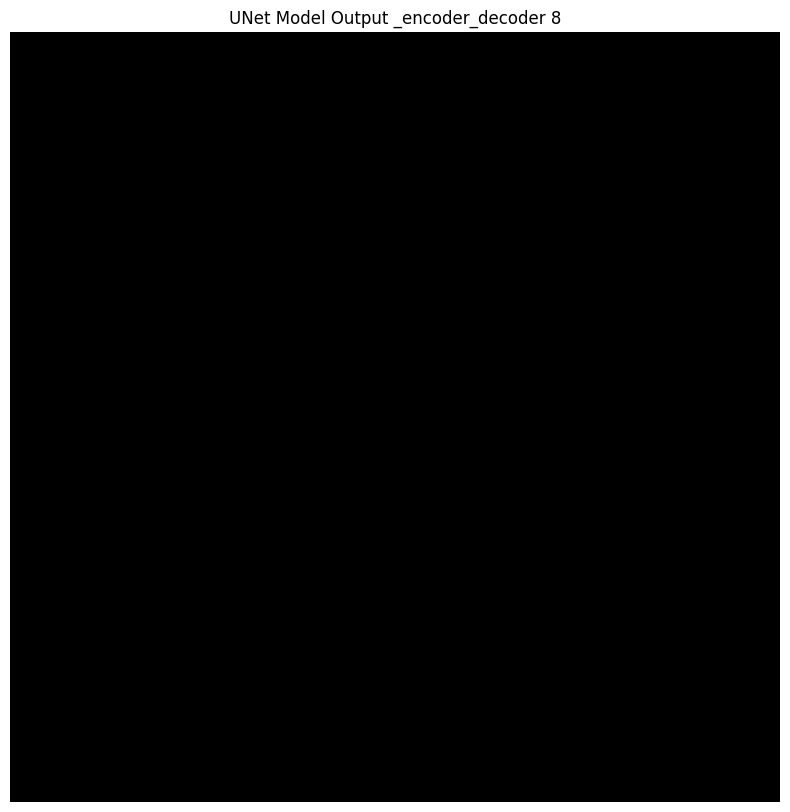

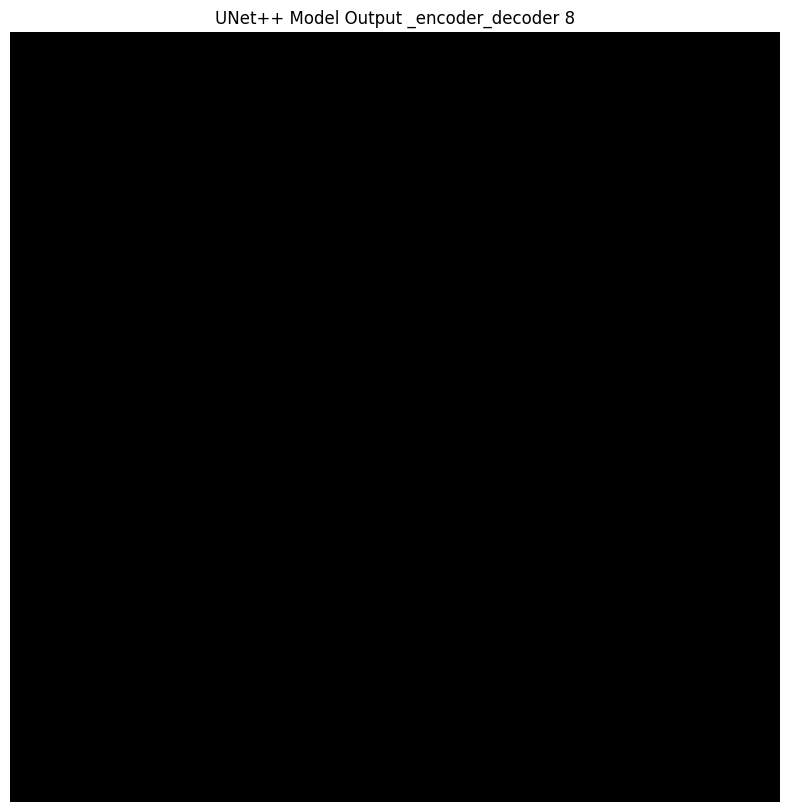

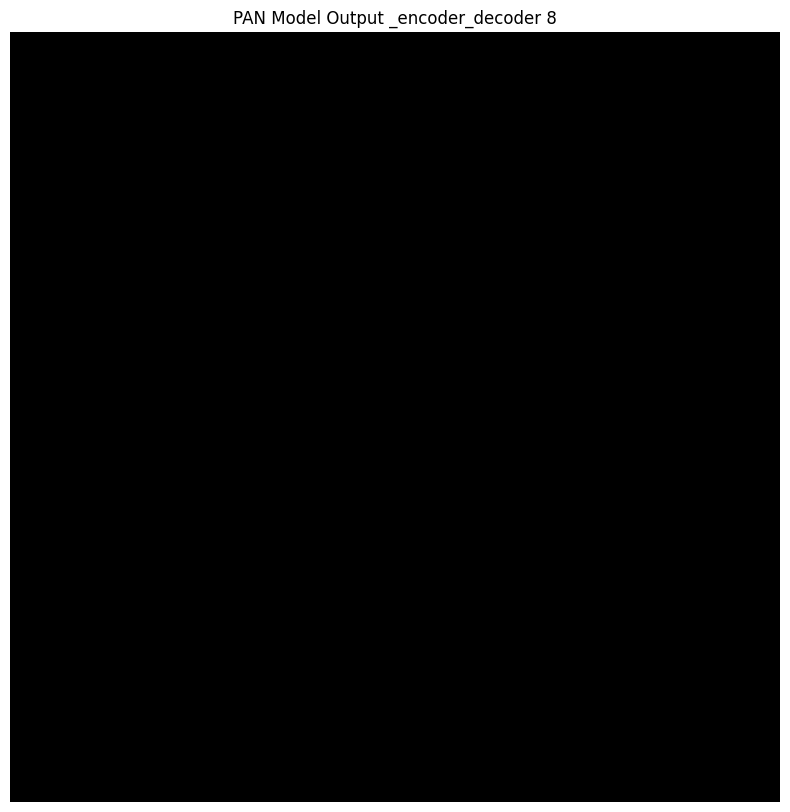

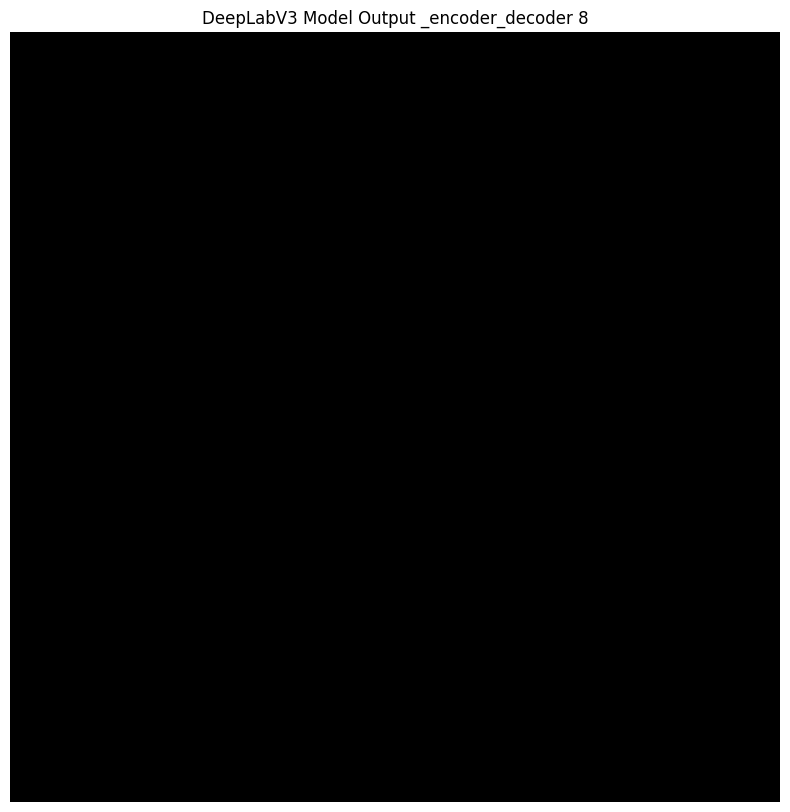

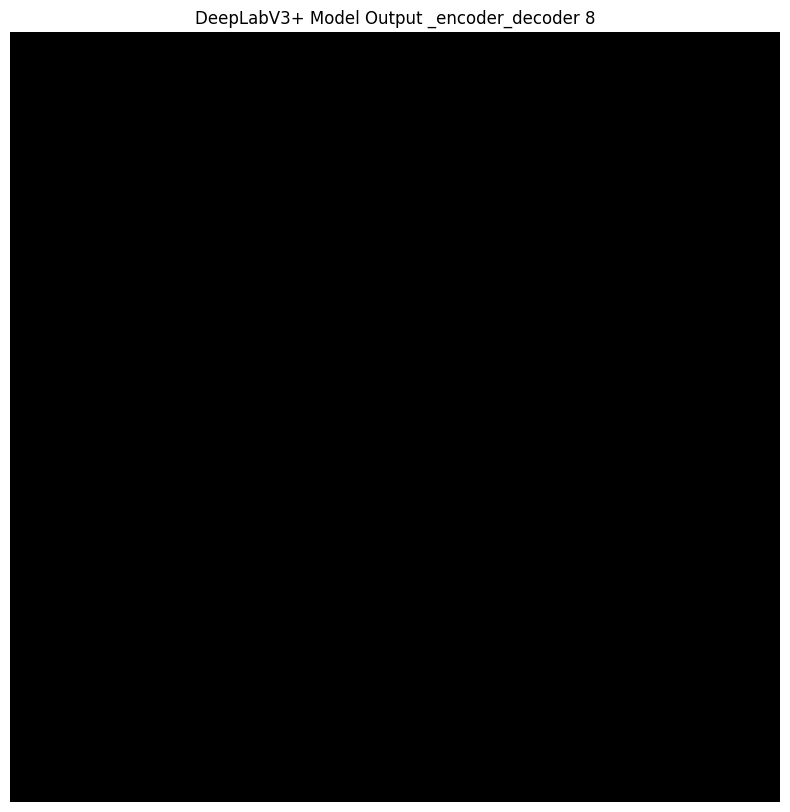

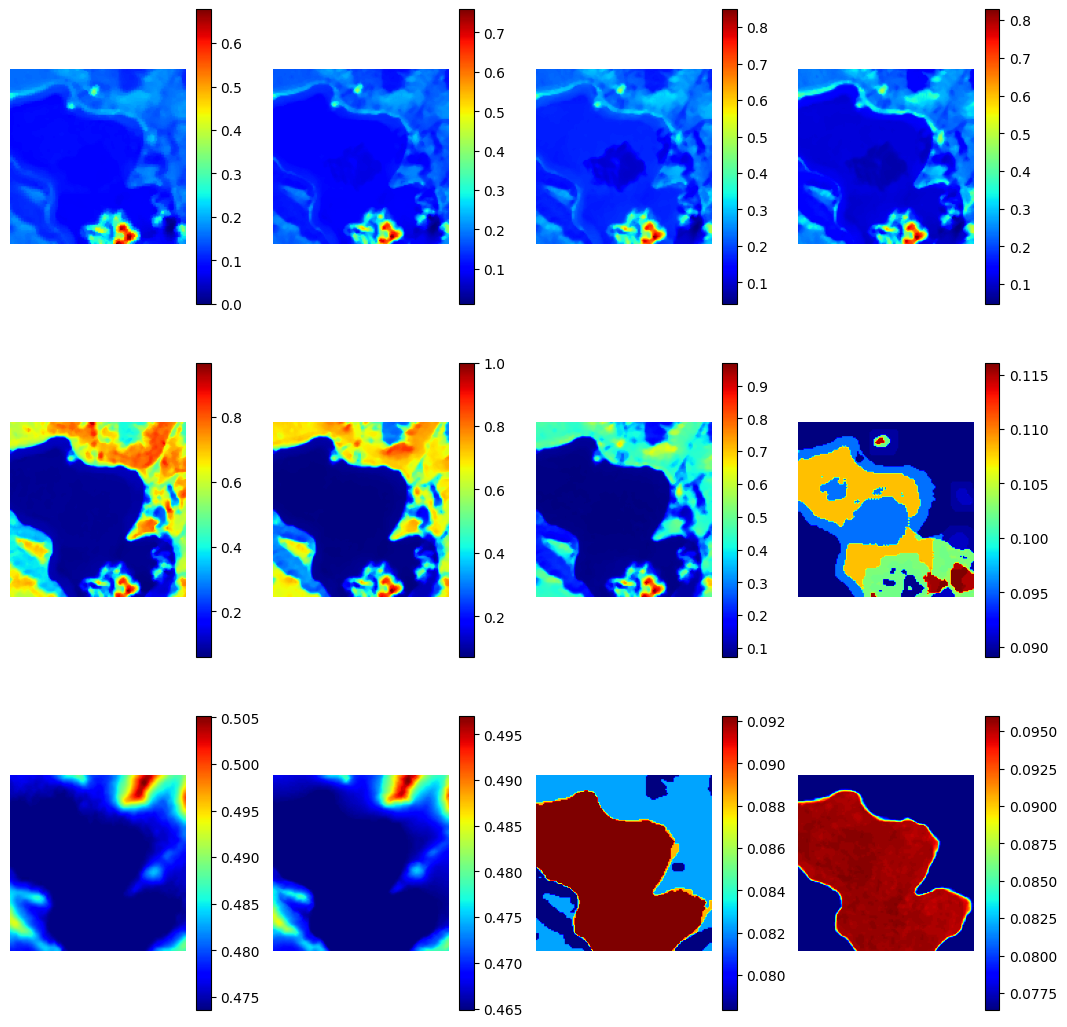

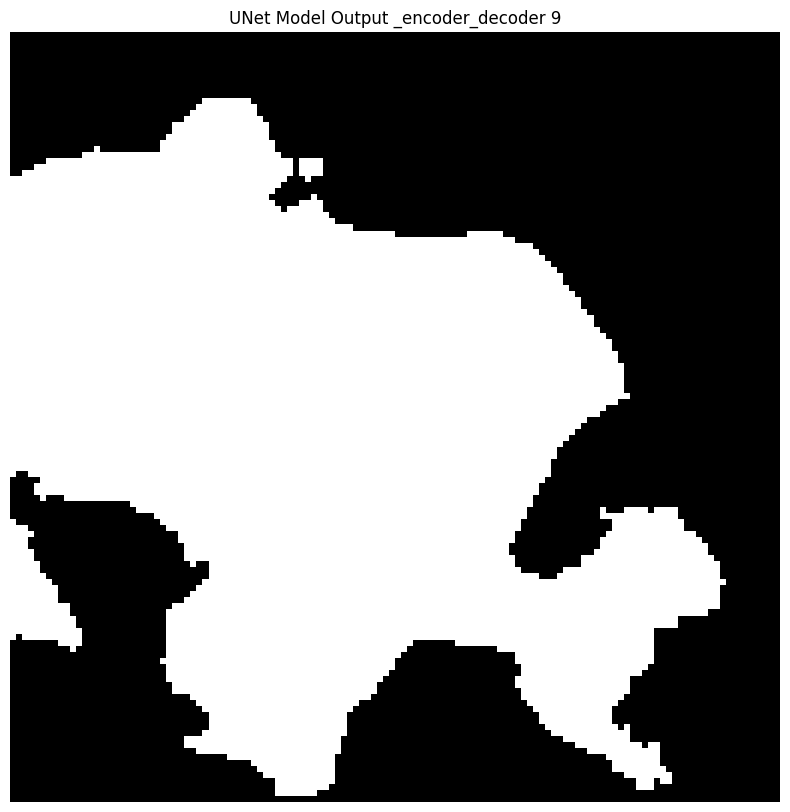

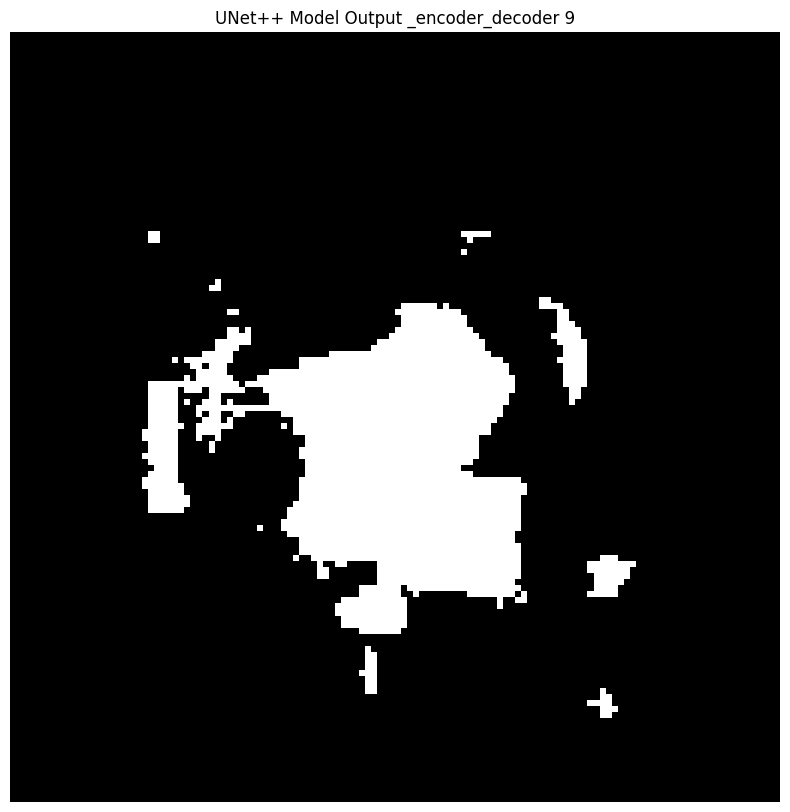

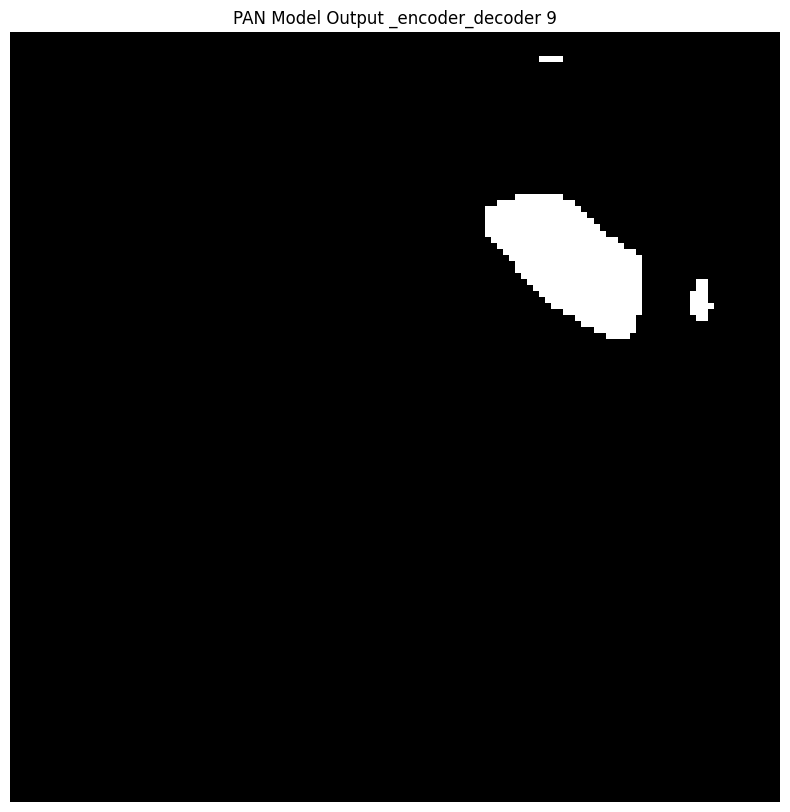

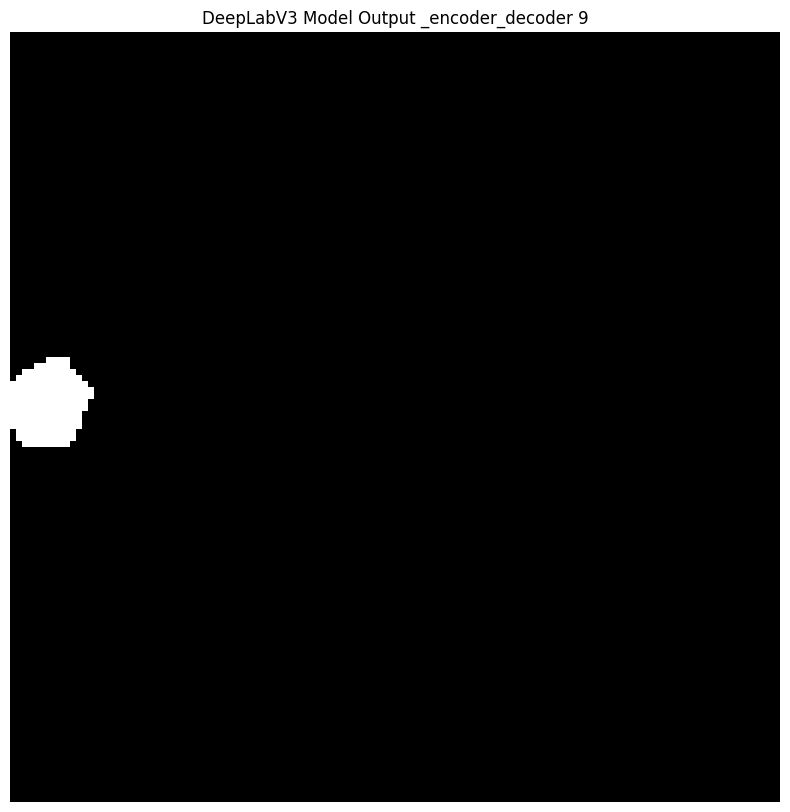

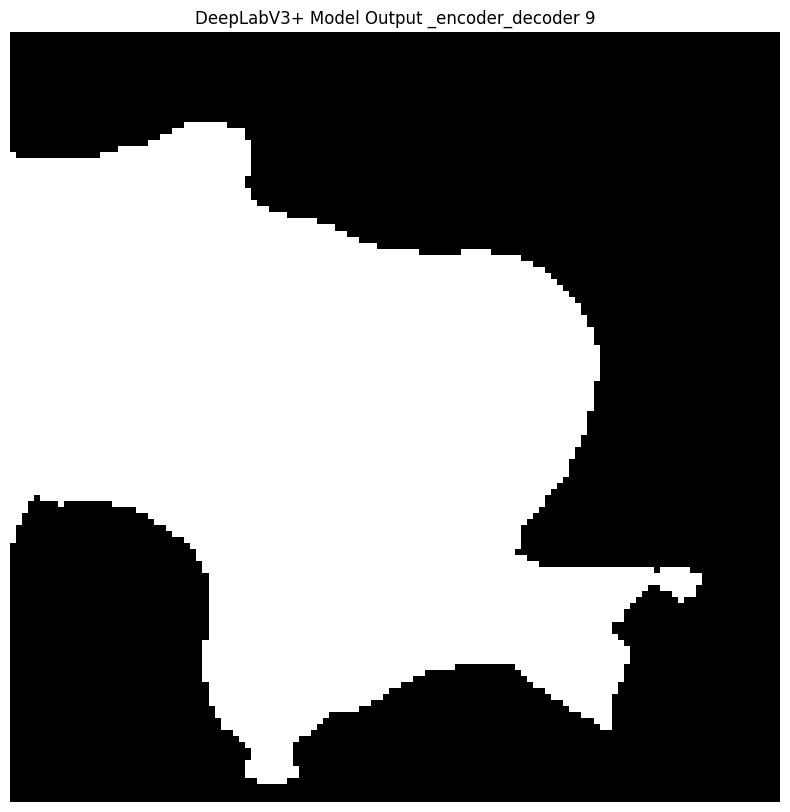

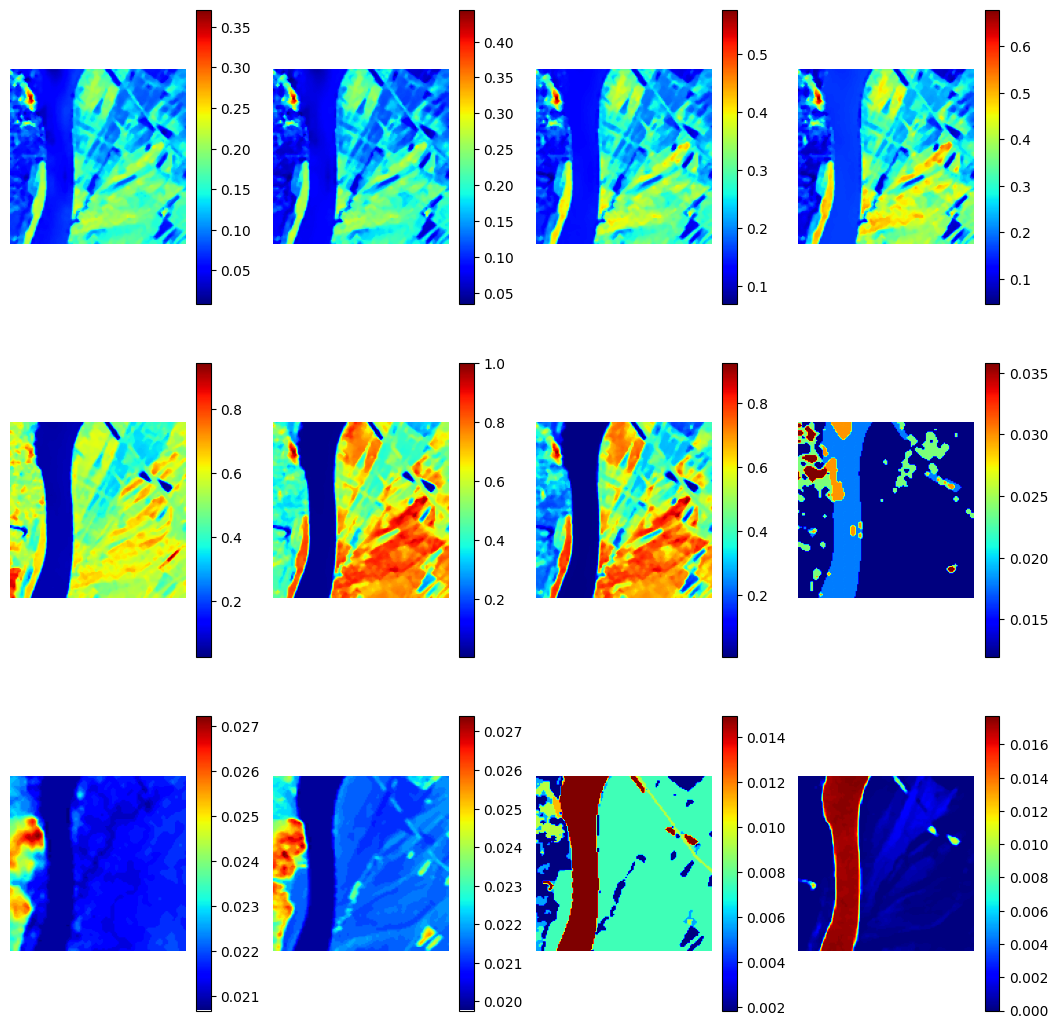

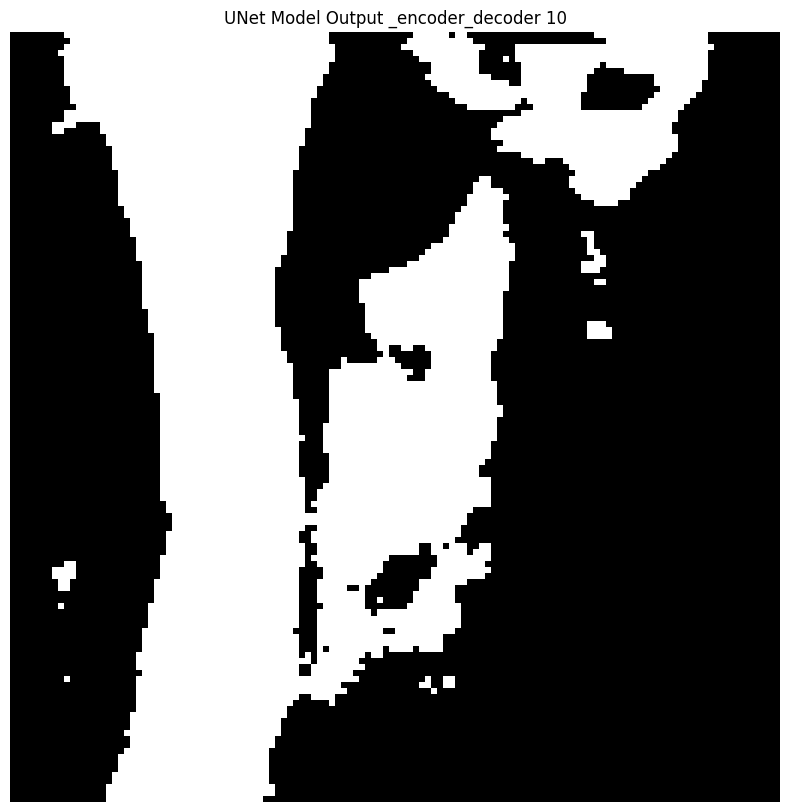

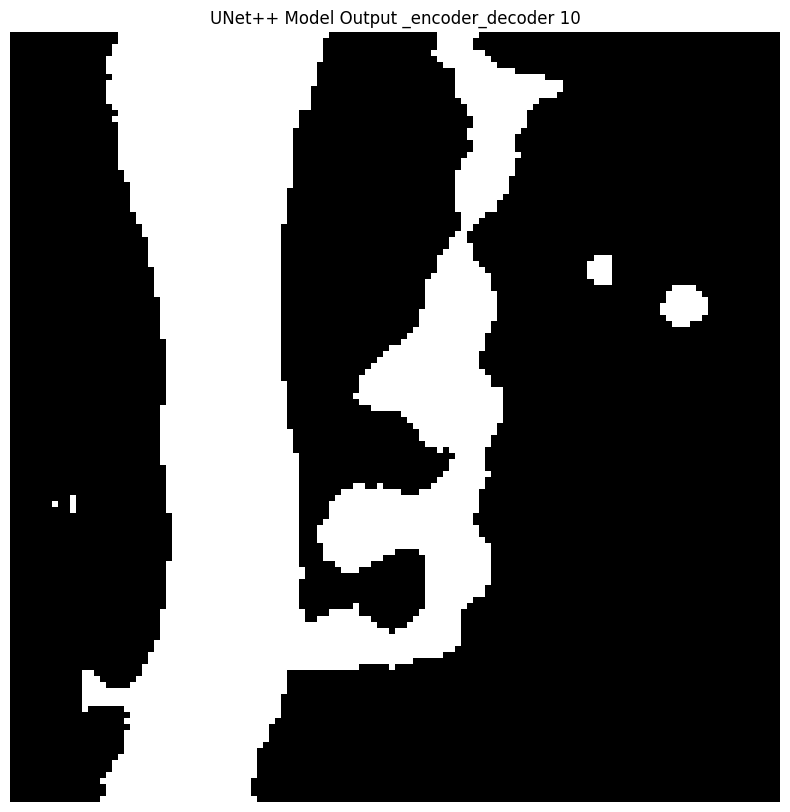

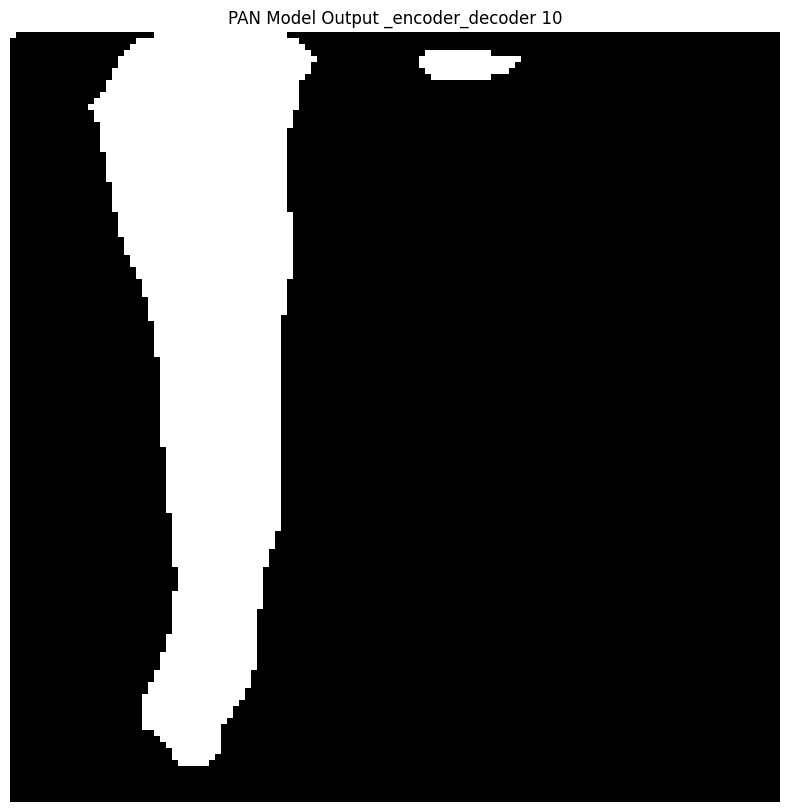

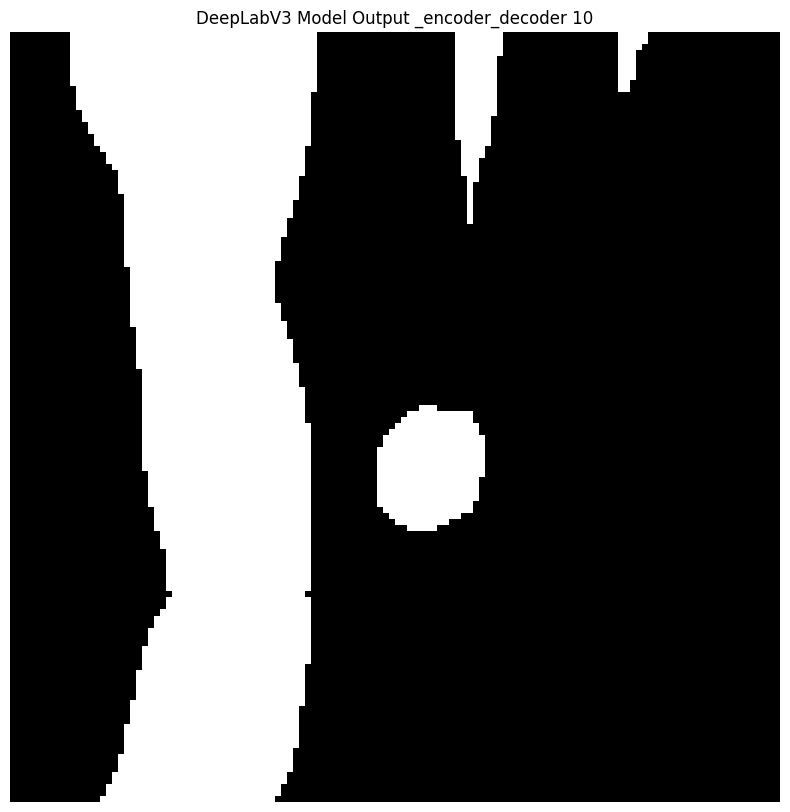

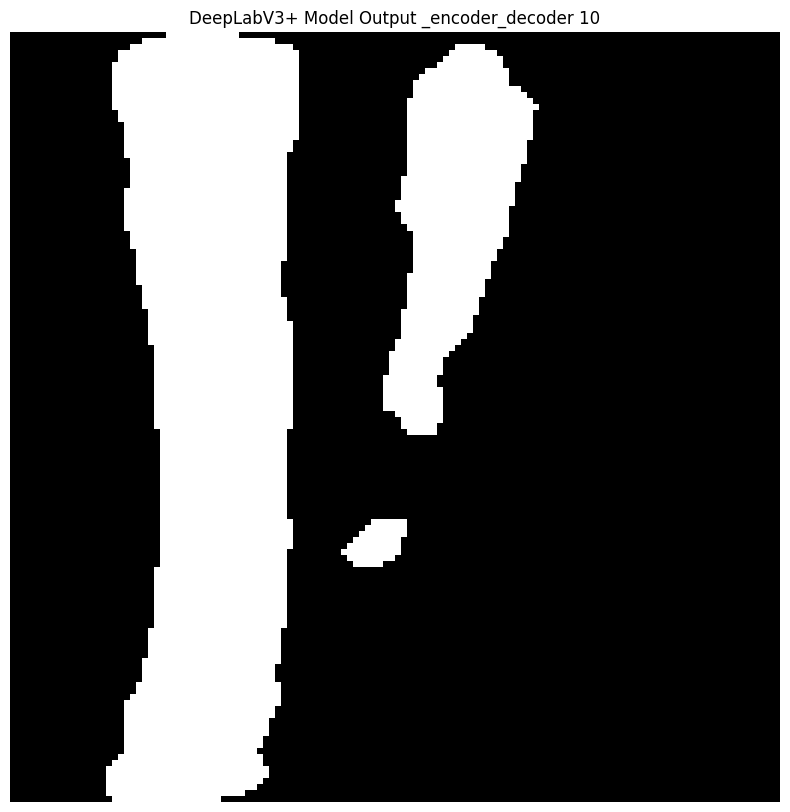

In [37]:
def generate_and_show_output_2(model, input_batch, title):
    with torch.no_grad():
        output = model(input_batch)
        output = output.squeeze(0).cpu().numpy()  # Move to CPU and convert to numpy
        output = (output > 0.5).astype(np.uint8)  # Apply thresholding if needed
        plt.figure(figsize=(10, 10))
        plt.imshow(output[0], cmap='gray')
        plt.title(title)
        plt.axis('off')
        plt.show()


# Set models to evaluation mode
Unet_encoder_decoder_model.eval()
UnetPlusPlus_encoder_decoder_model.eval()
pan_encoder_decoder_model.eval()
DeepLabV3_encoder_decoder_model.eval()
DeepLabV3Plus_encoder_decoder_model.eval()

# Sample size
sample_size = 10

# Loop through a sample of the validation images
for i in range(sample_size):
    # Show the input image
    show(dataset_2.images[i], 'None', dataset_2.images[i].shape[2])
    
    # Prepare the input batch
    input_batch = val_images_torch[i].unsqueeze(0).to(device)  # Add dimension and move to device
    
    # Generate and show outputs for each model
    generate_and_show_output_2(Unet_encoder_decoder_model, input_batch, f'UNet Model Output _encoder_decoder {i+1}')
    generate_and_show_output_2(UnetPlusPlus_encoder_decoder_model, input_batch, f'UNet++ Model Output _encoder_decoder {i+1}')
    generate_and_show_output_2(pan_encoder_decoder_model, input_batch, f'PAN Model Output _encoder_decoder {i+1}')
    generate_and_show_output_2(DeepLabV3_encoder_decoder_model, input_batch, f'DeepLabV3 Model Output _encoder_decoder {i+1}')
    generate_and_show_output_2(DeepLabV3Plus_encoder_decoder_model, input_batch, f'DeepLabV3+ Model Output _encoder_decoder {i+1}')


In [38]:


# Ensure model is in evaluation mode
DeepLabV3Plus_encoder_decoder_model.eval()

# Directory to save output images
output_dir = "/kaggle/working/outputs/labels"
os.makedirs(output_dir, exist_ok=True)


# Get the filenames from the dataset (assuming you have a method to retrieve them)
input_filenames = dataset_2.image_files  # Replace with actual method to get filenames

# Run inference and save images
with torch.no_grad():
    for i in range(val_images_torch.size(0)):
        # Get the image
        image = val_images_torch[i].unsqueeze(0).to(device)
        
        # Pass through the model
        output = DeepLabV3Plus_encoder_decoder_model(image)
        
        # Check if output is an OrderedDict and extract tensor
        if isinstance(output, dict):
            output = output['out']  # Adjust the key based on the actual output dictionary
        
        # Convert to numpy and remove singleton dimensions
        output_image = output.squeeze().cpu().numpy()  # Remove singleton dimensions and convert to numpy
        output_image = (output_image > 0.5).astype(np.uint8)
                
        # Use the same filename as the input image but change extension to .png
        input_filename = input_filenames[i]  # Get the filename for the current image
        base_filename = os.path.splitext(os.path.basename(input_filename))[0]  # Strip extension
        output_filename = os.path.join(output_dir, f"{base_filename}.png")  # Add .png extension
        
        # Save the output image as a PNG file
        plt.imsave(output_filename, output_image, cmap='gray')  # Adjust cmap if needed
        print(f"Saved {output_filename}")


Saved /kaggle/working/outputs/labels/306.png
Saved /kaggle/working/outputs/labels/307.png
Saved /kaggle/working/outputs/labels/308.png
Saved /kaggle/working/outputs/labels/309.png
Saved /kaggle/working/outputs/labels/310.png
Saved /kaggle/working/outputs/labels/311.png
Saved /kaggle/working/outputs/labels/312.png
Saved /kaggle/working/outputs/labels/313.png
Saved /kaggle/working/outputs/labels/314.png
Saved /kaggle/working/outputs/labels/315.png
Saved /kaggle/working/outputs/labels/316.png
Saved /kaggle/working/outputs/labels/317.png
Saved /kaggle/working/outputs/labels/318.png
Saved /kaggle/working/outputs/labels/319.png
Saved /kaggle/working/outputs/labels/320.png
Saved /kaggle/working/outputs/labels/321.png
Saved /kaggle/working/outputs/labels/322.png
Saved /kaggle/working/outputs/labels/323.png
Saved /kaggle/working/outputs/labels/324.png
Saved /kaggle/working/outputs/labels/325.png
Saved /kaggle/working/outputs/labels/326.png
Saved /kaggle/working/outputs/labels/327.png
Saved /kag

In [39]:
import shutil

shutil.make_archive("/kaggle/working/outputs/labels", 'zip', output_dir)


'/kaggle/working/outputs/labels.zip'

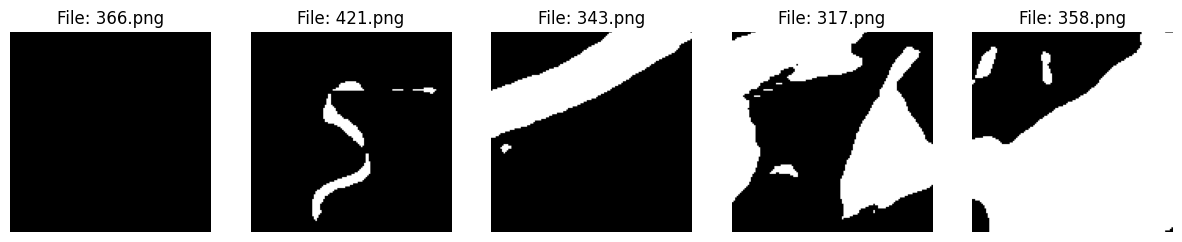

In [40]:
# Path to the directory with saved images
output_dir = "/kaggle/working/outputs/labels"

# List all files in the directory
file_list = [f for f in os.listdir(output_dir) if f.endswith('.png')]

# Number of samples to display
num_display = 5

# Randomly sample filenames
sampled_files = np.random.choice(file_list, num_display, replace=False)

# Set up the figure
fig, axs = plt.subplots(1, num_display, figsize=(15, 5))

for idx, file_name in enumerate(sampled_files):
    # Load and display the image
    image_path = os.path.join(output_dir, file_name)
    img = mpimg.imread(image_path)
    1
    # Display the image
    axs[idx].imshow(img, cmap='gray')  # Adjust cmap if needed
    axs[idx].set_title(f"File: {file_name}")
    axs[idx].axis('off')

plt.show()


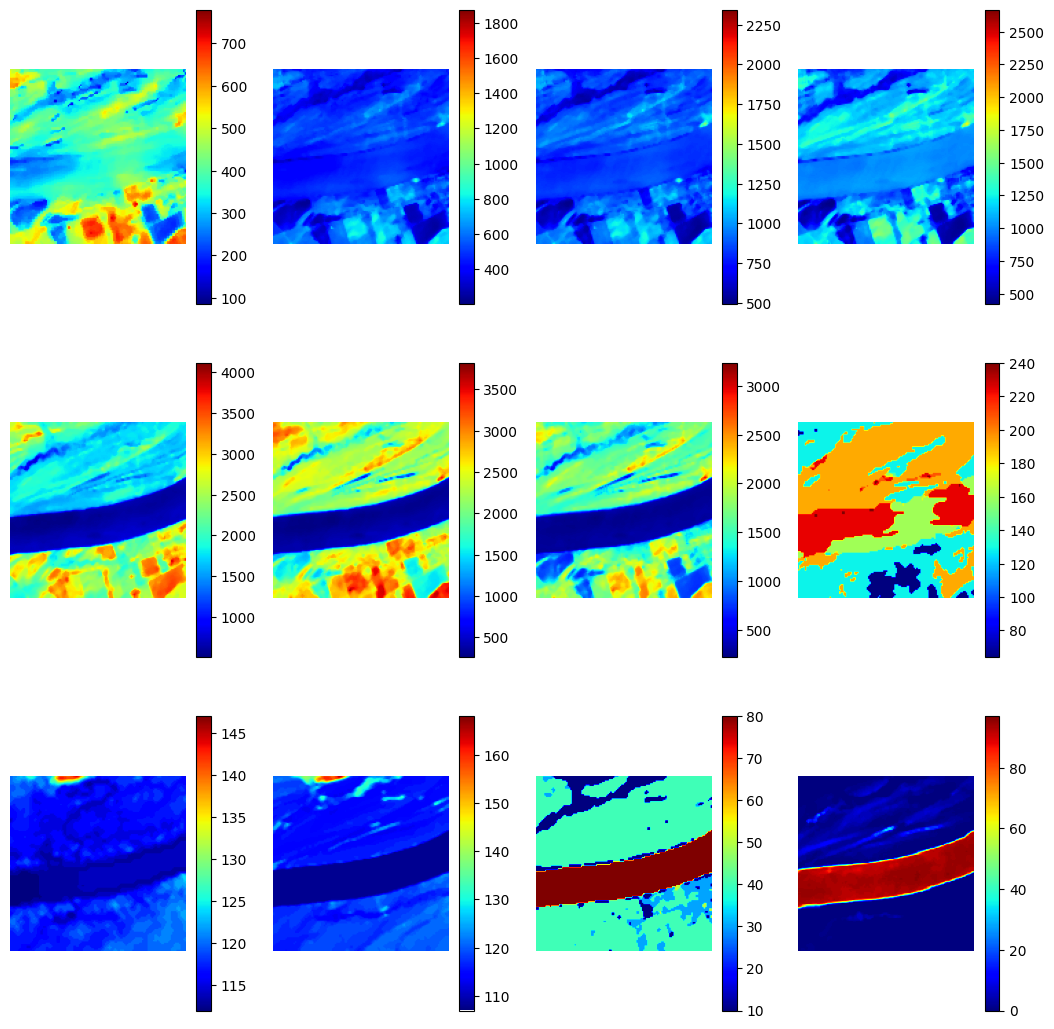

In [41]:
image = tiff.imread('/kaggle/input/satellite-data/satalite data/val/images/361.tif')
image_array = np.array(image)
show(image_array,'medianBlur',image_array.shape[2])


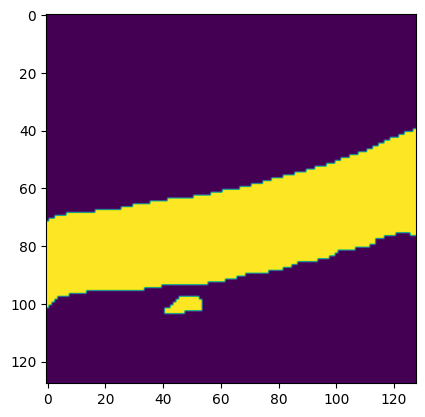

In [43]:
from PIL import Image
import torch
import segmentation_models_pytorch as smp
import tifffile as tiff
import torch.nn as nn
import numpy as np

# Define a function to load your model
class seg_ConvDeconvNet(nn.Module):
    def __init__(self, model):
        super(seg_ConvDeconvNet, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=16, kernel_size=3, stride=1, padding=1),  # Output: (16, H, W)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: (16, H/2, W/2)
            
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),  # Output: (32, H/2, W/2)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Output: (32, H/4, W/4)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=2, stride=2),  # Output: (16, H/2, W/2)
            nn.ReLU(),
            
            nn.ConvTranspose2d(in_channels=16, out_channels=3, kernel_size=2, stride=2),  # Output: (3, H, W)
            nn.ReLU()
        )
        
        self.segmentation_model = model  # Assign the model parameter

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        x = self.segmentation_model(x)
        return x

def load_model(model_path):
    model = smp.DeepLabV3Plus(encoder_name='resnet34', encoder_depth=5, encoder_weights='imagenet', encoder_output_stride=16, decoder_channels=128)
    model = seg_ConvDeconvNet(model)
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    model.eval()
    return model

# Define a function to perform inference
def predict_image(model, image):
    image = image.unsqueeze(0).permute(0, 3, 1, 2)  # Add batch dimension and permute dimensions
  # Add batch dimension
    with torch.no_grad():
        output = model(image)
        output = output.squeeze(0)  # Remove batch dimension
        output = output.cpu().numpy()
        output = (output > 0.5).astype(np.uint8)
    return output

def normalize(image):
    """
    Normalize the image to the range [0, 1].
    
    Parameters:
    - image (numpy.ndarray): Input image.
    
    Returns:
    - numpy.ndarray: Normalized image.
    """
    # Normalize each band to [0, 1]
    min_val = np.min(image)
    max_val = np.max(image)
    normalized_image = (image - min_val) / (max_val - min_val)
    return normalized_image

image = tiff.imread("/kaggle/input/satellite-data/satalite data/val/images/361.tif")
image_array = np.array(image)
image_array_normal = normalize(image_array)
image_array_tensor = torch.tensor(image_array_normal).float()
    # Load the model
model = load_model('/kaggle/working/DeepLabV3Plus_encoder_decoder_model.pth')
    # Perform prediction
segmented_image = predict_image(model, image_array_tensor)
    # Display the segmented image
segmented_image = segmented_image.squeeze(0)
plt.imshow(segmented_image)
